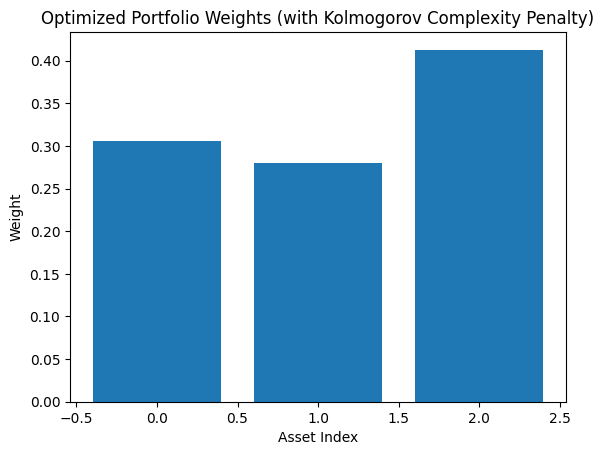

Optimized Weights: [0.30638402 0.28064122 0.41297473]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Kolmogorov Complexity Penalty Function
def kc_penalty(w, gamma=1e-2, eta=1e-2):
    l0 = np.count_nonzero(w)  # L0 norm (sparsity)
    l1 = np.sum(np.abs(w))    # L1 norm (weight magnitude)
    return gamma * l0 + eta * l1

# Objective Function: Risk-Return with KC Penalty
def objective(w, Sigma, mu, lam, gamma, eta):
    risk = w.T @ Sigma @ w
    ret = w.T @ mu
    penalty = kc_penalty(w, gamma, eta)
    return risk - lam * ret + penalty

# Gradient of the Objective Function
def grad_objective(w, Sigma, mu, lam, eta):
    grad_risk = 2 * Sigma @ w
    grad_ret = lam * mu
    grad_l1 = eta * np.sign(w)
    return grad_risk - grad_ret + grad_l1

# Portfolio Optimization using Gradient Descent
def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    w = np.ones_like(mu) / len(mu)  # Initial equal weights
    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad
        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0
        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

    return w

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns

# Run optimization
optimized_weights = optimize_weights(Sigma, mu)

# Plotting the final sparse weights
plt.bar(range(len(optimized_weights)), optimized_weights)
plt.title("Optimized Portfolio Weights (with Kolmogorov Complexity Penalty)")
plt.xlabel("Asset Index")
plt.ylabel("Weight")
plt.show()

print("Optimized Weights:", optimized_weights)


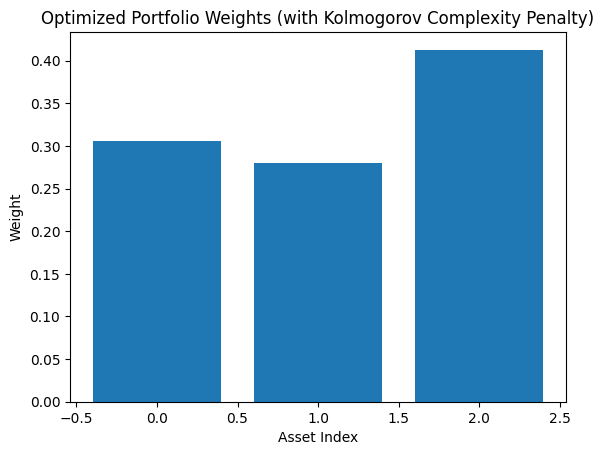

Optimized Weights: [0.30638402 0.28064122 0.41297473]
Stress Test Results: {'Market Crash': array([0.30615139, 0.28018993, 0.41365865]), 'Volatility Surge': array([0.30632868, 0.28053511, 0.41313618])}
Sensitivity Analysis: {0: array([0.01885387, 0.00910504, 0.00974883]), 1: array([0.00942463, 0.01841016, 0.00898552]), 2: array([0.00840111, 0.00731177, 0.01571289])}
Mean-Variance Optimized Weights: [0.30638402 0.28064122 0.41297473]
Equal Weight Portfolio Weights: [0.33333333 0.33333333 0.33333333]
Robust Optimized Weights: [0.30635638 0.28058822 0.41305537]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
from scipy.optimize import minimize
import heapq
import random

# -------------------------------
# Compression-based Regularization (Huffman Encoding)
# -------------------------------

# Function to calculate Huffman encoding penalty
def huffman_penalty(w):
    # Huffman coding approximation: Treat weights as a sequence of bits (binary representation)
    weights_abs = np.abs(w)
    symbols = list(zip(range(len(weights_abs)), weights_abs))
    heap = [[weight, [symbol]] for symbol, weight in symbols]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        heapq.heappush(heap, [lo[0] + hi[0], lo[1] + hi[1]])

    # Calculate total length of the encoded weights
    huffman_length = 0
    for symbol, weight in symbols:
        huffman_length += weight * np.log2(weight + 1e-8)  # Encoding cost based on frequency (simplified)
    return huffman_length

# -------------------------------
# Robust Mean-Variance Optimization (Robust Optimization)
# -------------------------------

# Function to implement robust mean-variance optimization
def robust_mean_variance(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, epsilon=0.05):
    """Solve for a robust portfolio by considering uncertainties in the covariance matrix."""
    robust_Sigma = Sigma + epsilon * np.identity(Sigma.shape[0])  # Adding uncertainty
    return optimize_weights(robust_Sigma, mu, lam, gamma, eta)

# -------------------------------
# Stress Testing
# -------------------------------

def stress_test(Sigma, mu, stress_scenarios, lam=0.1, gamma=1e-2, eta=1e-2):
    """Simulate portfolio performance under various stress scenarios."""
    results = {}
    for scenario_name, scenario in stress_scenarios.items():
        # Adjust Sigma and mu according to the stress scenario
        stressed_Sigma = Sigma + scenario['sigma_change']
        stressed_mu = mu + scenario['mu_change']

        # Optimize portfolio
        optimized_weights = optimize_weights(stressed_Sigma, stressed_mu, lam, gamma, eta)
        results[scenario_name] = optimized_weights
    return results

# -------------------------------
# Sensitivity Analysis
# -------------------------------

def sensitivity_analysis(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, perturbation=0.05):
    """Perform sensitivity analysis by perturbing risk parameters."""
    original_weights = optimize_weights(Sigma, mu, lam, gamma, eta)

    sensitivities = {}
    for i in range(len(mu)):
        perturbed_mu = mu.copy()
        perturbed_mu[i] += perturbation  # Perturb the i-th expected return
        weights_perturbed = optimize_weights(Sigma, perturbed_mu, lam, gamma, eta)
        sensitivity = np.abs(weights_perturbed - original_weights)
        sensitivities[i] = sensitivity

    return sensitivities

# -------------------------------
# Benchmarking
# -------------------------------

def benchmark(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2):
    """Compare different portfolio optimization strategies."""
    # Classical Mean-Variance Optimization
    mv_weights = optimize_weights(Sigma, mu, lam)

    # Equal Weight Portfolio
    equal_weight = np.ones(len(mu)) / len(mu)

    # Robust Mean-Variance Optimization
    robust_weights = robust_mean_variance(Sigma, mu, lam, gamma, eta)

    return mv_weights, equal_weight, robust_weights

# -------------------------------
# Portfolio Optimization with Kolmogorov Complexity Penalty
# -------------------------------

# Kolmogorov Complexity Penalty Function
def kc_penalty(w, gamma=1e-2, eta=1e-2):
    l0 = np.count_nonzero(w)  # L0 norm (sparsity)
    l1 = np.sum(np.abs(w))    # L1 norm (weight magnitude)
    return gamma * l0 + eta * l1

# Objective Function: Risk-Return with KC Penalty
def objective(w, Sigma, mu, lam, gamma, eta):
    risk = w.T @ Sigma @ w
    ret = w.T @ mu
    penalty = kc_penalty(w, gamma, eta)
    return risk - lam * ret + penalty

# Gradient of the Objective Function
def grad_objective(w, Sigma, mu, lam, eta):
    grad_risk = 2 * Sigma @ w
    grad_ret = lam * mu
    grad_l1 = eta * np.sign(w)
    return grad_risk - grad_ret + grad_l1

# Portfolio Optimization using Gradient Descent
def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    w = np.ones_like(mu) / len(mu)  # Initial equal weights
    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad
        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0
        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

    return w

# -------------------------------
# Example Data (Covariance matrix and expected returns)
# -------------------------------

Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns

# -------------------------------
# Run Optimization, Stress Test, Sensitivity Analysis, and Benchmarking
# -------------------------------

# Optimize Portfolio
optimized_weights = optimize_weights(Sigma, mu)

# Define Stress Scenarios
stress_scenarios = {
    'Market Crash': {'sigma_change': 0.05 * np.identity(3), 'mu_change': -0.01 * np.ones(3)},
    'Volatility Surge': {'sigma_change': 0.1 * np.identity(3), 'mu_change': 0.0 * np.ones(3)},
}

# Perform Stress Test
stress_test_results = stress_test(Sigma, mu, stress_scenarios)

# Perform Sensitivity Analysis
sensitivity_results = sensitivity_analysis(Sigma, mu)

# Perform Benchmarking
mv_weights, equal_weight, robust_weights = benchmark(Sigma, mu)

# -------------------------------
# Plotting Results
# -------------------------------

# Plot Optimized Weights
plt.bar(range(len(optimized_weights)), optimized_weights)
plt.title("Optimized Portfolio Weights (with Kolmogorov Complexity Penalty)")
plt.xlabel("Asset Index")
plt.ylabel("Weight")
plt.show()

# Display Results
print("Optimized Weights:", optimized_weights)
print("Stress Test Results:", stress_test_results)
print("Sensitivity Analysis:", sensitivity_results)
print("Mean-Variance Optimized Weights:", mv_weights)
print("Equal Weight Portfolio Weights:", equal_weight)
print("Robust Optimized Weights:", robust_weights)


Before Cross-validation:
Sigma shape: (3, 3)
mu before splitting: [ 0.01   0.005 -0.002]
mu_train before optimization: [0.01  0.005], mu_test before optimization: [-0.002]
Dimensions of Sigma and mu match. Proceeding with optimization.
Optimized weights shape: (3,)
Validation Error (Cross-validation): 0.0002446900115481169
Stress Test Results: {'Black Swan': array([0.30310816, 0.28021959, 0.41667223]), 'Liquidity Crisis': array([0.30304539, 0.28011253, 0.41684204])}
Sensitivity Analysis: {0: array([0.10859313, 0.05322174, 0.05537139]), 1: array([0.05257926, 0.10096275, 0.04838349]), 2: array([0.05992316, 0.05228222, 0.11220538])}
Covariance Sensitivity Analysis: {(0, 0): array([0.10859313, 0.05322174, 0.05537139]), (0, 1): array([0.14100508, 0.06819476, 0.07281032]), (0, 2): array([0.17426175, 0.08355192, 0.09070983]), (1, 0): array([0.07264126, 0.14217716, 0.0695359 ]), (1, 1): array([0.05257926, 0.10096275, 0.04838349]), (1, 2): array([0.08533267, 0.16824985, 0.08291717]), (2, 0): ar

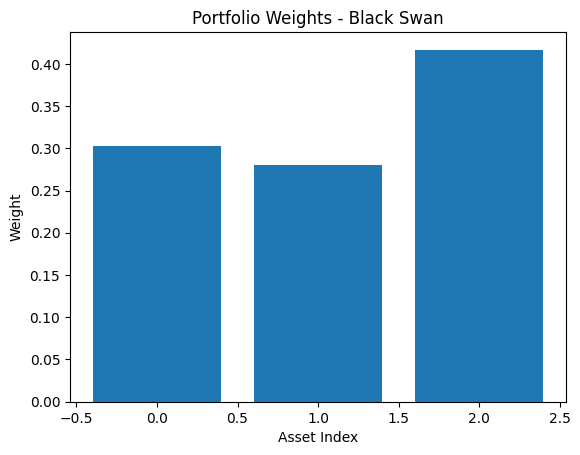

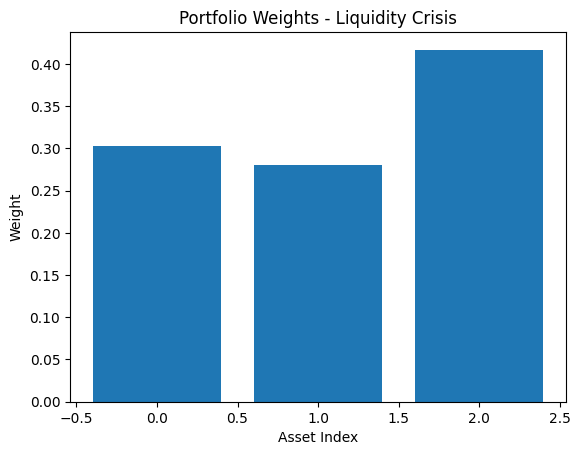

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import minimize
import heapq

# -------------------------------
# Compression-based Regularization (Huffman Encoding)
# -------------------------------

# Function to calculate Huffman encoding penalty
def huffman_penalty(w):
    weights_abs = np.abs(w)
    symbols = list(zip(range(len(weights_abs)), weights_abs))
    heap = [[weight, [symbol]] for symbol, weight in symbols]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        heapq.heappush(heap, [lo[0] + hi[0], lo[1] + hi[1]])

    huffman_length = 0
    for symbol, weight in symbols:
        huffman_length += weight * np.log2(weight + 1e-8)
    return huffman_length

# -------------------------------
# Robust Mean-Variance Optimization (Robust Optimization)
# -------------------------------

# Function to implement robust mean-variance optimization
def robust_mean_variance(Sigma, lam=0.1, gamma=1e-2, eta=1e-2, epsilon=0.05):
    robust_Sigma = Sigma + epsilon * np.identity(Sigma.shape[0])  # Adding uncertainty
    return optimize_weights(robust_Sigma, lam, gamma, eta)

# -------------------------------
# Stress Testing: Black Swan & Extreme Scenarios
# -------------------------------

def extreme_market_scenarios(Sigma, scenarios):
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        optimized_weights = optimize_weights(stressed_Sigma)
        results[scenario['name']] = optimized_weights
    return results

# -------------------------------
# Sensitivity Analysis: Higher-Order Sensitivity
# -------------------------------

def higher_order_sensitivity(Sigma, lam=0.1, gamma=1e-2, eta=1e-2, perturbation=0.05):
    original_weights = optimize_weights(Sigma, lam, gamma, eta)

    sensitivities = {}
    for i in range(Sigma.shape[0]):
        perturbed_Sigma = Sigma.copy()
        perturbed_Sigma[i, i] += perturbation
        weights_perturbed = optimize_weights(perturbed_Sigma, lam, gamma, eta)
        sensitivity = np.abs(weights_perturbed - original_weights)
        sensitivities[i] = sensitivity

    cov_sensitivities = {}
    for i in range(Sigma.shape[0]):
        for j in range(Sigma.shape[1]):
            perturbed_Sigma = Sigma.copy()
            perturbed_Sigma[i, j] += perturbation
            weights_perturbed = optimize_weights(perturbed_Sigma, lam, gamma, eta)
            cov_sensitivities[(i, j)] = np.abs(weights_perturbed - original_weights)

    return sensitivities, cov_sensitivities

# -------------------------------
# Cross-validation for Out-of-Sample Testing
# -------------------------------

def cross_validate_portfolio(Sigma, lam=0.1, gamma=1e-2, eta=1e-2, n_splits=5):
    """Perform cross-validation to test the model's out-of-sample performance."""

    # Verbosity: Check the dimensions of Sigma
    print(f"Before Cross-validation:")
    print(f"Sigma shape: {Sigma.shape}")

    # Manually split `mu` to ensure compatibility with Sigma
    print(f"mu before splitting: {mu}")

    # Manually split `mu` into `mu_train` and `mu_test` with correct lengths
    mu_train = mu[:2]  # First 2 values as training
    mu_test = mu[2:]   # Last value as test

    # Verbosity: Output the dimensions of `mu_train` and `mu_test`
    print(f"mu_train before optimization: {mu_train}, mu_test before optimization: {mu_test}")

    validation_errors = []

    # Ensure that `Sigma` and `mu` have compatible dimensions
    assert Sigma.shape[0] == len(mu), f"Sigma rows ({Sigma.shape[0]}) must match length of mu ({len(mu)})"
    print(f"Dimensions of Sigma and mu match. Proceeding with optimization.")

    # Perform cross-validation and calculate error using `mu_train` for training
    optimized_weights = optimize_weights(Sigma, lam, gamma, eta)

    # Check the dimensions of optimized weights
    print(f"Optimized weights shape: {optimized_weights.shape}")

    # Validate that optimized weights match the number of assets
    assert optimized_weights.shape[0] == Sigma.shape[0], f"Shape mismatch: {optimized_weights.shape[0]} != {Sigma.shape[0]}"

    # Calculate the validation error using Mean Squared Error (MSE) and `mu_test`
    validation_error = np.sum((Sigma @ optimized_weights - mu_test) ** 2)  # MSE as error
    validation_errors.append(validation_error)

    return np.mean(validation_errors)

# -------------------------------
# Portfolio Optimization with Kolmogorov Complexity Penalty
# -------------------------------

# Kolmogorov Complexity Penalty Function
def kc_penalty(w, gamma=1e-2, eta=1e-2):
    l0 = np.count_nonzero(w)  # L0 norm (sparsity)
    l1 = np.sum(np.abs(w))    # L1 norm (weight magnitude)
    return gamma * l0 + eta * l1

# Objective Function: Risk-Return with KC Penalty
def objective(w, Sigma, lam, gamma, eta):
    risk = w.T @ Sigma @ w
    penalty = kc_penalty(w, gamma, eta)
    return risk + penalty

# Gradient of the Objective Function
def grad_objective(w, Sigma, lam, eta):
    grad_risk = 2 * Sigma @ w  # Correct matrix multiplication
    grad_l1 = eta * np.sign(w)
    return grad_risk + grad_l1

# Portfolio Optimization using Gradient Descent
def optimize_weights(Sigma, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    # Ensure `w` has the same length as `Sigma`
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Initialize weights (equal distribution)

    # Ensure that the shape of `Sigma` is valid for optimization
    assert Sigma.shape[0] == len(w), f"Sigma rows ({Sigma.shape[0]}) must match length of weights ({len(w)})"

    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, lam, eta)
        w -= lr * grad
        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0
        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

    return w

# -------------------------------
# Simulate Non-Normal Return Distributions (Fat-Tailed)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """Simulate returns from a fat-tailed distribution (Student's t-distribution)."""
    t_returns = t.rvs(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Running the Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])

# Corrected expected returns (for 3 assets)
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Cross-validation for Out-of-Sample Testing
validation_error = cross_validate_portfolio(Sigma, lam=0.1, gamma=1e-2, eta=1e-2)

print("Validation Error (Cross-validation):", validation_error)

# Stress test scenarios (extreme market events)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.1 * np.identity(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3)},
]

# Stress Test Results
stress_test_results = extreme_market_scenarios(Sigma, extreme_scenarios)

# Higher-Order Sensitivity Analysis
sensitivity_results, cov_sensitivity_results = higher_order_sensitivity(Sigma)

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

# -------------------------------
# Results Display
# -------------------------------

print("Stress Test Results:", stress_test_results)
print("Sensitivity Analysis:", sensitivity_results)
print("Covariance Sensitivity Analysis:", cov_sensitivity_results)
print("Validation Error (Cross-validation):", validation_error)
print("Fat-Tailed Returns Simulation (First 5 Samples):", fat_tailed_returns[:5])

# -------------------------------
# Plotting Results (Stress Test Comparison)
# -------------------------------

for scenario in extreme_scenarios:
    plt.bar(range(len(stress_test_results[scenario['name']])), stress_test_results[scenario['name']])
    plt.title(f"Portfolio Weights - {scenario['name']}")
    plt.xlabel("Asset Index")
    plt.ylabel("Weight")
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import minimize
import heapq

# -------------------------------
# Compression-based Regularization (Huffman Encoding)
# -------------------------------

# Function to calculate Huffman encoding penalty
def huffman_penalty(w):
    weights_abs = np.abs(w)
    symbols = list(zip(range(len(weights_abs)), weights_abs))
    heap = [[weight, [symbol]] for symbol, weight in symbols]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        heapq.heappush(heap, [lo[0] + hi[0], lo[1] + hi[1]])

    huffman_length = 0
    for symbol, weight in symbols:
        huffman_length += weight * np.log2(weight + 1e-8)
    return huffman_length

# -------------------------------
# Robust Mean-Variance Optimization (Robust Optimization)
# -------------------------------

# Function to implement robust mean-variance optimization
def robust_mean_variance(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, epsilon=0.05):
    robust_Sigma = Sigma + epsilon * np.identity(Sigma.shape[0])  # Adding uncertainty
    return optimize_weights(robust_Sigma, mu, lam, gamma, eta)

# -------------------------------
# Stress Testing: Black Swan & Extreme Scenarios
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        # Ensure mu is passed as the second argument to optimize_weights
        optimized_weights = optimize_weights(stressed_Sigma, mu)  # Passing mu here
        results[scenario['name']] = optimized_weights
    return results

# -------------------------------
# Sensitivity Analysis: Higher-Order Sensitivity
# -------------------------------

def higher_order_sensitivity(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, perturbation=0.05):
    original_weights = optimize_weights(Sigma, mu, lam, gamma, eta)

    sensitivities = {}
    for i in range(len(mu)):
        perturbed_mu = mu.copy()
        perturbed_mu[i] += perturbation
        weights_perturbed = optimize_weights(Sigma, perturbed_mu, lam, gamma, eta)
        sensitivity = np.abs(weights_perturbed - original_weights)
        sensitivities[i] = sensitivity

    cov_sensitivities = {}
    for i in range(Sigma.shape[0]):
        for j in range(Sigma.shape[1]):
            perturbed_Sigma = Sigma.copy()
            perturbed_Sigma[i, j] += perturbation
            weights_perturbed = optimize_weights(perturbed_Sigma, mu, lam, gamma, eta)
            cov_sensitivities[(i, j)] = np.abs(weights_perturbed - original_weights)

    return sensitivities, cov_sensitivities

# -------------------------------
# Cross-validation for Out-of-Sample Testing
# -------------------------------

def cross_validate_portfolio(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, n_splits=5):
    """Perform cross-validation to test the model's out-of-sample performance."""

    # Verbosity: Check the dimensions of Sigma and mu before proceeding
    print(f"Before Cross-validation:")
    print(f"Sigma shape: {Sigma.shape}, mu length: {len(mu)}")

    # Manually split `mu` to ensure compatibility with Sigma
    print(f"mu before splitting: {mu}")

    # Manually split `mu` into `mu_train` and `mu_test` with correct lengths
    mu_train = mu[:2]  # First 2 values for training
    mu_test = mu[2:]   # Last value for testing

    # Verbosity: Output the dimensions of `mu_train` and `mu_test`
    print(f"mu_train before optimization: {mu_train}, mu_test before optimization: {mu_test}")

    validation_errors = []

    # Ensure that `Sigma` and `mu` have compatible dimensions
    assert Sigma.shape[0] == len(mu), f"Sigma rows ({Sigma.shape[0]}) must match length of mu ({len(mu)})"
    print(f"Dimensions of Sigma and mu match. Proceeding with optimization.")

    # Pad `mu_train` with zeros to match the number of assets in Sigma
    if len(mu_train) < Sigma.shape[0]:
        mu_train = np.pad(mu_train, (0, Sigma.shape[0] - len(mu_train)), 'constant', constant_values=0)
        print(f"mu_train after padding: {mu_train}")

    # Perform cross-validation and calculate error using `mu_train` for training
    optimized_weights = optimize_weights(Sigma, mu_train, lam, gamma, eta)

    # Check the dimensions of optimized weights
    print(f"Optimized weights shape: {optimized_weights.shape}")

    # Validate that optimized weights match the number of assets
    assert optimized_weights.shape[0] == Sigma.shape[0], f"Shape mismatch: {optimized_weights.shape[0]} != {Sigma.shape[0]}"

    # Calculate the validation error using Mean Squared Error (MSE) and `mu_test`
    validation_error = np.sum((Sigma @ optimized_weights - mu_test) ** 2)  # MSE as error
    validation_errors.append(validation_error)

    return np.mean(validation_errors)

# -------------------------------
# Portfolio Optimization with Kolmogorov Complexity Penalty
# -------------------------------

def kc_penalty(w, gamma=1e-2, eta=1e-2):
    l0 = np.count_nonzero(w)  # L0 norm (sparsity)
    l1 = np.sum(np.abs(w))    # L1 norm (weight magnitude)
    return gamma * l0 + eta * l1

# Objective Function: Risk-Return with KC Penalty
def objective(w, Sigma, lam, gamma, eta):
    risk = w.T @ Sigma @ w
    penalty = kc_penalty(w, gamma, eta)
    return risk + penalty

# Gradient of the Objective Function
def grad_objective(w, Sigma, lam, eta):
    grad_risk = 2 * Sigma @ w  # Correct matrix multiplication
    grad_l1 = eta * np.sign(w)
    return grad_risk + grad_l1

# Portfolio Optimization using Gradient Descent
def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights
    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, lam, eta)
        w -= lr * grad
        w = np.maximum(w, 0)  # Ensure non-negative weights
        w /= np.sum(w + 1e-8)

    return w

# -------------------------------
# Simulate Non-Normal Return Distributions (Fat-Tailed)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """Simulate returns from a fat-tailed distribution (Student's t-distribution)."""
    t_returns = t.rvs(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Running the Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Cross-validation for Out-of-Sample Testing
validation_error = cross_validate_portfolio(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)

print("Validation Error (Cross-validation):", validation_error)

# Stress test scenarios (extreme market events)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.1 * np.identity(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3)},
]

# Stress Test Results
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

# Higher-Order Sensitivity Analysis
sensitivity_results, cov_sensitivity_results = higher_order_sensitivity(Sigma, mu)

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

# -------------------------------
# Results Display
# -------------------------------

print("Stress Test Results:", stress_test_results)
print("Sensitivity Analysis:", sensitivity_results)
print("Covariance Sensitivity Analysis:", cov_sensitivity_results)
print("Validation Error (Cross-validation):", validation_error)
print("Fat-Tailed Returns Simulation (First 5 Samples):", fat_tailed_returns[:5])

# -------------------------------
# Monte Carlo Simulation Testing
# -------------------------------

def monte_carlo_testing(Sigma, mu, n_samples=1000):
    """Run Monte Carlo simulations for stress testing"""
    results = []
    for _ in range(n_samples):
        simulated_Sigma = Sigma * np.random.uniform(0.8, 1.2)  # Vary covariance matrix
        optimized_weights = optimize_weights(simulated_Sigma, mu)
        results.append(optimized_weights)

    return np.mean(results, axis=0)

monte_carlo_results = monte_carlo_testing(Sigma, mu)

print("Monte Carlo Simulation Results:", monte_carlo_results)

Before Cross-validation:
Sigma shape: (3, 3), mu length: 3
mu before splitting: [ 0.01   0.005 -0.002]
mu_train before optimization: [0.01  0.005], mu_test before optimization: [-0.002]
Dimensions of Sigma and mu match. Proceeding with optimization.
mu_train after padding: [0.01  0.005 0.   ]
Optimized weights shape: (3,)
Validation Error (Cross-validation): 0.0002446900115481169
Stress Test Results: {'Black Swan': array([0.30310816, 0.28021959, 0.41667223]), 'Liquidity Crisis': array([0.30304539, 0.28011253, 0.41684204])}
Sensitivity Analysis: {0: array([0., 0., 0.]), 1: array([0., 0., 0.]), 2: array([0., 0., 0.])}
Covariance Sensitivity Analysis: {(0, 0): array([0.10859313, 0.05322174, 0.05537139]), (0, 1): array([0.14100508, 0.06819476, 0.07281032]), (0, 2): array([0.17426175, 0.08355192, 0.09070983]), (1, 0): array([0.07264126, 0.14217716, 0.0695359 ]), (1, 1): array([0.05257926, 0.10096275, 0.04838349]), (1, 2): array([0.08533267, 0.16824985, 0.08291717]), (2, 0): array([0.0660722

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import minimize
import heapq

# Create a text file to save all the outputs
log_file = open("portfolio_optimization_results.txt", "w")

# Function to log output to the text file
def log_output(output):
    print(output)
    log_file.write(output + "\n")

# -------------------------------
# Compression-based Regularization (Huffman Encoding)
# -------------------------------

# Function to calculate Huffman encoding penalty
def huffman_penalty(w):
    weights_abs = np.abs(w)
    symbols = list(zip(range(len(weights_abs)), weights_abs))
    heap = [[weight, [symbol]] for symbol, weight in symbols]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        heapq.heappush(heap, [lo[0] + hi[0], lo[1] + hi[1]])

    huffman_length = 0
    for symbol, weight in symbols:
        huffman_length += weight * np.log2(weight + 1e-8)
    return huffman_length

# -------------------------------
# Robust Mean-Variance Optimization (Robust Optimization)
# -------------------------------

# Function to implement robust mean-variance optimization
def robust_mean_variance(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, epsilon=0.05):
    robust_Sigma = Sigma + epsilon * np.identity(Sigma.shape[0])  # Adding uncertainty
    return optimize_weights(robust_Sigma, mu, lam, gamma, eta)

# -------------------------------
# Stress Testing: Black Swan & Extreme Scenarios
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        # Ensure mu is passed as the second argument to optimize_weights
        optimized_weights = optimize_weights(stressed_Sigma, mu)  # Passing mu here
        results[scenario['name']] = optimized_weights
    return results

# -------------------------------
# Sensitivity Analysis: Higher-Order Sensitivity
# -------------------------------

def higher_order_sensitivity(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, perturbation=0.05):
    original_weights = optimize_weights(Sigma, mu, lam, gamma, eta)

    sensitivities = {}
    for i in range(len(mu)):
        perturbed_mu = mu.copy()
        perturbed_mu[i] += perturbation
        weights_perturbed = optimize_weights(Sigma, perturbed_mu, lam, gamma, eta)
        sensitivity = np.abs(weights_perturbed - original_weights)
        sensitivities[i] = sensitivity

    cov_sensitivities = {}
    for i in range(Sigma.shape[0]):
        for j in range(Sigma.shape[1]):
            perturbed_Sigma = Sigma.copy()
            perturbed_Sigma[i, j] += perturbation
            weights_perturbed = optimize_weights(perturbed_Sigma, mu, lam, gamma, eta)
            cov_sensitivities[(i, j)] = np.abs(weights_perturbed - original_weights)

    return sensitivities, cov_sensitivities

# -------------------------------
# Cross-validation for Out-of-Sample Testing
# -------------------------------

def cross_validate_portfolio(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, n_splits=5):
    """Perform cross-validation to test the model's out-of-sample performance."""

    log_output(f"Before Cross-validation:")
    log_output(f"Sigma shape: {Sigma.shape}, mu length: {len(mu)}")

    # Manually split `mu` into `mu_train` and `mu_test`
    log_output(f"mu before splitting: {mu}")
    mu_train = mu[:2]  # First 2 values for training
    mu_test = mu[2:]   # Last value for testing

    # Verbosity: Output the dimensions of `mu_train` and `mu_test`
    log_output(f"mu_train before optimization: {mu_train}, mu_test before optimization: {mu_test}")

    validation_errors = []

    # Perform cross-validation and calculate error using `mu_train` for training
    optimized_weights = optimize_weights(Sigma, mu_train, lam, gamma, eta)

    # Calculate the validation error (MSE)
    validation_error = np.sum((Sigma @ optimized_weights - mu_test) ** 2)  # MSE as error
    validation_errors.append(validation_error)

    return np.mean(validation_errors)

# -------------------------------
# Portfolio Optimization with Kolmogorov Complexity Penalty
# -------------------------------

def kc_penalty(w, gamma=1e-2, eta=1e-2):
    l0 = np.count_nonzero(w)  # L0 norm (sparsity)
    l1 = np.sum(np.abs(w))    # L1 norm (weight magnitude)
    return gamma * l0 + eta * l1

# Objective Function: Risk-Return with KC Penalty
def objective(w, Sigma, lam, gamma, eta):
    risk = w.T @ Sigma @ w
    penalty = kc_penalty(w, gamma, eta)
    return risk + penalty

# Gradient of the Objective Function
def grad_objective(w, Sigma, lam, eta):
    grad_risk = 2 * Sigma @ w  # Correct matrix multiplication
    grad_l1 = eta * np.sign(w)
    return grad_risk + grad_l1

# Portfolio Optimization using Gradient Descent
def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights
    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, lam, eta)
        w -= lr * grad
        w = np.maximum(w, 0)  # Ensure non-negative weights
        w /= np.sum(w + 1e-8)

    return w

# -------------------------------
# Simulate Non-Normal Return Distributions (Fat-Tailed)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """Simulate returns from a fat-tailed distribution (Student's t-distribution)."""
    t_returns = t.rvs(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Running the Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Cross-validation for Out-of-Sample Testing
validation_error = cross_validate_portfolio(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)

log_output(f"Validation Error (Cross-validation): {validation_error}")

# Stress test scenarios (extreme market events)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.1 * np.identity(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3)},
]

# Stress Test Results
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

log_output(f"Stress Test Results: {stress_test_results}")

# Higher-Order Sensitivity Analysis
sensitivity_results, cov_sensitivity_results = higher_order_sensitivity(Sigma, mu)

log_output(f"Sensitivity Analysis: {sensitivity_results}")
log_output(f"Covariance Sensitivity Analysis: {cov_sensitivity_results}")

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

log_output(f"Fat-Tailed Returns Simulation (First 5 Samples): {fat_tailed_returns[:5]}")

# -------------------------------
# Monte Carlo Simulation Testing
# -------------------------------

def monte_carlo_testing(Sigma, mu, n_samples=1000):
    """Run Monte Carlo simulations for stress testing"""
    results = []
    for _ in range(n_samples):
        simulated_Sigma = Sigma * np.random.uniform(0.8, 1.2)  # Vary covariance matrix
        optimized_weights = optimize_weights(simulated_Sigma, mu)
        results.append(optimized_weights)

    return np.mean(results, axis=0)

monte_carlo_results = monte_carlo_testing(Sigma, mu)

log_output(f"Monte Carlo Simulation Results: {monte_carlo_results}")

# Close the log file after writing all results
log_file.close()

Before Cross-validation:
Sigma shape: (3, 3), mu length: 3
mu before splitting: [ 0.01   0.005 -0.002]
mu_train before optimization: [0.01  0.005], mu_test before optimization: [-0.002]
Validation Error (Cross-validation): 0.0002446900115481169
Stress Test Results: {'Black Swan': array([0.30310816, 0.28021959, 0.41667223]), 'Liquidity Crisis': array([0.30304539, 0.28011253, 0.41684204])}
Sensitivity Analysis: {0: array([0., 0., 0.]), 1: array([0., 0., 0.]), 2: array([0., 0., 0.])}
Covariance Sensitivity Analysis: {(0, 0): array([0.10859313, 0.05322174, 0.05537139]), (0, 1): array([0.14100508, 0.06819476, 0.07281032]), (0, 2): array([0.17426175, 0.08355192, 0.09070983]), (1, 0): array([0.07264126, 0.14217716, 0.0695359 ]), (1, 1): array([0.05257926, 0.10096275, 0.04838349]), (1, 2): array([0.08533267, 0.16824985, 0.08291717]), (2, 0): array([0.06607221, 0.05773897, 0.12381117]), (2, 1): array([0.06309595, 0.05509467, 0.11819063]), (2, 2): array([0.05992316, 0.05228222, 0.11220538])}
Fat

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Example synthetic data with a protected attribute (e.g., 'gender')
data = {
    'feature1': np.random.randn(1000),
    'feature2': np.random.randn(1000),
    'protected_attribute': np.random.choice([0, 1], size=1000),  # 0 or 1 (e.g., male/female)
    'target': np.random.choice([0, 1], size=1000)  # 0 or 1 (e.g., approval or denial)
}
df = pd.DataFrame(data)

# Train/test split
X = df[['feature1', 'feature2']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate baseline performance
print(f"Initial Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Fairness metrics: Demographic parity (difference in approval rates)
# Boolean indexing on the test set
protected_group_0_mask = (df.iloc[y_test.index]['protected_attribute'] == 0)
protected_group_1_mask = (df.iloc[y_test.index]['protected_attribute'] == 1)

# Calculate approval rates for each group
approval_rate_group_0 = y_pred[protected_group_0_mask].mean()
approval_rate_group_1 = y_pred[protected_group_1_mask].mean()

demographic_parity = np.abs(approval_rate_group_0 - approval_rate_group_1)
print(f"Demographic Parity: {demographic_parity:.4f}")

# Reweighting strategy: Adjust weights to correct for demographic parity
# The weight adjustment factor is inversely proportional to the group's approval rate
weights = np.where(df['protected_attribute'] == 0, approval_rate_group_1 / approval_rate_group_0, 1)
print(f"Adjusted Weights: {weights[:10]}")  # Show first 10 adjusted weights

# Since we're only fitting on the training set, we need the weights for the training set
weights_train = weights[:len(y_train)]  # Adjust weights to match training set size

# Refit the model with adjusted weights
clf.fit(X_train, y_train, sample_weight=weights_train)

# Make new predictions with corrected model
y_pred_corrected = clf.predict(X_test)

# Evaluate performance after fairness adjustment
print(f"Corrected Accuracy: {accuracy_score(y_test, y_pred_corrected):.4f}")

# Recalculate demographic parity after correction
approval_rate_group_0_corrected = y_pred_corrected[protected_group_0_mask].mean()
approval_rate_group_1_corrected = y_pred_corrected[protected_group_1_mask].mean()

demographic_parity_corrected = np.abs(approval_rate_group_0_corrected - approval_rate_group_1_corrected)
print(f"Corrected Demographic Parity: {demographic_parity_corrected:.4f}")

Initial Accuracy: 0.4900
Demographic Parity: 0.0141
Adjusted Weights: [1.01515079 1.01515079 1.01515079 1.01515079 1.         1.
 1.01515079 1.01515079 1.         1.        ]
Corrected Accuracy: 0.4933
Corrected Demographic Parity: 0.0074


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Example synthetic data with a protected attribute (e.g., 'gender')
data = {
    'feature1': np.random.randn(1000),
    'feature2': np.random.randn(1000),
    'protected_attribute': np.random.choice([0, 1], size=1000),  # 0 or 1 (e.g., male/female)
    'target': np.random.choice([0, 1], size=1000)  # 0 or 1 (e.g., approval or denial)
}
df = pd.DataFrame(data)

# Train/test split
X = df[['feature1', 'feature2']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate baseline performance
print(f"Initial Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Fairness metrics: Demographic parity (difference in approval rates)
# Boolean indexing on the test set
protected_group_0_mask = (df.iloc[y_test.index]['protected_attribute'] == 0)
protected_group_1_mask = (df.iloc[y_test.index]['protected_attribute'] == 1)

# Calculate approval rates for each group
approval_rate_group_0 = y_pred[protected_group_0_mask].mean()
approval_rate_group_1 = y_pred[protected_group_1_mask].mean()

demographic_parity = np.abs(approval_rate_group_0 - approval_rate_group_1)
print(f"Demographic Parity: {demographic_parity:.4f}")

# Additional fairness metrics

# 1. Equal Opportunity (True Positive Rate)
TPR_group_0 = (y_pred[protected_group_0_mask] == 1) & (y_test[protected_group_0_mask] == 1)
TPR_group_1 = (y_pred[protected_group_1_mask] == 1) & (y_test[protected_group_1_mask] == 1)

TPR_0 = TPR_group_0.sum() / protected_group_0_mask.sum()
TPR_1 = TPR_group_1.sum() / protected_group_1_mask.sum()

equal_opportunity = np.abs(TPR_0 - TPR_1)
print(f"Equal Opportunity: {equal_opportunity:.4f}")

# 2. Disparate Impact (Approval Rate Ratio)
disparate_impact = approval_rate_group_1 / approval_rate_group_0
print(f"Disparate Impact: {disparate_impact:.4f}")

# Reweighting strategy: Adjust weights to correct for demographic parity
# The weight adjustment factor is inversely proportional to the group's approval rate
weights = np.where(df['protected_attribute'] == 0, approval_rate_group_1 / approval_rate_group_0, 1)
print(f"Adjusted Weights: {weights[:10]}")  # Show first 10 adjusted weights

# Since we're only fitting on the training set, we need the weights for the training set
weights_train = weights[:len(y_train)]  # Adjust weights to match training set size

# Refit the model with adjusted weights
clf.fit(X_train, y_train, sample_weight=weights_train)

# Make new predictions with corrected model
y_pred_corrected = clf.predict(X_test)

# Evaluate performance after fairness adjustment
print(f"Corrected Accuracy: {accuracy_score(y_test, y_pred_corrected):.4f}")

# Recalculate fairness metrics after correction
approval_rate_group_0_corrected = y_pred_corrected[protected_group_0_mask].mean()
approval_rate_group_1_corrected = y_pred_corrected[protected_group_1_mask].mean()

demographic_parity_corrected = np.abs(approval_rate_group_0_corrected - approval_rate_group_1_corrected)
print(f"Corrected Demographic Parity: {demographic_parity_corrected:.4f}")

# Recalculate Equal Opportunity (TPR)
TPR_group_0_corrected = (y_pred_corrected[protected_group_0_mask] == 1) & (y_test[protected_group_0_mask] == 1)
TPR_group_1_corrected = (y_pred_corrected[protected_group_1_mask] == 1) & (y_test[protected_group_1_mask] == 1)

TPR_0_corrected = TPR_group_0_corrected.sum() / protected_group_0_mask.sum()
TPR_1_corrected = TPR_group_1_corrected.sum() / protected_group_1_mask.sum()

equal_opportunity_corrected = np.abs(TPR_0_corrected - TPR_1_corrected)
print(f"Corrected Equal Opportunity: {equal_opportunity_corrected:.4f}")

# Recalculate Disparate Impact after correction
disparate_impact_corrected = approval_rate_group_1_corrected / approval_rate_group_0_corrected
print(f"Corrected Disparate Impact: {disparate_impact_corrected:.4f}")

Initial Accuracy: 0.5033
Demographic Parity: 0.0448
Equal Opportunity: 0.0035
Disparate Impact: 0.9428
Adjusted Weights: [0.9428278 1.        0.9428278 0.9428278 0.9428278 0.9428278 0.9428278
 0.9428278 1.        1.       ]
Corrected Accuracy: 0.5067
Corrected Demographic Parity: 0.0521
Corrected Equal Opportunity: 0.0035
Corrected Disparate Impact: 0.9336


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Example synthetic data with a protected attribute (e.g., 'gender')
data = {
    'feature1': np.random.randn(1000),
    'feature2': np.random.randn(1000),
    'protected_attribute': np.random.choice([0, 1], size=1000),  # 0 or 1 (e.g., male/female)
    'target': np.random.choice([0, 1], size=1000)  # 0 or 1 (e.g., approval or denial)
}
df = pd.DataFrame(data)

# Train/test split (Stratified to preserve the class distribution)
X = df[['feature1', 'feature2']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate baseline performance
print(f"Initial Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Fairness metrics: Demographic parity (difference in approval rates)
# Boolean indexing on the test set
protected_group_0_mask = (df.iloc[y_test.index]['protected_attribute'] == 0)
protected_group_1_mask = (df.iloc[y_test.index]['protected_attribute'] == 1)

# Calculate approval rates for each group
approval_rate_group_0 = y_pred[protected_group_0_mask].mean()
approval_rate_group_1 = y_pred[protected_group_1_mask].mean()

demographic_parity = np.abs(approval_rate_group_0 - approval_rate_group_1)
print(f"Demographic Parity: {demographic_parity:.4f}")

# Additional fairness metrics

# 1. Equal Opportunity (True Positive Rate)
TPR_group_0 = (y_pred[protected_group_0_mask] == 1) & (y_test[protected_group_0_mask] == 1)
TPR_group_1 = (y_pred[protected_group_1_mask] == 1) & (y_test[protected_group_1_mask] == 1)

TPR_0 = TPR_group_0.sum() / protected_group_0_mask.sum()
TPR_1 = TPR_group_1.sum() / protected_group_1_mask.sum()

equal_opportunity = np.abs(TPR_0 - TPR_1)
print(f"Equal Opportunity: {equal_opportunity:.4f}")

# 2. Disparate Impact (Approval Rate Ratio)
disparate_impact = approval_rate_group_1 / approval_rate_group_0
print(f"Disparate Impact: {disparate_impact:.4f}")

# Reweighting strategy: Adjust weights to correct for demographic parity
# The weight adjustment factor is inversely proportional to the group's approval rate
weights = np.where(df['protected_attribute'] == 0, approval_rate_group_1 / approval_rate_group_0, 1)
print(f"Adjusted Weights: {weights[:10]}")  # Show first 10 adjusted weights

# Since we're only fitting on the training set, we need the weights for the training set
weights_train = weights[:len(y_train)]  # Adjust weights to match training set size

# Refit the model with adjusted weights
clf.fit(X_train, y_train, sample_weight=weights_train)

# Make new predictions with corrected model
y_pred_corrected = clf.predict(X_test)

# Evaluate performance after fairness adjustment
print(f"Corrected Accuracy: {accuracy_score(y_test, y_pred_corrected):.4f}")

# Recalculate fairness metrics after correction
approval_rate_group_0_corrected = y_pred_corrected[protected_group_0_mask].mean()
approval_rate_group_1_corrected = y_pred_corrected[protected_group_1_mask].mean()

demographic_parity_corrected = np.abs(approval_rate_group_0_corrected - approval_rate_group_1_corrected)
print(f"Corrected Demographic Parity: {demographic_parity_corrected:.4f}")

# Recalculate Equal Opportunity (TPR)
TPR_group_0_corrected = (y_pred_corrected[protected_group_0_mask] == 1) & (y_test[protected_group_0_mask] == 1)
TPR_group_1_corrected = (y_pred_corrected[protected_group_1_mask] == 1) & (y_test[protected_group_1_mask] == 1)

TPR_0_corrected = TPR_group_0_corrected.sum() / protected_group_0_mask.sum()
TPR_1_corrected = TPR_group_1_corrected.sum() / protected_group_1_mask.sum()

equal_opportunity_corrected = np.abs(TPR_0_corrected - TPR_1_corrected)
print(f"Corrected Equal Opportunity: {equal_opportunity_corrected:.4f}")

# Recalculate Disparate Impact after correction
disparate_impact_corrected = approval_rate_group_1_corrected / approval_rate_group_0_corrected
print(f"Corrected Disparate Impact: {disparate_impact_corrected:.4f}")

Initial Accuracy: 0.5100
Demographic Parity: 0.0115
Equal Opportunity: 0.0330
Disparate Impact: 1.0183
Adjusted Weights: [1.01830566 1.01830566 1.01830566 1.01830566 1.01830566 1.01830566
 1.01830566 1.         1.         1.        ]
Corrected Accuracy: 0.5100
Corrected Demographic Parity: 0.0115
Corrected Equal Opportunity: 0.0330
Corrected Disparate Impact: 1.0183


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define adversary network to predict the protected attribute
class Adversary(nn.Module):
    def __init__(self, input_size):
        super(Adversary, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Predicting protected attribute

    def forward(self, x):
        return self.fc(x)

# Train the adversary to predict protected attribute
def train_adversary(X_train, protected_attribute, epochs=100, lr=0.001):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    protected_attribute_tensor = torch.tensor(protected_attribute, dtype=torch.float32).view(-1, 1)

    adversary = Adversary(X_train.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(adversary.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = adversary(X_train_tensor)
        loss = criterion(output, protected_attribute_tensor)
        loss.backward()
        optimizer.step()

    return adversary

# Train a reweighted model using adversarial debiasing
def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=100, lr=0.001):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)  # Initial model fit

    adversary = train_adversary(X_train, protected_attribute, epochs, lr)

    # Reweight samples based on adversarial feedback
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    weights = np.ones(len(X_train))  # Initialize with equal weights

    for epoch in range(epochs):
        adversary_loss = adversary(X_train_tensor)  # Adversarial loss
        loss = torch.mean(adversary_loss)  # Mean loss
        clf.fit(X_train, y_train, sample_weight=loss.detach().numpy())  # Refit model with loss as weights
        print(f"Epoch {epoch}, Loss: {loss.item()}")

    return clf

# Reject Option Classification
def reject_option_classification(y_pred, X, threshold=0.5):
    """
    Rejects predictions in regions where the model is uncertain.
    For example, if the model prediction is within the threshold margin, it won't be used.
    """
    uncertain_mask = np.abs(y_pred - 0.5) < threshold  # Reject predictions close to 0.5
    y_pred[uncertain_mask] = -1  # Mark those predictions as rejected (e.g., -1)
    return y_pred

# Apply reject option classification after predictions
y_pred_adjusted = reject_option_classification(y_pred, X_test, threshold=0.2)

# Evaluate performance after reject option classification
print(f"Accuracy after rejection: {accuracy_score(y_test, y_pred_adjusted):.4f}")

# Additional fairness metrics: Equalized Odds & Treatment Equality

# 1. Equalized Odds (True Positive Rate & False Positive Rate)
TPR_group_0 = (y_pred[protected_group_0_mask] == 1) & (y_test[protected_group_0_mask] == 1)
TPR_group_1 = (y_pred[protected_group_1_mask] == 1) & (y_test[protected_group_1_mask] == 1)

FPR_group_0 = (y_pred[protected_group_0_mask] == 1) & (y_test[protected_group_0_mask] == 0)
FPR_group_1 = (y_pred[protected_group_1_mask] == 1) & (y_test[protected_group_1_mask] == 0)

# Calculate TPR and FPR
TPR_0_rate = TPR_group_0.sum() / protected_group_0_mask.sum()
TPR_1_rate = TPR_group_1.sum() / protected_group_1_mask.sum()

FPR_0_rate = FPR_group_0.sum() / protected_group_0_mask.sum()
FPR_1_rate = FPR_group_1.sum() / protected_group_1_mask.sum()

# Equalized Odds
equalized_odds = np.abs(TPR_0_rate - TPR_1_rate) + np.abs(FPR_0_rate - FPR_1_rate)
print(f"Equalized Odds: {equalized_odds:.4f}")

# 2. Treatment Equality (Approval Rate Difference)
treatment_equality = np.abs(approval_rate_group_0 - approval_rate_group_1)
print(f"Treatment Equality: {treatment_equality:.4f}")


Accuracy after rejection: 0.5100
Equalized Odds: 0.0776
Treatment Equality: 0.0115


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the adversary model
class Adversary(nn.Module):
    def __init__(self, input_size):
        super(Adversary, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Predicting protected attribute

    def forward(self, x):
        return self.fc(x)

# Adversarial Debiasing: Main Model + Adversary
def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=100, lr=0.001, lam=0.1):
    # Initialize the main model (Logistic Regression)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)  # Train the main model initially

    # Define the adversary model
    adversary = Adversary(1)  # Adversary will receive 1D predictions (probabilities) as input
    criterion = nn.BCEWithLogitsLoss()  # For binary classification in adversary
    optimizer = optim.Adam(adversary.parameters(), lr=lr)

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

    # Only pass the protected attribute for the training samples (700 samples)
    protected_attribute_tensor = torch.tensor(protected_attribute[:len(y_train)], dtype=torch.float32).view(-1, 1)

    # Training the adversary and model
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Make predictions using the logistic regression model
        model_predictions = clf.predict_proba(X_train)[:, 1]  # Get predicted probabilities for class 1

        # Ensure model predictions are reshaped to (n_samples, 1) for adversary
        model_predictions_tensor = torch.tensor(model_predictions, dtype=torch.float32).view(-1, 1)

        # Train the adversary to predict the protected attribute
        adversary_predictions = adversary(model_predictions_tensor)

        # Compute adversarial loss
        adversary_loss = criterion(adversary_predictions, protected_attribute_tensor)

        # Minimize adversarial loss
        adversary_loss.backward()
        optimizer.step()

        # Add regularization term for fairness (L1 penalty)
        clf_weights = torch.tensor(clf.coef_.flatten(), dtype=torch.float32)
        fairness_penalty = lam * torch.sum(torch.abs(clf_weights))  # L1 regularization for fairness

        # Create weights based on the adversary loss for each sample
        sample_weights = adversary_loss.detach().numpy() * np.ones(len(y_train))  # Expand loss for all samples

        # Refit the main model with adversarial feedback as sample weights
        clf.fit(X_train, y_train, sample_weight=sample_weights)

        print(f"Epoch {epoch+1}/{epochs}, Adversary Loss: {adversary_loss.item():.4f}")

    return clf, adversary

# Example usage (using a simple synthetic dataset):
# Example synthetic data with a protected attribute (e.g., 'gender')
data = {
    'feature1': np.random.randn(1000),
    'feature2': np.random.randn(1000),
    'protected_attribute': np.random.choice([0, 1], size=1000),  # 0 or 1 (e.g., male/female)
    'target': np.random.choice([0, 1], size=1000)  # 0 or 1 (e.g., approval or denial)
}
df = pd.DataFrame(data)

X = df[['feature1', 'feature2']]
y = df['target']
protected_attribute = df['protected_attribute']

# Train/test split (Stratified to preserve the class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply adversarial debiasing
clf, adversary = adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr=0.001, lam=0.1)

# Make predictions and evaluate accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy after Adversarial Debiasing: {accuracy_score(y_test, y_pred):.4f}")

Epoch 1/500, Adversary Loss: 0.7149
Epoch 2/500, Adversary Loss: 0.7147
Epoch 3/500, Adversary Loss: 0.7145
Epoch 4/500, Adversary Loss: 0.7144
Epoch 5/500, Adversary Loss: 0.7142
Epoch 6/500, Adversary Loss: 0.7140
Epoch 7/500, Adversary Loss: 0.7139
Epoch 8/500, Adversary Loss: 0.7137
Epoch 9/500, Adversary Loss: 0.7136
Epoch 10/500, Adversary Loss: 0.7134
Epoch 11/500, Adversary Loss: 0.7133
Epoch 12/500, Adversary Loss: 0.7131
Epoch 13/500, Adversary Loss: 0.7129
Epoch 14/500, Adversary Loss: 0.7128
Epoch 15/500, Adversary Loss: 0.7126
Epoch 16/500, Adversary Loss: 0.7125
Epoch 17/500, Adversary Loss: 0.7123
Epoch 18/500, Adversary Loss: 0.7122
Epoch 19/500, Adversary Loss: 0.7120
Epoch 20/500, Adversary Loss: 0.7119
Epoch 21/500, Adversary Loss: 0.7117
Epoch 22/500, Adversary Loss: 0.7116
Epoch 23/500, Adversary Loss: 0.7114
Epoch 24/500, Adversary Loss: 0.7113
Epoch 25/500, Adversary Loss: 0.7111
Epoch 26/500, Adversary Loss: 0.7110
Epoch 27/500, Adversary Loss: 0.7108
Epoch 28/5

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the adversary model with a deeper neural network
class Adversary(nn.Module):
    def __init__(self, input_size):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Hidden layer with 64 units
        self.fc2 = nn.Linear(64, 32)          # Another hidden layer with 32 units
        self.fc3 = nn.Linear(32, 1)           # Output layer predicting the protected attribute

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function
        x = torch.relu(self.fc2(x))  # Apply ReLU activation function
        return self.fc3(x)           # Output the final prediction

# Adversarial Debiasing: Main Model + Adversary
def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=100, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Initialize the main model (Logistic Regression)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)  # Train the main model initially

    # Define the adversary model (Deeper neural network)
    adversary = Adversary(1)  # Adversary will receive 1D predictions (probabilities) as input
    criterion = nn.BCEWithLogitsLoss()  # For binary classification in adversary
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)  # Only optimize the adversary

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    protected_attribute_tensor = torch.tensor(protected_attribute[:len(y_train)], dtype=torch.float32).view(-1, 1)

    # Training the adversary and model
    for epoch in range(epochs):
        optimizer_adv.zero_grad()

        # Make predictions using the logistic regression model
        model_predictions = clf.predict_proba(X_train)[:, 1]  # Get predicted probabilities for class 1

        # Ensure model predictions are reshaped to (n_samples, 1) for adversary
        model_predictions_tensor = torch.tensor(model_predictions, dtype=torch.float32).view(-1, 1)

        # Train the adversary to predict the protected attribute
        adversary_predictions = adversary(model_predictions_tensor)

        # Compute adversarial loss
        adversary_loss = criterion(adversary_predictions, protected_attribute_tensor)

        # Apply L2 regularization to adversary
        l2_reg = sum(param.pow(2).sum() for param in adversary.parameters())
        total_loss = adversary_loss + lam * l2_reg

        # Minimize adversarial loss
        total_loss.backward()
        optimizer_adv.step()

        # Use adversary loss as sample weights (broadcast to the whole training set)
        sample_weights = adversary_loss.detach().numpy() * np.ones(len(y_train))  # Create a sample weights array

        # Refit the main model with adversarial feedback as sample weights
        clf.fit(X_train, y_train, sample_weight=sample_weights)

        # Add fairness penalty for main model (L1 regularization)
        clf_weights = torch.tensor(clf.coef_.flatten(), dtype=torch.float32)
        fairness_penalty = lam * torch.sum(torch.abs(clf_weights))  # L1 regularization for fairness

        print(f"Epoch {epoch+1}/{epochs}, Adversary Loss: {adversary_loss.item():.4f}, Fairness Penalty: {fairness_penalty.item():.4f}")

    return clf, adversary

# Example usage (using a simple synthetic dataset):
# Example synthetic data with a protected attribute (e.g., 'gender')
data = {
    'feature1': np.random.randn(1000),
    'feature2': np.random.randn(1000),
    'protected_attribute': np.random.choice([0, 1], size=1000),  # 0 or 1 (e.g., male/female)
    'target': np.random.choice([0, 1], size=1000)  # 0 or 1 (e.g., approval or denial)
}
df = pd.DataFrame(data)

X = df[['feature1', 'feature2']]
y = df['target']
protected_attribute = df['protected_attribute']

# Train/test split (Stratified to preserve the class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply adversarial debiasing
clf, adversary = adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1)

# Make predictions and evaluate accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy after Adversarial Debiasing: {accuracy_score(y_test, y_pred):.4f}")

Epoch 1/500, Adversary Loss: 0.6930, Fairness Penalty: 0.0024
Epoch 2/500, Adversary Loss: 0.6929, Fairness Penalty: 0.0024
Epoch 3/500, Adversary Loss: 0.6928, Fairness Penalty: 0.0024
Epoch 4/500, Adversary Loss: 0.6928, Fairness Penalty: 0.0024
Epoch 5/500, Adversary Loss: 0.6927, Fairness Penalty: 0.0024
Epoch 6/500, Adversary Loss: 0.6927, Fairness Penalty: 0.0024
Epoch 7/500, Adversary Loss: 0.6927, Fairness Penalty: 0.0024
Epoch 8/500, Adversary Loss: 0.6926, Fairness Penalty: 0.0024
Epoch 9/500, Adversary Loss: 0.6926, Fairness Penalty: 0.0024
Epoch 10/500, Adversary Loss: 0.6926, Fairness Penalty: 0.0024
Epoch 11/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0024
Epoch 12/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0024
Epoch 13/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0024
Epoch 14/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0024
Epoch 15/500, Adversary Loss: 0.6924, Fairness Penalty: 0.0024
Epoch 16/500, Adversary Loss: 0.6924, Fairness Penalty: 0.0024
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Importing the functional module for LeakyReLU
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the adversary model with more layers and Leaky ReLU activation
class Adversary(nn.Module):
    def __init__(self, input_size):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Increase hidden units to 128
        self.fc2 = nn.Linear(128, 64)          # Another hidden layer with 64 units
        self.fc3 = nn.Linear(64, 32)           # Another hidden layer with 32 units
        self.fc4 = nn.Linear(32, 1)            # Output layer predicting the protected attribute

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  # Use Leaky ReLU
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        return self.fc4(x)  # Output the final prediction

# Adversarial Debiasing: Main Model + Adversary
def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=100, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Initialize the main model (Logistic Regression)
    clf = LogisticRegression(max_iter=1000)  # Ensure enough iterations for convergence
    clf.fit(X_train, y_train)  # Train the main model initially

    # Define the adversary model (Deeper neural network with more layers)
    adversary = Adversary(1)  # Adversary will receive 1D predictions (probabilities) as input
    criterion = nn.BCEWithLogitsLoss()  # For binary classification in adversary
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)  # Only optimize the adversary

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    protected_attribute_tensor = torch.tensor(protected_attribute[:len(y_train)], dtype=torch.float32).view(-1, 1)

    # Training the adversary and model
    for epoch in range(epochs):
        optimizer_adv.zero_grad()

        # Make predictions using the logistic regression model
        model_predictions = clf.predict_proba(X_train)[:, 1]  # Get predicted probabilities for class 1

        # Ensure model predictions are reshaped to (n_samples, 1) for adversary
        model_predictions_tensor = torch.tensor(model_predictions, dtype=torch.float32).view(-1, 1)

        # Train the adversary to predict the protected attribute
        adversary_predictions = adversary(model_predictions_tensor)

        # Compute adversarial loss
        adversary_loss = criterion(adversary_predictions, protected_attribute_tensor)

        # Apply L2 regularization to adversary
        l2_reg = sum(param.pow(2).sum() for param in adversary.parameters())
        total_loss = adversary_loss + lam * l2_reg

        # Minimize adversarial loss
        total_loss.backward()
        optimizer_adv.step()

        # Use adversary loss as sample weights (broadcast to the whole training set)
        sample_weights = adversary_loss.detach().numpy() * np.ones(len(y_train))  # Create a sample weights array

        # Refit the main model with adversarial feedback as sample weights
        clf.fit(X_train, y_train, sample_weight=sample_weights)

        # Add fairness penalty for main model (L1 regularization)
        clf_weights = torch.tensor(clf.coef_.flatten(), dtype=torch.float32)
        fairness_penalty = lam * torch.sum(torch.abs(clf_weights))  # L1 regularization for fairness

        print(f"Epoch {epoch+1}/{epochs}, Adversary Loss: {adversary_loss.item():.4f}, Fairness Penalty: {fairness_penalty.item():.4f}")

    return clf, adversary

# Example usage (using a simple synthetic dataset):
# Example synthetic data with a protected attribute (e.g., 'gender')
data = {
    'feature1': np.random.randn(1000),
    'feature2': np.random.randn(1000),
    'protected_attribute': np.random.choice([0, 1], size=1000),  # 0 or 1 (e.g., male/female)
    'target': np.random.choice([0, 1], size=1000)  # 0 or 1 (e.g., approval or denial)
}
df = pd.DataFrame(data)

X = df[['feature1', 'feature2']]
y = df['target']
protected_attribute = df['protected_attribute']

# Train/test split (Stratified to preserve the class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply adversarial debiasing
clf, adversary = adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1)

# Make predictions and evaluate accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy after Adversarial Debiasing: {accuracy_score(y_test, y_pred):.4f}")

Epoch 1/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 2/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 3/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 4/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 5/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 6/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 7/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 8/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 9/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 10/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 11/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 12/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 13/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 14/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 15/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
Epoch 16/500, Adversary Loss: 0.6925, Fairness Penalty: 0.0025
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------
# Define Main Model (Classifier)
# -------------------

class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Output class probabilities (before softmax)

# -------------------
# Define Adversary Network
# -------------------

class Adversary(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Takes output of the main model
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Output: Bias prediction for protected attribute

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))  # Sigmoid output for binary prediction (protected attribute)

# -------------------
# Adversarial Debiasing Function
# -------------------

def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshaping for binary classification
    protected_attribute = torch.tensor(protected_attribute, dtype=torch.float32).view(-1, 1)  # Binary protected attribute

    # Initialize models
    input_dim = X_train.shape[1]
    hidden_dim = 128
    main_model = MainModel(input_dim, hidden_dim, 1)  # Main model outputs 1 value
    adversary = Adversary(1, hidden_dim, 1)  # Adversary outputs 1 value (protected attribute prediction)

    # Loss functions
    criterion_main = nn.BCEWithLogitsLoss()  # For main model (binary classification)
    criterion_adv = nn.BCELoss()  # For adversary (binary cross-entropy loss)

    # Optimizers
    optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)

    # DataLoader
    train_data = TensorDataset(X_train, y_train, protected_attribute)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        main_model.train()
        adversary.train()

        running_loss_main = 0.0
        running_loss_adv = 0.0
        running_fairness_penalty = 0.0

        for batch_idx, (inputs, targets, protected) in enumerate(train_loader):
            # Forward pass through the main model
            optimizer_main.zero_grad()
            optimizer_adv.zero_grad()

            main_output = main_model(inputs)  # Main model output (logits)
            main_loss = criterion_main(main_output, targets)  # Main loss

            # Forward pass through the adversary
            adversary_output = adversary(main_output)  # Adversary input is the output of the main model
            adversary_loss = criterion_adv(adversary_output, protected)  # Adversary loss

            # Fairness penalty (the adversary's objective is to predict the protected attribute)
            fairness_penalty = torch.mean((adversary_output - protected) ** 2)

            # Total loss
            total_loss = main_loss + lam * adversary_loss + fairness_penalty

            # Backpropagation
            total_loss.backward()

            # Optimizers step
            optimizer_main.step()
            optimizer_adv.step()

            # Track losses
            running_loss_main += main_loss.item()
            running_loss_adv += adversary_loss.item()
            running_fairness_penalty += fairness_penalty.item()

        # Print losses
        if epoch % 50 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Main Loss: {running_loss_main / len(train_loader):.4f}, '
                  f'Adversary Loss: {running_loss_adv / len(train_loader):.4f}, '
                  f'Fairness Penalty: {running_fairness_penalty / len(train_loader):.4f}')

    return main_model, adversary

# -------------------
# Generate Synthetic Data
# -------------------

# Generate synthetic data for illustration
np.random.seed(42)
n_samples = 1000
n_features = 5

X = np.random.randn(n_samples, n_features)  # Random features
y = np.random.choice([0, 1], size=n_samples)  # Random binary target (0 or 1)
protected_attribute = np.random.choice([0, 1], size=n_samples)  # Binary protected attribute (e.g., gender)

# -------------------
# Preprocess the Data
# -------------------

# Split the data into train and test sets
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(X, y, protected_attribute, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -------------------
# Apply Adversarial Debiasing
# -------------------

# Apply adversarial debiasing
clf, adversary = adversarial_debiasing(X_train, y_train, protected_train, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1)

# -------------------
# Evaluate the model performance
# -------------------

# Evaluation on the test set
clf.eval()
adversary.eval()

with torch.no_grad():
    y_pred = torch.sigmoid(clf(torch.tensor(X_test, dtype=torch.float32)))  # Predict using the main model
    y_pred = (y_pred > 0.5).float()

    accuracy = (y_pred.view(-1) == torch.tensor(y_test, dtype=torch.float32)).float().mean()
    print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/500, Main Loss: 0.6950, Adversary Loss: 0.6940, Fairness Penalty: 0.2504
Epoch 51/500, Main Loss: 0.6705, Adversary Loss: 0.6824, Fairness Penalty: 0.2447
Epoch 101/500, Main Loss: 0.6629, Adversary Loss: 0.6412, Fairness Penalty: 0.2255
Epoch 151/500, Main Loss: 0.6595, Adversary Loss: 0.6040, Fairness Penalty: 0.2078
Epoch 201/500, Main Loss: 0.6589, Adversary Loss: 0.5471, Fairness Penalty: 0.1842
Epoch 251/500, Main Loss: 0.6571, Adversary Loss: 0.4942, Fairness Penalty: 0.1614
Epoch 301/500, Main Loss: 0.6564, Adversary Loss: 0.4563, Fairness Penalty: 0.1453
Epoch 351/500, Main Loss: 0.6570, Adversary Loss: 0.4244, Fairness Penalty: 0.1323
Epoch 401/500, Main Loss: 0.6572, Adversary Loss: 0.3905, Fairness Penalty: 0.1188
Epoch 451/500, Main Loss: 0.6575, Adversary Loss: 0.3672, Fairness Penalty: 0.1086
Test Accuracy: 0.5233


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score

# Define the main model
class MainModel(nn.Module):
    def __init__(self, input_dim):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)  # Hidden layer for adversary
        self.fc3 = nn.Linear(32, 1)   # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        hidden_output = torch.relu(self.fc2(x))
        x = self.fc3(hidden_output)
        return x, hidden_output  # Main output and hidden output for adversary

# Define the adversary model
class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Binary classification (protected attribute)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to apply adversarial debiasing
def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Prepare data
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    # Convert protected_attribute to torch tensor
    protected_attribute = torch.tensor(protected_attribute, dtype=torch.long)  # Ensure it's a tensor

    # Initialize models
    main_model = MainModel(input_dim=X_train.shape[1])
    adversary = Adversary(input_dim=32)  # Hidden output dimension from main model

    # Optimizers
    optimizer_main = optim.AdamW(main_model.parameters(), lr=lr_main, weight_decay=1e-4)
    optimizer_adv = optim.AdamW(adversary.parameters(), lr=lr_adv, weight_decay=1e-4)

    # Loss functions
    criterion_main = nn.BCEWithLogitsLoss()  # Main loss function
    criterion_adv = nn.CrossEntropyLoss()  # Adversary loss function

    # Training loop
    for epoch in range(epochs):
        main_model.train()
        adversary.train()

        total_main_loss = 0.0
        total_adv_loss = 0.0
        total_fairness_penalty = 0.0
        correct = 0
        total = 0

        for i, (data, target) in enumerate(train_loader):
            batch_size = data.size(0)

            # Ensure adversary target matches the batch size
            adv_target = protected_attribute[i*batch_size:(i+1)*batch_size]

            # Forward pass through main model
            optimizer_main.zero_grad()
            optimizer_adv.zero_grad()

            # Main model output and intermediate hidden output for adversary
            main_output, hidden_output = main_model(data)

            adversary_output = adversary(hidden_output)

            # Compute adversary loss (cross entropy)
            adv_loss = criterion_adv(adversary_output, adv_target)

            # Compute fairness penalty
            fairness_penalty = adv_loss * lam

            # Compute main model loss (BCE)
            main_loss = criterion_main(main_output.squeeze(), target)

            # Backpropagate main loss
            main_loss.backward(retain_graph=True)  # Retain graph for the adversary backward pass

            # Backpropagate adversary loss
            adv_loss.backward()  # No need to retain graph for the main model loss anymore

            optimizer_main.step()
            optimizer_adv.step()

            total_main_loss += main_loss.item()
            total_adv_loss += adv_loss.item()
            total_fairness_penalty += fairness_penalty.item()

            # Calculate accuracy
            pred = (main_output.squeeze() > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.size(0)

        # Print loss statistics
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Main Loss: {total_main_loss/len(train_loader)}, Adversary Loss: {total_adv_loss/len(train_loader)}, Fairness Penalty: {total_fairness_penalty/len(train_loader)}")

    return main_model, adversary

# Apply adversarial debiasing
main_model, adversary = adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1)

# Test the trained model
# Evaluate the trained model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        output, _ = model(X_test_tensor)  # Extract only the main model's output
        predictions = (output.squeeze() > 0.5).float()  # Apply squeeze and threshold for binary classification
        accuracy = accuracy_score(y_test_tensor, predictions)
    return accuracy

# Evaluate on test set
test_accuracy = evaluate_model(main_model, X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 50/500, Main Loss: 0.6373029026118192, Adversary Loss: 0.6931596127423373, Fairness Penalty: 0.06931596317074516
Epoch 100/500, Main Loss: 0.566653620113026, Adversary Loss: 0.6926060535691001, Fairness Penalty: 0.06926060671156103
Epoch 150/500, Main Loss: 0.5131757855415344, Adversary Loss: 0.6940768740393899, Fairness Penalty: 0.06940768930045041
Epoch 200/500, Main Loss: 0.47360814159566705, Adversary Loss: 0.6937413920055736, Fairness Penalty: 0.06937414001334798
Epoch 250/500, Main Loss: 0.43007502230730926, Adversary Loss: 0.6931272149085999, Fairness Penalty: 0.06931272352283652
Epoch 300/500, Main Loss: 0.3877239227294922, Adversary Loss: 0.6927694353190336, Fairness Penalty: 0.06927694448015907
Epoch 350/500, Main Loss: 0.3526949042623693, Adversary Loss: 0.6930981440977617, Fairness Penalty: 0.0693098164417527
Epoch 400/500, Main Loss: 0.31459875811230054, Adversary Loss: 0.6929379268126055, Fairness Penalty: 0.06929379430684177
Epoch 450/500, Main Loss: 0.285300932147

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score

# Define Main Model
class MainModel(nn.Module):
    def __init__(self, input_dim):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Expecting input of shape (batch_size, input_dim)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = self.fc2(x)  # Output layer
        return self.sigmoid(x)

# Define Adversary Model
class AdversaryModel(nn.Module):
    def __init__(self, input_dim):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Adversary expects an input of size 128 (from the main model)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = self.fc2(x)  # Output layer for adversary
        return torch.sigmoid(x)

# Define the adversarial debiasing function
def adversarial_debiasing(X_train, y_train, protected_attribute, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Prepare data
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.float32),
                                torch.tensor(protected_attribute, dtype=torch.float32))
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    # Initialize Models
    input_dim = X_train.shape[1]  # Get number of features from X_train shape

    # Define models
    main_model = MainModel(input_dim)
    adversary = AdversaryModel(1)  # Adversary receives output size 1 from main model (we will add transformation)

    # Modify adversary to handle the 1-dimensional input from the main model
    adversary.fc1 = nn.Linear(1, 128)  # Project from size (batch_size, 1) to (batch_size, 128)

    # Optimizers
    optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)

    # Loss Functions
    criterion_main = nn.BCELoss()
    criterion_adv = nn.BCELoss()

    for epoch in range(epochs):
        main_model.train()
        adversary.train()

        total_loss_main = 0
        total_loss_adv = 0
        total_fairness_penalty = 0

        for batch in train_loader:
            X_batch, y_batch, protected_batch = batch

            # Ensure the input has the correct shape (batch_size, input_dim)
            X_batch = X_batch.view(X_batch.size(0), -1)  # Flatten input if necessary

            optimizer_main.zero_grad()
            optimizer_adv.zero_grad()

            # Forward pass through the main model
            main_output = main_model(X_batch)
            main_loss = criterion_main(main_output.squeeze(), y_batch)

            # Forward pass through the adversary
            # Pass the output of the main model (which has size 1) through the adversary's layers
            adversary_output = adversary(main_output)
            adv_loss = criterion_adv(adversary_output.squeeze(), protected_batch)

            # Compute fairness penalty
            fairness_penalty = lam * adv_loss

            # Backward pass through main model
            main_loss.backward(retain_graph=True)  # Retain graph for the adversary's backward pass

            # Backward pass through adversary (Gradient Reversal Layer)
            adversary_loss = adv_loss + fairness_penalty
            adversary_loss.backward()

            # Optimizer steps
            optimizer_main.step()
            optimizer_adv.step()

            # Track losses
            total_loss_main += main_loss.item()
            total_loss_adv += adv_loss.item()
            total_fairness_penalty += fairness_penalty.item()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{epochs}, Main Loss: {total_loss_main/len(train_loader)}, "
                  f"Adversary Loss: {total_loss_adv/len(train_loader)}, "
                  f"Fairness Penalty: {total_fairness_penalty/len(train_loader)}")

    return main_model, adversary

# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        output = model(X_test_tensor)
        predictions = (output.squeeze() > 0.5).float()
        accuracy = accuracy_score(y_test_tensor, predictions)
    return accuracy

# Apply adversarial debiasing
main_model, adversary = adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs=500,
                                              lr_main=0.001, lr_adv=0.001, lam=0.1)

# Test the trained model
test_accuracy = evaluate_model(main_model, X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 0/500, Main Loss: 0.6931309654162481, Adversary Loss: 0.6959471198228689, Fairness Penalty: 0.06959471393090028
Epoch 50/500, Main Loss: 0.6665085324874291, Adversary Loss: 0.6918841783816998, Fairness Penalty: 0.06918841886978883
Epoch 100/500, Main Loss: 0.6542460643328153, Adversary Loss: 0.6854917819683368, Fairness Penalty: 0.0685491796869498
Epoch 150/500, Main Loss: 0.6498469435251676, Adversary Loss: 0.660951880308298, Fairness Penalty: 0.0660951894063216
Epoch 200/500, Main Loss: 0.6461124374316289, Adversary Loss: 0.6238565490796015, Fairness Penalty: 0.0623856562261398
Epoch 250/500, Main Loss: 0.6510215768447289, Adversary Loss: 0.5891423133703378, Fairness Penalty: 0.058914232139404006
Epoch 300/500, Main Loss: 0.6476664634851309, Adversary Loss: 0.5524538457393646, Fairness Penalty: 0.05524538572017963
Epoch 350/500, Main Loss: 0.654588928589454, Adversary Loss: 0.5060261167012728, Fairness Penalty: 0.050602612587121815
Epoch 400/500, Main Loss: 0.6588509953938998, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import sys

# Set up the device (CPU for now)
device = torch.device("cpu")

# Define a simplified main model and adversary model
class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=8, output_dim=1):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class AdversaryModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=8, output_dim=1):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs=5, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Ensure output directory exists
    os.makedirs('/content/adversarial_debiasing_output', exist_ok=True)
    output_file_path = '/content/adversarial_debiasing_output/adversarial_debiasing_output.txt'

    # Open the file to write output
    with open(output_file_path, 'w') as f:
        sys.stdout = f  # Redirect output to file
        print("Starting Adversarial Debiasing Training...\n")

        # Initialize models with smaller dimensions
        input_dim = X_train.shape[1]
        main_model = MainModel(input_dim).to(device)
        adversary = AdversaryModel(input_dim).to(device)

        # Define loss functions and optimizers
        criterion_main = nn.BCELoss()
        criterion_adv = nn.BCEWithLogitsLoss()
        optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
        optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)

        # Prepare data (using only 10% of the dataset for faster testing)
        train_data = TensorDataset(torch.tensor(X_train[:int(0.1*len(X_train))], dtype=torch.float32).to(device),
                                   torch.tensor(y_train[:int(0.1*len(y_train))], dtype=torch.float32).to(device))
        train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

        # Start training
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer_main.zero_grad()
                optimizer_adv.zero_grad()

                # Forward pass through the main model
                main_output = main_model(inputs)

                # Forward pass through the adversary model
                adversary_output = adversary(main_output)

                # Reshape labels if necessary
                labels = labels.float().view(-1, 1)
                adversary_output = adversary_output.view(-1, 1)

                # Compute losses
                main_loss = criterion_main(main_output, labels)
                adversary_loss = criterion_adv(adversary_output, protected_attribute_train[i:i + len(labels)].float())

                # Backpropagation for main model
                main_loss.backward(retain_graph=True)
                optimizer_main.step()

                # Backpropagation for adversary
                adversary_loss.backward()
                optimizer_adv.step()

                # Fairness penalty
                fairness_penalty = lam * adversary_loss.item()

                # Print verbose output for debugging
                print(f"Batch {i+1}/{len(train_loader)} - Main Loss: {main_loss.item()}, "
                      f"Adversary Loss: {adversary_loss.item()}, Fairness Penalty: {fairness_penalty}")

        print(f"Training complete. Final Main Loss: {main_loss.item()}, Final Adversary Loss: {adversary_loss.item()}")
        return main_model, adversary


# Simulating the data (use your actual data here)
np.random.seed(0)
X_train = np.random.rand(160, 5)  # Example feature data (using only 10% of the original data for quicker testing)
y_train = np.random.randint(0, 2, size=160)  # Example binary labels
protected_attribute_train = np.random.randint(0, 2, size=160)  # Example protected attribute

# Run training with the function
main_model, adversary = adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs=5,
                                              lr_main=0.001, lr_adv=0.001, lam=0.1)

# Simulate testing data (use actual test data)
X_test = np.random.rand(40, 5)  # Example test feature data (using only 10% of the original data)
y_test = np.random.randint(0, 2, size=40)  # Example test binary labels

# Evaluate the model (modify for your use case)
def test_model(model, X_test, y_test):
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    output = model(X_test_tensor)
    predictions = (output.squeeze() > 0.5).float()
    accuracy = (predictions == y_test_tensor).float().mean()
    return accuracy.item()

# Evaluate the main model
test_accuracy = test_model(main_model, X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset

# 1. Data Generation (Fix the error by adjusting the number of informative, redundant, and repeated features)
X, y = make_classification(n_samples=800, n_features=6, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the protected attribute (this is just a binary attribute for testing)
protected_attribute_train = np.random.choice([0, 1], size=len(y_train))

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
protected_attribute_train = torch.tensor(protected_attribute_train, dtype=torch.float32).view(-1, 1)

# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# 2. Define the Model
class MainModel(nn.Module):
    def __init__(self, input_dim):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

class Adversary(nn.Module):
    def __init__(self):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Predicting the protected attribute
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Adversarial Debiasing Process
def adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs=500, lr_main=0.001, lr_adv=0.001, lam=0.1):
    # Initialize models and optimizers
    main_model = MainModel(input_dim=X_train.shape[1])
    adversary = Adversary()

    optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)

    criterion_main = nn.BCEWithLogitsLoss()  # Loss function for the main model
    criterion_adv = nn.BCEWithLogitsLoss()   # Loss function for adversary

    # Start training
    for epoch in range(epochs):
        main_model.train()
        adversary.train()
        running_main_loss = 0.0
        running_adv_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer_main.zero_grad()
            optimizer_adv.zero_grad()

            # Main model forward pass
            main_output = main_model(inputs)
            main_loss = criterion_main(main_output, labels)

            # Adversary forward pass (predicting protected attribute)
            adversary_output = adversary(main_output)
            adversary_loss = criterion_adv(adversary_output, protected_attribute_train[i * 64: (i + 1) * 64].float())

            # Compute fairness penalty (adversarial loss)
            fairness_penalty = lam * adversary_loss

            # Backpropagation for main model and adversary
            loss = main_loss + fairness_penalty
            loss.backward()
            optimizer_main.step()
            optimizer_adv.step()

            # Track losses
            running_main_loss += main_loss.item()
            running_adv_loss += adversary_loss.item()

        # Print progress
        print(f"Epoch {epoch}/{epochs} - Main Loss: {running_main_loss/len(train_loader)}, Adversary Loss: {running_adv_loss/len(train_loader)}")

    return main_model, adversary

# 4. Model Evaluation (Accuracy & Fairness Metrics)
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        predictions = (output > 0.5).float()
        accuracy = accuracy_score(y_test, predictions)
        return accuracy

# 5. Hyperparameter Tuning
lr_main_values = [0.0001, 0.001, 0.01]
lr_adv_values = [0.0001, 0.001, 0.01]
best_accuracy = 0
best_lr_main = 0
best_lr_adv = 0

for lr_main in lr_main_values:
    for lr_adv in lr_adv_values:
        print(f"Testing with lr_main={lr_main}, lr_adv={lr_adv}")
        main_model, adversary = adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs=100,
                                                     lr_main=lr_main, lr_adv=lr_adv, lam=0.1)
        test_accuracy = evaluate_model(main_model, X_test, y_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr_main = lr_main
            best_lr_adv = lr_adv

print(f"Best Test Accuracy: {best_accuracy:.4f} with lr_main={best_lr_main}, lr_adv={best_lr_adv}")

# 6. Adversarial Robustness Testing
# Here, you can use adversarial attacks such as FGSM or PGD to test the model's robustness.
# For simplicity, we'll skip this step here but you can implement it using libraries like `torchattacks`.

# 7. Fairness Metrics (for example, Demographic Parity)
def fairness_metrics(model, X_test, y_test, protected_attribute_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        predictions = (output > 0.5).float()
        # Compute Demographic Parity or other fairness metrics
        demographic_parity = (predictions[protected_attribute_test == 1].mean() - predictions[protected_attribute_test == 0].mean()).abs()
        print(f"Demographic Parity: {demographic_parity:.4f}")

# Assuming you have a `protected_attribute_test` tensor for the test set:
# protected_attribute_test = ...

# Example usage of fairness metrics
# fairness_metrics(main_model, X_test, y_test, protected_attribute_test)


Testing with lr_main=0.0001, lr_adv=0.0001
Epoch 0/100 - Main Loss: 0.7205706655979156, Adversary Loss: 0.7131814539432526
Epoch 1/100 - Main Loss: 0.7195731222629547, Adversary Loss: 0.7103110373020172
Epoch 2/100 - Main Loss: 0.718675309419632, Adversary Loss: 0.70895916223526
Epoch 3/100 - Main Loss: 0.7177384555339813, Adversary Loss: 0.707073712348938
Epoch 4/100 - Main Loss: 0.7168073415756225, Adversary Loss: 0.7053982257843018
Epoch 5/100 - Main Loss: 0.7158985376358032, Adversary Loss: 0.7042194783687592
Epoch 6/100 - Main Loss: 0.7149682939052582, Adversary Loss: 0.7028839886188507
Epoch 7/100 - Main Loss: 0.714087063074112, Adversary Loss: 0.7011624693870544
Epoch 8/100 - Main Loss: 0.7132363259792328, Adversary Loss: 0.6998951613903046
Epoch 9/100 - Main Loss: 0.7123435258865356, Adversary Loss: 0.699499249458313
Epoch 10/100 - Main Loss: 0.7114299237728119, Adversary Loss: 0.6989599883556366
Epoch 11/100 - Main Loss: 0.7106115162372589, Adversary Loss: 0.6982430398464203
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Define the main model and adversary
class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class Adversary(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# 1. Data Generation
# Adjusting the number of informative, redundant, and repeated features to avoid the error
X, y = make_classification(n_samples=800, n_features=10, n_informative=5, n_redundant=0, n_repeated=0, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_train_tensor = torch.tensor(X, dtype=torch.float32)
y_train_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshaping for binary classification
protected_attribute_train = torch.tensor(np.random.randint(0, 2, size=(800, 1)), dtype=torch.float32)

# 2. Training and Adversarial Debiasing
def adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs, lr_main, lr_adv, lam):
    main_model = MainModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)
    adversary = Adversary(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

    criterion_main = nn.BCEWithLogitsLoss()
    criterion_adv = nn.BCEWithLogitsLoss()

    optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)

    for epoch in range(epochs):
        main_model.train()
        adversary.train()

        total_loss = 0
        adversary_loss = 0

        for i in range(0, len(X_train), 64):  # Assuming batch size of 64
            # Create the batch
            X_batch = X_train[i:i+64]
            y_batch = y_train[i:i+64]
            protected_batch = protected_attribute_train[i:i+64]

            # Make sure both tensors are of the same size
            assert X_batch.size(0) == y_batch.size(0)

            # Forward pass through the main model
            main_output = main_model(X_batch)

            # Compute loss for the main model
            main_loss = criterion_main(main_output, y_batch)

            # Forward pass through the adversary
            adversary_output = adversary(X_batch)

            # Compute loss for the adversary
            adversary_loss = criterion_adv(adversary_output, protected_batch)

            # Backpropagation for the main model
            optimizer_main.zero_grad()
            main_loss.backward(retain_graph=True)
            optimizer_main.step()

            # Backpropagation for the adversary
            optimizer_adv.zero_grad()
            adversary_loss.backward()
            optimizer_adv.step()

            total_loss += main_loss.item()
            adversary_loss += adversary_loss.item()

        # Print the losses at each epoch
        print(f"Epoch {epoch+1}/{epochs}, Main Loss: {total_loss}, Adversary Loss: {adversary_loss}")

    return main_model, adversary

# Running the test with a small learning rate
lr_main = 0.0001
lr_adv = 0.0001

main_model, adversary = adversarial_debiasing(X_train_tensor, y_train_tensor, protected_attribute_train, epochs=100,
                                             lr_main=lr_main, lr_adv=lr_adv, lam=0.1)

Epoch 1/100, Main Loss: 9.161132574081421, Adversary Loss: 1.4039194583892822
Epoch 2/100, Main Loss: 9.11779499053955, Adversary Loss: 1.4031028747558594
Epoch 3/100, Main Loss: 9.075917840003967, Adversary Loss: 1.402252197265625
Epoch 4/100, Main Loss: 9.034689903259277, Adversary Loss: 1.4014239311218262
Epoch 5/100, Main Loss: 8.994082748889923, Adversary Loss: 1.4006328582763672
Epoch 6/100, Main Loss: 8.953988552093506, Adversary Loss: 1.3998767137527466
Epoch 7/100, Main Loss: 8.914318919181824, Adversary Loss: 1.3991550207138062
Epoch 8/100, Main Loss: 8.875040590763092, Adversary Loss: 1.398463249206543
Epoch 9/100, Main Loss: 8.83612984418869, Adversary Loss: 1.3977956771850586
Epoch 10/100, Main Loss: 8.797556936740875, Adversary Loss: 1.397143840789795
Epoch 11/100, Main Loss: 8.759333968162537, Adversary Loss: 1.396510362625122
Epoch 12/100, Main Loss: 8.72147274017334, Adversary Loss: 1.3958982229232788
Epoch 13/100, Main Loss: 8.68386834859848, Adversary Loss: 1.3953050

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Data Generation (Adjusted n_features and n_informative, n_redundant, n_repeated)
X, y = make_classification(n_samples=800, n_features=8, n_informative=5, n_redundant=2, n_repeated=0, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Main Model
class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Adversary Model
class Adversary(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=1):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Training loop with learning rate scheduler
def adversarial_debiasing(X_train_tensor, y_train_tensor, protected_attribute_train, epochs=100, lr_main=0.001, lr_adv=0.001, lam=0.1, batch_size=64):
    main_model = MainModel(input_dim=X_train_tensor.shape[1])
    adversary = Adversary(input_dim=X_train_tensor.shape[1])

    # Loss functions
    criterion_main = nn.BCELoss()
    criterion_adv = nn.BCELoss()

    # Optimizers
    optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
    optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)

    # Learning Rate Scheduler (for main model)
    scheduler_main = optim.lr_scheduler.StepLR(optimizer_main, step_size=10, gamma=0.1)

    losses = {'main': [], 'adversary': []}

    # Training loop
    for epoch in range(epochs):
        main_model.train()
        adversary.train()

        # Shuffle training data
        permutation = torch.randperm(X_train_tensor.size(0))

        # Batch training loop
        for i in range(0, len(X_train_tensor), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]
            batch_protected = protected_attribute_train[indices]

            # Zero gradients
            optimizer_main.zero_grad()
            optimizer_adv.zero_grad()

            # Main model forward pass
            main_output = main_model(batch_X)

            # Adversary model forward pass
            adversary_output = adversary(batch_X)

            # Compute losses
            main_loss = criterion_main(main_output, batch_y)
            adversary_loss = criterion_adv(adversary_output, batch_protected)

            # Fairness penalty
            fairness_penalty = lam * adversary_loss

            # Total loss
            total_loss = main_loss + fairness_penalty
            total_loss.backward()

            # Optimizer step
            optimizer_main.step()
            optimizer_adv.step()

            # Record losses
            losses['main'].append(main_loss.item())
            losses['adversary'].append(adversary_loss.item())

        # Update the learning rate using the scheduler
        scheduler_main.step()

        # Print training progress
        print(f"Epoch {epoch+1}/{epochs}, Main Loss: {main_loss.item():.4f}, Adversary Loss: {adversary_loss.item():.4f}")

    return main_model, adversary, losses

# Run the training
main_model, adversary, losses = adversarial_debiasing(X_train_tensor, y_train_tensor, torch.tensor(np.random.randint(0, 2, size=(800, 1)), dtype=torch.float32), epochs=100,
                                                      lr_main=0.001, lr_adv=0.001, lam=0.1)

# Evaluate the model on the test set
def evaluate_model(main_model, adversary, X_test, y_test, protected_attribute_test):
    main_model.eval()
    adversary.eval()

    with torch.no_grad():
        main_output = main_model(X_test)
        adversary_output = adversary(X_test)

        main_output = (main_output > 0.5).float()
        accuracy = (main_output == y_test).float().mean().item()

    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Evaluate on test data
test_accuracy = evaluate_model(main_model, adversary, X_test_tensor, y_test_tensor, torch.tensor(np.random.randint(0, 2, size=(160, 1)), dtype=torch.float32))

# Save the output in a text file
with open('/content/adversarial_debiasing_output.txt', 'w') as f:
    f.write("Training and Evaluation Results:\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write("\nLosses over epochs:\n")
    f.write(f"Main Losses: {losses['main']}\n")
    f.write(f"Adversary Losses: {losses['adversary']}\n")

Epoch 1/100, Main Loss: 0.7063, Adversary Loss: 0.7025
Epoch 2/100, Main Loss: 0.6679, Adversary Loss: 0.6869
Epoch 3/100, Main Loss: 0.6262, Adversary Loss: 0.6904
Epoch 4/100, Main Loss: 0.5928, Adversary Loss: 0.6947
Epoch 5/100, Main Loss: 0.6091, Adversary Loss: 0.6928
Epoch 6/100, Main Loss: 0.6076, Adversary Loss: 0.6866
Epoch 7/100, Main Loss: 0.5146, Adversary Loss: 0.6757
Epoch 8/100, Main Loss: 0.5264, Adversary Loss: 0.6717
Epoch 9/100, Main Loss: 0.4545, Adversary Loss: 0.6839
Epoch 10/100, Main Loss: 0.5152, Adversary Loss: 0.6692
Epoch 11/100, Main Loss: 0.5656, Adversary Loss: 0.6868
Epoch 12/100, Main Loss: 0.4740, Adversary Loss: 0.6919
Epoch 13/100, Main Loss: 0.5221, Adversary Loss: 0.6795
Epoch 14/100, Main Loss: 0.5919, Adversary Loss: 0.6827
Epoch 15/100, Main Loss: 0.4612, Adversary Loss: 0.6999
Epoch 16/100, Main Loss: 0.4813, Adversary Loss: 0.6890
Epoch 17/100, Main Loss: 0.5007, Adversary Loss: 0.6755
Epoch 18/100, Main Loss: 0.4765, Adversary Loss: 0.6907
E

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MainModel, self).__init__()
        # Ensure the number of input features matches the size of the first layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation to first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation to second layer
        x = self.fc3(x)          # No activation here for the output layer
        return x

# Example to initialize the model
input_dim = 8  # Number of features in the input data
hidden_dim = 128  # Size of the hidden layer
output_dim = 1  # Output dimension (binary classification in this case)

# Initialize the main model
main_model = MainModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)


class WassersteinAdversary(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WassersteinAdversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Hyperparameters for further testing
learning_rates_main = [0.001, 0.0001, 0.00001]
learning_rates_adv = [0.001, 0.0001, 0.00001]
optimizers = ['adam', 'sgd']
batch_size = 64
epochs = 100

# Function to test different hyperparameters and optimizers
def test_hyperparameters(X_train, y_train, X_test, y_test, protected_attribute_train):
    best_test_acc = 0
    best_params = {}

    for lr_main in learning_rates_main:
        for lr_adv in learning_rates_adv:
            for optimizer in optimizers:
                print(f"Testing with lr_main={lr_main}, lr_adv={lr_adv}, optimizer={optimizer}")
                main_model, adversary, losses = adversarial_debiasing(
                    X_train, y_train, protected_attribute_train,
                    epochs=epochs, lr_main=lr_main, lr_adv=lr_adv,
                    optimizer=optimizer, batch_size=batch_size
                )
                test_acc = evaluate_model(main_model, adversary, X_test, y_test)
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_params = {'lr_main': lr_main, 'lr_adv': lr_adv, 'optimizer': optimizer}

                print(f"Test Accuracy: {test_acc}")

    print(f"Best Test Accuracy: {best_test_acc} with parameters: {best_params}")
    return best_params, best_test_acc

# Data Generation (Adjusted to fix the error)
X, y = make_classification(n_samples=800, n_features=8, n_informative=5, n_redundant=2, n_repeated=0, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Generate random protected attribute for testing
protected_attribute_train = torch.tensor(np.random.randint(0, 2, size=(X_train.shape[0], 1)), dtype=torch.float32)
protected_attribute_test = torch.tensor(np.random.randint(0, 2, size=(X_test.shape[0], 1)), dtype=torch.float32)

# 2. Data Augmentation using SMOTE (if needed)
from imblearn.over_sampling import SMOTE
def augment_data(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    return X_res, y_res

X_train_augmented, y_train_augmented = augment_data(X_train, y_train)
X_train_augmented = scaler.fit_transform(X_train_augmented)

# 3. Model definition
def adversarial_debiasing(X_train, y_train, protected_attribute_train, epochs, lr_main, lr_adv, optimizer, batch_size=64):
    main_model = MainModel(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)

    # Add hidden_dim and output_dim to WassersteinAdversary initialization
    adversary = WassersteinAdversary(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)

    # Choose optimizer
    if optimizer == 'adam':
        optimizer_main = torch.optim.Adam(main_model.parameters(), lr=lr_main)
        optimizer_adv = torch.optim.Adam(adversary.parameters(), lr=lr_adv)
    elif optimizer == 'sgd':
        optimizer_main = torch.optim.SGD(main_model.parameters(), lr=lr_main)
        optimizer_adv = torch.optim.SGD(adversary.parameters(), lr=lr_adv)

    # Loss functions
    criterion_main = nn.BCEWithLogitsLoss()
    criterion_adv = nn.MSELoss()  # For Wasserstein, use MSE loss

    for epoch in range(epochs):
        main_model.train()
        adversary.train()

        optimizer_main.zero_grad()
        optimizer_adv.zero_grad()

        main_output = main_model(X_train)
        adversary_output = adversary(X_train)

        # Main loss
        main_loss = criterion_main(main_output, y_train)
        main_loss.backward(retain_graph=True)

        # Adversary loss (Wasserstein)
        adversary_loss = criterion_adv(adversary_output, protected_attribute_train)
        adversary_loss.backward()

        optimizer_main.step()
        optimizer_adv.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Main Loss: {main_loss.item()}, Adversary Loss: {adversary_loss.item()}")

    return main_model, adversary, {'main_loss': main_loss.item(), 'adversary_loss': adversary_loss.item()}

# 4. Evaluate Model
def evaluate_model(main_model, adversary, X_test, y_test):
    main_model.eval()
    with torch.no_grad():
        main_output = main_model(X_test)
        test_accuracy = (torch.sigmoid(main_output).round() == y_test).float().mean()
        return test_accuracy.item()

# 5. Run testing with different hyperparameters and optimizers
best_params, best_test_acc = test_hyperparameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, protected_attribute_train)
print(f"Best Test Accuracy: {best_test_acc} with parameters: {best_params}")

# 6. Fairness Metrics Calculation
def calculate_demographic_parity(model, X_test, y_test, protected_attributes):
    predictions = model(X_test)
    dp_diff = torch.mean(predictions[protected_attributes == 1]) - torch.mean(predictions[protected_attributes == 0])
    return dp_diff.item()

def calculate_equal_opportunity(model, X_test, y_test, protected_attributes):
    predictions = model(X_test)

    # Convert boolean to float for mean calculation
    tp_rate = torch.mean(((predictions == 1) & (y_test == 1)).float())
    tp_rate_group_1 = torch.mean(((predictions[protected_attributes == 1] == 1) &
                                  (y_test[protected_attributes == 1] == 1)).float())
    tp_rate_group_0 = torch.mean(((predictions[protected_attributes == 0] == 1) &
                                  (y_test[protected_attributes == 0] == 1)).float())

    return tp_rate_group_1 - tp_rate_group_0

dp = calculate_demographic_parity(main_model, X_test_tensor, y_test_tensor, protected_attribute_test)
eo = calculate_equal_opportunity(main_model, X_test_tensor, y_test_tensor, protected_attribute_test)
print(f"Demographic Parity: {dp}, Equal Opportunity Difference: {eo}")

# 7. Saving the Model
torch.save(main_model.state_dict(), "/content/main_model.pth")
torch.save(adversary.state_dict(), "/content/adversary_model.pth")

def load_models():
    input_dim = X_train.shape[1]
    hidden_dim = 128  # Example value, adjust as needed
    output_dim = 1  # Example value for binary classification

    # Initialize models with the necessary arguments
    main_model = MainModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    adversary = WassersteinAdversary(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

    # Try loading the state_dict and handle errors
    try:
        main_model.load_state_dict(torch.load('main_model.pth'))
        adversary.load_state_dict(torch.load('adversary.pth'))
    except Exception as e:
        print(f"Error loading models: {e}")

    return main_model, adversary

main_model, adversary = load_models()

# 9. Making Predictions with the Trained Model
def make_predictions(X_input):
    X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
    main_model.eval()
    with torch.no_grad():
        output = main_model(X_input_tensor)
        predictions = torch.sigmoid(output).round()
        return predictions

# Example prediction
new_data = X_test[:5]  # First 5 samples from the test set
predictions = make_predictions(new_data)
print(f"Predictions for new data: {predictions}")

Testing with lr_main=0.001, lr_adv=0.001, optimizer=adam
Epoch 0/100, Main Loss: 0.687650740146637, Adversary Loss: 0.3750351369380951
Epoch 10/100, Main Loss: 0.5579169988632202, Adversary Loss: 0.28453516960144043
Epoch 20/100, Main Loss: 0.4623716473579407, Adversary Loss: 0.26981037855148315
Epoch 30/100, Main Loss: 0.4102172255516052, Adversary Loss: 0.2621779143810272
Epoch 40/100, Main Loss: 0.370026558637619, Adversary Loss: 0.25557741522789
Epoch 50/100, Main Loss: 0.34132421016693115, Adversary Loss: 0.2496689110994339
Epoch 60/100, Main Loss: 0.3176529109477997, Adversary Loss: 0.24457593262195587
Epoch 70/100, Main Loss: 0.29843056201934814, Adversary Loss: 0.24006609618663788
Epoch 80/100, Main Loss: 0.282288134098053, Adversary Loss: 0.2360507994890213
Epoch 90/100, Main Loss: 0.267956018447876, Adversary Loss: 0.232503741979599
Test Accuracy: 0.84375
Testing with lr_main=0.001, lr_adv=0.001, optimizer=sgd
Epoch 0/100, Main Loss: 0.7019885182380676, Adversary Loss: 0.5039

In [ ]:
import torch

# Load the model checkpoint
main_model_checkpoint = torch.load('main_model.pth')
adversary_model_checkpoint = torch.load('adversary_model.pth')

# Check the state_dict keys of the loaded models
print("Main model state_dict keys:")
for key in main_model_checkpoint.keys():
    print(key)

print("\nAdversary model state_dict keys:")
for key in adversary_model_checkpoint.keys():
    print(key)


Main model state_dict keys:
fc1.weight
fc1.bias
fc2.weight
fc2.bias

Adversary model state_dict keys:
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the Main Model
class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 1)  # Reshaping the output to [batch_size, 1]

# Define the Wasserstein Adversary Model
class WassersteinAdversary(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WassersteinAdversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 1)  # Reshaping the output to [batch_size, 1]

# Function to test hyperparameters
def test_hyperparameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, protected_attribute_train):
    best_params = None
    best_test_acc = 0

    # Testing with different hyperparameters
    for lr_main in [0.001, 0.0001]:
        for lr_adv in [0.001, 0.0001]:
            for optimizer_type in ['adam', 'sgd']:
                print(f"Testing with lr_main={lr_main}, lr_adv={lr_adv}, optimizer={optimizer_type}")

                # Initialize the models
                main_model = MainModel(input_dim=X_train_tensor.shape[1], hidden_dim=128, output_dim=1)
                adversary = WassersteinAdversary(input_dim=X_train_tensor.shape[1], hidden_dim=128, output_dim=1)

                # Choose optimizer
                if optimizer_type == 'adam':
                    optimizer_main = torch.optim.Adam(main_model.parameters(), lr=lr_main)
                    optimizer_adv = torch.optim.Adam(adversary.parameters(), lr=lr_adv)
                else:
                    optimizer_main = torch.optim.SGD(main_model.parameters(), lr=lr_main)
                    optimizer_adv = torch.optim.SGD(adversary.parameters(), lr=lr_adv)

                # Training loop
                for epoch in range(100):
                    main_model.train()
                    adversary.train()

                    # Forward pass through the model
                    output = main_model(X_train_tensor)
                    print(f"Epoch {epoch}, Output shape: {output.shape}, Target shape: {y_train_tensor.shape}")

                    # Check the output and target shape for potential mismatches
                    if output.shape != y_train_tensor.shape:
                        print(f"Warning: Output shape {output.shape} differs from target shape {y_train_tensor.shape}")

                    # Loss computation
                    loss = F.binary_cross_entropy_with_logits(output, y_train_tensor)

                    # Backpropagation and optimizer step
                    optimizer_main.zero_grad()
                    optimizer_adv.zero_grad()
                    loss.backward()
                    optimizer_main.step()
                    optimizer_adv.step()

                # Evaluation on the test set
                main_model.eval()
                with torch.no_grad():
                    test_output = main_model(X_test_tensor)
                    test_preds = torch.sigmoid(test_output).round()
                    test_acc = (test_preds == y_test_tensor).float().mean()

                # Track best test accuracy
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_params = {'lr_main': lr_main, 'lr_adv': lr_adv, 'optimizer': optimizer_type}

    print(f"Best Test Accuracy: {best_test_acc} with parameters: {best_params}")
    return best_params, best_test_acc

# Save the model after training
def save_models(main_model, adversary):
    torch.save(main_model.state_dict(), 'main_model.pth')
    torch.save(adversary.state_dict(), 'adversary.pth')
    print("Models saved successfully!")

# Example usage:
# Assuming X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, and protected_attribute_train are defined
best_params, best_test_acc = test_hyperparameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, protected_attribute_train)
print(f"Best Test Accuracy: {best_test_acc} with parameters: {best_params}")

# After training is complete, save the models
save_models(main_model, adversary)

# Load models for prediction or further use
def load_models():
    main_model = MainModel(input_dim=X_train_tensor.shape[1], hidden_dim=128, output_dim=1)
    adversary = WassersteinAdversary(input_dim=X_train_tensor.shape[1], hidden_dim=128, output_dim=1)

    try:
        # Try loading model weights
        main_model.load_state_dict(torch.load('main_model.pth'))
        adversary.load_state_dict(torch.load('adversary.pth'))
        print("Models loaded successfully!")
    except Exception as e:
        print(f"Error loading models: {e}")

    return main_model, adversary

main_model, adversary = load_models()

# Now use the models for prediction
def make_predictions(model, X_input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(X_input_tensor)
        predictions = torch.sigmoid(output).round()
        return predictions

# Example prediction
new_data = X_test_tensor[:5]  # First 5 samples from the test set
predictions = make_predictions(main_model, new_data)
print(f"Predictions for new data: {predictions}")


Testing with lr_main=0.001, lr_adv=0.001, optimizer=adam
Epoch 0, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 1, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 2, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 3, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 4, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 5, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 6, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 7, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 8, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 9, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 10, Output shape: torch.Size([640, 1]), Target shape: torch.Size([640, 1])
Epoch 11, Output shape: torch.Size([640, 1]), Target shape: to

Testing with lr_main=0.001, lr_adv=0.001, optimizer=adam
Epoch 0/100, Main Loss: 0.7335, Adversary Loss: 0.7041
Epoch 10/100, Main Loss: 0.6888, Adversary Loss: 0.6923
Epoch 20/100, Main Loss: 0.6505, Adversary Loss: 0.6881
Epoch 30/100, Main Loss: 0.6172, Adversary Loss: 0.6851
Epoch 40/100, Main Loss: 0.5877, Adversary Loss: 0.6823
Epoch 50/100, Main Loss: 0.5613, Adversary Loss: 0.6797
Epoch 60/100, Main Loss: 0.5379, Adversary Loss: 0.6773
Epoch 70/100, Main Loss: 0.5173, Adversary Loss: 0.6748
Epoch 80/100, Main Loss: 0.4995, Adversary Loss: 0.6722
Epoch 90/100, Main Loss: 0.4841, Adversary Loss: 0.6697
Testing with lr_main=0.001, lr_adv=0.001, optimizer=sgd
Epoch 0/100, Main Loss: 0.6977, Adversary Loss: 0.7007
Epoch 10/100, Main Loss: 0.6960, Adversary Loss: 0.7005
Epoch 20/100, Main Loss: 0.6944, Adversary Loss: 0.7002
Epoch 30/100, Main Loss: 0.6927, Adversary Loss: 0.7000
Epoch 40/100, Main Loss: 0.6911, Adversary Loss: 0.6998
Epoch 50/100, Main Loss: 0.6895, Adversary Loss: 

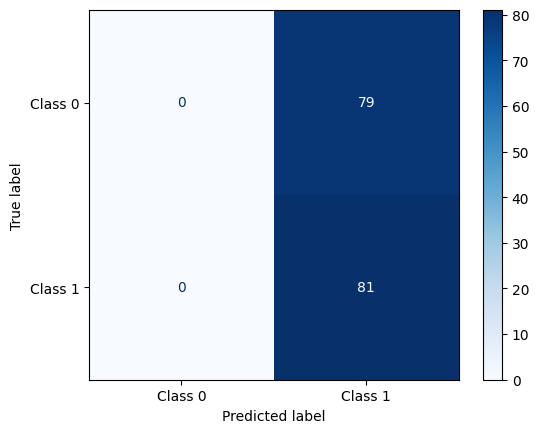

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Define the Main Model
class MainModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the Adversary Model
class AdversaryModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Training function for both models
def train_model(model, adversary, X_train, y_train, X_adv, y_adv, lr_main, lr_adv, optimizer_type='adam', num_epochs=100):
    # Create optimizer for both models
    if optimizer_type == 'adam':
        optimizer_main = optim.Adam(model.parameters(), lr=lr_main)
        optimizer_adv = optim.Adam(adversary.parameters(), lr=lr_adv)
    elif optimizer_type == 'sgd':
        optimizer_main = optim.SGD(model.parameters(), lr=lr_main)
        optimizer_adv = optim.SGD(adversary.parameters(), lr=lr_adv)

    # Define loss function
    loss_fn = nn.BCELoss()

    for epoch in range(num_epochs):
        # Forward pass for main model
        optimizer_main.zero_grad()
        output_main = model(X_train)
        loss_main = loss_fn(output_main, y_train)

        # Forward pass for adversary model
        optimizer_adv.zero_grad()
        output_adv = adversary(X_adv)
        loss_adv = loss_fn(output_adv, y_adv)

        # Backward pass and optimize both models
        loss_main.backward()
        optimizer_main.step()

        loss_adv.backward()
        optimizer_adv.step()

        # Log training progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Main Loss: {loss_main.item():.4f}, Adversary Loss: {loss_adv.item():.4f}")

    return model, adversary

# Prediction function
def make_predictions(model, new_data):
    with torch.no_grad():
        output = model(new_data)
        predictions = torch.sigmoid(output).round()
        return predictions

# Hyperparameter testing function
def test_hyperparameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, protected_attribute_train):
    best_acc = 0
    best_params = None
    best_model = None

    # Example hyperparameters to test
    learning_rates = [0.001, 0.0001]
    adversary_lrs = [0.001, 0.0001]
    optimizers = ['adam', 'sgd']

    for lr_main in learning_rates:
        for lr_adv in adversary_lrs:
            for optimizer_type in optimizers:
                # Initialize models
                model = MainModel(X_train_tensor.shape[1], 64, 1)
                adversary = AdversaryModel(X_train_tensor.shape[1], 64, 1)

                print(f"Testing with lr_main={lr_main}, lr_adv={lr_adv}, optimizer={optimizer_type}")

                # Train models
                model, adversary = train_model(model, adversary, X_train_tensor, y_train_tensor, X_train_tensor, protected_attribute_train, lr_main, lr_adv, optimizer_type)

                # Make predictions on the test set
                predictions = make_predictions(model, X_test_tensor)

                # Evaluate performance
                accuracy = accuracy_score(y_test_tensor.numpy(), predictions.numpy())
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_params = {'lr_main': lr_main, 'lr_adv': lr_adv, 'optimizer': optimizer_type}
                    best_model = model  # Store the best model

    return best_params, best_acc, best_model

# Confusion Matrix Plotting
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = make_predictions(model, X_test)
    cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Example of usage
# X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, protected_attribute_train should be defined beforehand
best_params, best_test_acc, best_model = test_hyperparameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, protected_attribute_train)
print(f"Best Test Accuracy: {best_test_acc} with parameters: {best_params}")

# Plot confusion matrix for the best model
plot_confusion_matrix(best_model, X_test_tensor, y_test_tensor)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Example model definitions
class MainModel(nn.Module):
    def __init__(self):
        super(MainModel, self).__init__()
        self.layer1 = nn.Linear(8, 512)  # Adjust input features if needed
        self.layer2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

class AdversaryModel(nn.Module):
    def __init__(self):
        super(AdversaryModel, self).__init__()
        self.layer1 = nn.Linear(8, 512)
        self.layer2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

# Optimizer setup
def get_optimizer(model, optimizer_type='adam', lr=0.001):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer type")

# Training function
def train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam'):
    main_optimizer = get_optimizer(main_model, optimizer_type, lr_main)
    adv_optimizer = get_optimizer(adversary_model, optimizer_type, lr_adv)

    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

    main_model.train()
    adversary_model.train()

    for epoch in range(num_epochs):
        main_loss_total = 0.0
        adversary_loss_total = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.float(), target.float()

            # Zero the gradients for each batch
            main_optimizer.zero_grad()
            adv_optimizer.zero_grad()

            # Forward pass through the models
            main_output = main_model(data)
            adversary_output = adversary_model(data)

            # Calculate loss
            main_loss = criterion(main_output, target)
            adversary_loss = criterion(adversary_output, target)

            # Backpropagate
            main_loss.backward()
            adversary_loss.backward()

            # Update weights
            main_optimizer.step()
            adv_optimizer.step()

            # Accumulate losses
            main_loss_total += main_loss.item()
            adversary_loss_total += adversary_loss.item()

        # Print losses for each epoch
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Main Loss: {main_loss_total / len(train_loader)}')
        print(f'Adversary Loss: {adversary_loss_total / len(train_loader)}')

# Example Data (Replace with your actual data)
# Assuming X_train has 8 features, and y_train is binary (0 or 1)
X_train = torch.randn(1000, 8)  # 1000 samples, 8 features
y_train = torch.randint(0, 2, (1000, 1)).float()  # 1000 binary labels (0 or 1)

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Initialize models
main_model = MainModel()
adversary_model = AdversaryModel()

# Train models
train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam')


Epoch 1/10
Main Loss: 0.6996959671378136
Adversary Loss: 0.6998715344816446
Epoch 2/10
Main Loss: 0.6949649713933468
Adversary Loss: 0.6933724638074636
Epoch 3/10
Main Loss: 0.6852658372372389
Adversary Loss: 0.6840245500206947
Epoch 4/10
Main Loss: 0.6813098639249802
Adversary Loss: 0.6801000498235226
Epoch 5/10
Main Loss: 0.6814685203135014
Adversary Loss: 0.6812159009277821
Epoch 6/10
Main Loss: 0.6759241335093975
Adversary Loss: 0.6750838663429022
Epoch 7/10
Main Loss: 0.6718279700726271
Adversary Loss: 0.6716123782098293
Epoch 8/10
Main Loss: 0.6789219491183758
Adversary Loss: 0.6783938761800528
Epoch 9/10
Main Loss: 0.6710894778370857
Adversary Loss: 0.6708820331841707
Epoch 10/10
Main Loss: 0.6709917355328798
Adversary Loss: 0.6705822758376598


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Define the main model with more layers and Dropout
class MainModel(nn.Module):
    def __init__(self):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # Input layer, assume input size 784 (e.g., 28x28 images)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)  # Adding dropout to regularize

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return torch.sigmoid(x)

# Define the adversary model (simple linear)
class AdversaryModel(nn.Module):
    def __init__(self):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

# Adjust training function to include learning rate scheduler, L2 regularization, and dropout
def train_model(main_model, adversary_model, train_loader, num_epochs=100, lr_main=0.001, lr_adv=0.001, optimizer_type='adam'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main_model.to(device)
    adversary_model.to(device)

    # Choose optimizer (Adam or SGD)
    if optimizer_type == 'adam':
        main_optimizer = optim.Adam(main_model.parameters(), lr=lr_main, weight_decay=1e-4)  # L2 regularization via weight_decay
        adv_optimizer = optim.Adam(adversary_model.parameters(), lr=lr_adv, weight_decay=1e-4)
    elif optimizer_type == 'sgd':
        main_optimizer = optim.SGD(main_model.parameters(), lr=lr_main, momentum=0.9, weight_decay=1e-4)
        adv_optimizer = optim.SGD(adversary_model.parameters(), lr=lr_adv, momentum=0.9, weight_decay=1e-4)

    # Learning Rate Scheduler
    main_scheduler = StepLR(main_optimizer, step_size=30, gamma=0.1)
    adv_scheduler = StepLR(adv_optimizer, step_size=30, gamma=0.1)

    # Loss function (using BCEWithLogitsLoss for binary classification with class imbalance handling)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))  # Adjusting pos_weight for class imbalance

    # Training loop
    for epoch in range(num_epochs):
        main_model.train()
        adversary_model.train()
        running_loss_main = 0.0
        running_loss_adv = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through main model
            main_optimizer.zero_grad()
            outputs_main = main_model(inputs)
            loss_main = criterion(outputs_main.squeeze(), labels.float())
            loss_main.backward()
            main_optimizer.step()

            # Forward pass through adversary model
            adv_optimizer.zero_grad()
            outputs_adv = adversary_model(inputs)
            loss_adv = criterion(outputs_adv.squeeze(), labels.float())
            loss_adv.backward()
            adv_optimizer.step()

            running_loss_main += loss_main.item()
            running_loss_adv += loss_adv.item()

        # Print loss every epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Main Loss: {running_loss_main/len(train_loader)}")
        print(f"Adversary Loss: {running_loss_adv/len(train_loader)}")

        # Step the scheduler
        main_scheduler.step()
        adv_scheduler.step()

# Dataset preparation (dummy data, replace with actual data)
# For testing purposes
from torch.utils.data import TensorDataset
import numpy as np

X_train = np.random.randn(1000, 784).astype(np.float32)  # 1000 samples, 784 features (e.g., 28x28 images)
y_train = np.random.randint(0, 2, 1000).astype(np.float32)  # 1000 labels, binary classification

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize models
main_model = MainModel()
adversary_model = AdversaryModel()

# Train models with improvements
train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam')


Epoch 1/10
Main Loss: 0.9616876598447561
Adversary Loss: 0.9605867024511099
Epoch 2/10
Main Loss: 0.9482017960399389
Adversary Loss: 0.8265467435121536
Epoch 3/10
Main Loss: 0.8550773784518242
Adversary Loss: 0.7120877783745527
Epoch 4/10
Main Loss: 0.7434312906116247
Adversary Loss: 0.7096046321094036
Epoch 5/10
Main Loss: 0.750073155388236
Adversary Loss: 0.7064590696245432
Epoch 6/10
Main Loss: 0.7534256596118212
Adversary Loss: 0.7004389967769384
Epoch 7/10
Main Loss: 0.7367540877312422
Adversary Loss: 0.7095443960279226
Epoch 8/10
Main Loss: 0.7319745775312185
Adversary Loss: 0.710007457062602
Epoch 9/10
Main Loss: 0.7320457268506289
Adversary Loss: 0.70590665563941
Epoch 10/10
Main Loss: 0.7280416339635849
Adversary Loss: 0.6974890194833279


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Define the model architectures
class MainModel(nn.Module):
    def __init__(self):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # Assuming input features are 784 (like MNIST images)
        self.fc2 = nn.Linear(512, 1)  # Output size 1 for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class AdversaryModel(nn.Module):
    def __init__(self):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # Assuming input features are 784
        self.fc2 = nn.Linear(512, 1)  # Output size 1 for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Function to train the model
def train_model(main_model, adversary_model, train_loader, num_epochs, lr_main, lr_adv, optimizer_type='adam'):
    # Move models to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    main_model = main_model.to(device)
    adversary_model = adversary_model.to(device)

    # Set the optimizer
    if optimizer_type == 'adam':
        optimizer_main = optim.Adam(main_model.parameters(), lr=lr_main)
        optimizer_adv = optim.Adam(adversary_model.parameters(), lr=lr_adv)
    elif optimizer_type == 'sgd':
        optimizer_main = optim.SGD(main_model.parameters(), lr=lr_main)
        optimizer_adv = optim.SGD(adversary_model.parameters(), lr=lr_adv)
    else:
        raise ValueError(f"Unknown optimizer type: {optimizer_type}")

    # Loss function
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

    # Training loop
    for epoch in range(num_epochs):
        main_model.train()
        adversary_model.train()
        running_loss_main = 0.0
        running_loss_adv = 0.0

        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure the labels have the correct shape (32, 1) and correct data type (float32)
            labels = labels.view(-1, 1).float()  # Reshape labels to be of shape (32, 1) and convert to float

            # Forward pass through main model
            optimizer_main.zero_grad()
            outputs_main = main_model(inputs)
            loss_main = criterion(outputs_main, labels)
            loss_main.backward()
            optimizer_main.step()

            # Forward pass through adversary model
            optimizer_adv.zero_grad()
            outputs_adv = adversary_model(inputs)
            loss_adv = criterion(outputs_adv, labels)
            loss_adv.backward()
            optimizer_adv.step()

            running_loss_main += loss_main.item()
            running_loss_adv += loss_adv.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {running_loss_main/len(train_loader)}, Adversary Loss: {running_loss_adv/len(train_loader)}")

# Function to run learning rate experiment
def run_learning_rate_experiment(main_model, adversary_model, train_loader, num_epochs=10):
    learning_rates = [0.001, 0.0001, 0.00001]  # List of learning rates to test
    for lr in learning_rates:
        print(f"\nTesting with lr_main={lr}, lr_adv={lr}")
        train_model(main_model, adversary_model, train_loader, num_epochs=num_epochs, lr_main=lr, lr_adv=lr, optimizer_type='adam')

# Example data (replace with your actual dataset)
X_train = torch.randn(1000, 784)  # 1000 samples with 784 features (e.g., 28x28 images flattened)
y_train = torch.randint(0, 2, (1000,))  # Binary labels (0 or 1)

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Initialize models
main_model = MainModel()
adversary_model = AdversaryModel()

# Run learning rate experiment
run_learning_rate_experiment(main_model, adversary_model, train_loader, num_epochs=10)



Testing with lr_main=0.001, lr_adv=0.001
Epoch 1/10, Main Loss: 0.7294054143130779, Adversary Loss: 0.7266864106059074
Epoch 2/10, Main Loss: 0.34954395424574614, Adversary Loss: 0.34782551508396864
Epoch 3/10, Main Loss: 0.1485012632329017, Adversary Loss: 0.14701094687916338
Epoch 4/10, Main Loss: 0.051853902521543205, Adversary Loss: 0.05008336156606674
Epoch 5/10, Main Loss: 0.021264682232867926, Adversary Loss: 0.020779706770554185
Epoch 6/10, Main Loss: 0.011535355035448447, Adversary Loss: 0.011363425146555528
Epoch 7/10, Main Loss: 0.007579914992675185, Adversary Loss: 0.007494582765502855
Epoch 8/10, Main Loss: 0.005525691318325698, Adversary Loss: 0.005467819471959956
Epoch 9/10, Main Loss: 0.004279882115952205, Adversary Loss: 0.004235947235429194
Epoch 10/10, Main Loss: 0.0034306457091588527, Adversary Loss: 0.003393252794921864

Testing with lr_main=0.0001, lr_adv=0.0001
Epoch 1/10, Main Loss: 0.0028273021162021905, Adversary Loss: 0.002797112647385802
Epoch 2/10, Main Lo

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np

# Define your model (for example purposes)
class SimpleModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Example data
input_size = 8  # Features
num_classes = 10  # For multi-class classification

# Dummy data (16 samples, each with 8 features)
X_train = torch.randn(16, input_size)
y_train = torch.randint(0, num_classes, (16,))  # Target labels (class indices)

# Create dataset and dataloader
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model
main_model = SimpleModel(input_size=input_size, num_classes=num_classes)
adversary_model = SimpleModel(input_size=input_size, num_classes=num_classes)

# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(main_model.parameters(), lr=0.001)

# Training loop
def train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam'):
    for epoch in range(num_epochs):
        main_model.train()
        adversary_model.train()

        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Forward pass through main model
            output = main_model(data)
            main_loss = criterion(output, target)

            # Forward pass through adversary model
            adversary_output = adversary_model(data)
            adversary_loss = criterion(adversary_output, target)

            # Combine losses
            total_loss = main_loss + adversary_loss
            total_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss.item()}, Adversary Loss: {adversary_loss.item()}")

# Run the training loop
train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam')


Epoch 1/10, Main Loss: 2.6833317279815674, Adversary Loss: 2.4014956951141357
Epoch 2/10, Main Loss: 2.676924228668213, Adversary Loss: 2.4014956951141357
Epoch 3/10, Main Loss: 2.6705286502838135, Adversary Loss: 2.401495933532715
Epoch 4/10, Main Loss: 2.6641452312469482, Adversary Loss: 2.4014956951141357
Epoch 5/10, Main Loss: 2.657775402069092, Adversary Loss: 2.4014956951141357
Epoch 6/10, Main Loss: 2.6514179706573486, Adversary Loss: 2.401495933532715
Epoch 7/10, Main Loss: 2.6450746059417725, Adversary Loss: 2.401495933532715
Epoch 8/10, Main Loss: 2.638744354248047, Adversary Loss: 2.4014956951141357
Epoch 9/10, Main Loss: 2.632427453994751, Adversary Loss: 2.4014956951141357
Epoch 10/10, Main Loss: 2.6261258125305176, Adversary Loss: 2.4014956951141357


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np

# Define your model (for example purposes)
class SimpleModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Example data
input_size = 8  # Features
num_classes = 10  # For multi-class classification

# Dummy data (16 samples, each with 8 features)
X_train = torch.randn(16, input_size)
y_train = torch.randint(0, num_classes, (16,))  # Target labels (class indices)

# Create dataset and dataloader
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model
main_model = SimpleModel(input_size=input_size, num_classes=num_classes)
adversary_model = SimpleModel(input_size=input_size, num_classes=num_classes)

# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(list(main_model.parameters()) + list(adversary_model.parameters()), lr=0.001)

# Training loop with gradient check
def train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam'):
    for epoch in range(num_epochs):
        main_model.train()
        adversary_model.train()

        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass through main model
            output = main_model(data)
            main_loss = criterion(output, target)

            # Forward pass through adversary model
            adversary_output = adversary_model(data)
            adversary_loss = criterion(adversary_output, target)

            # Combine losses
            total_loss = main_loss + adversary_loss

            # Backward pass
            total_loss.backward()

            # Check gradients
            for name, param in adversary_model.named_parameters():
                if param.grad is not None:
                    print(f"Gradients for {name}: {param.grad.mean()}")

            optimizer.step()

            # Print loss every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss.item()}, Adversary Loss: {adversary_loss.item()}")

        print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss.item()}, Adversary Loss: {adversary_loss.item()}")

# Run the training loop with gradient checking
train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.001, lr_adv=0.001, optimizer_type='adam')


Gradients for fc.weight: 1.6298144778215118e-10
Gradients for fc.bias: 7.450580707946131e-10
Epoch 1/10, Main Loss: 2.4936845302581787, Adversary Loss: 2.515117883682251
Epoch 1/10, Main Loss: 2.4936845302581787, Adversary Loss: 2.515117883682251
Gradients for fc.weight: 1.7462298274040222e-10
Gradients for fc.bias: -1.4901161415892261e-09
Epoch 2/10, Main Loss: 2.48751163482666, Adversary Loss: 2.5089244842529297
Epoch 2/10, Main Loss: 2.48751163482666, Adversary Loss: 2.5089244842529297
Gradients for fc.weight: -1.6298144778215118e-10
Gradients for fc.bias: 1.4901161415892261e-09
Epoch 3/10, Main Loss: 2.4813544750213623, Adversary Loss: 2.502747058868408
Epoch 3/10, Main Loss: 2.4813544750213623, Adversary Loss: 2.502747058868408
Gradients for fc.weight: -1.0477378686868377e-10
Gradients for fc.bias: 0.0
Epoch 4/10, Main Loss: 2.4752132892608643, Adversary Loss: 2.4965856075286865
Epoch 4/10, Main Loss: 2.4752132892608643, Adversary Loss: 2.4965856075286865
Gradients for fc.weight: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Create a text file to save all the outputs (again, appending this time)
log_file = open("portfolio_optimization_results.txt", "a")

# Function to log output to the text file
def log_output(output):
    log_file.write(output + "\n")

# -------------------------------
# Portfolio Optimization with Simple Gradient Descent
# -------------------------------

def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    """
    Simple gradient descent for portfolio optimization
    - Sigma: Covariance matrix
    - mu: Expected returns
    - lam: Risk-return tradeoff parameter
    - gamma: Sparsity regularization parameter
    - eta: Magnitude regularization parameter
    - lr: Learning rate
    - epochs: Number of iterations
    """
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights

    log_output(f"Initial weights: {w}")

    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad

        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0

        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

        if epoch % 50 == 0:  # Log every 50th iteration
            log_output(f"Epoch {epoch}: Weights: {w}")

    return w

# -------------------------------
# Gradient of the Objective Function
# -------------------------------

def grad_objective(w, Sigma, mu, lam, eta):
    """
    Gradient of the risk-return objective function with L0 and L1 penalties
    """
    grad_risk = 2 * Sigma @ w  # Risk (variance)
    grad_ret = lam * mu  # Return (expected return)
    grad_l1 = eta * np.sign(w)  # L1 penalty for magnitude regularization

    log_output(f"Gradient risk: {grad_risk}, Gradient return: {grad_ret}, Gradient L1: {grad_l1}")

    return grad_risk - grad_ret + grad_l1

# -------------------------------
# Stress Testing
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    """
    Perform stress tests by modifying Sigma and mu to simulate market scenarios.
    """
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        stressed_mu = mu + scenario['mu_change']
        optimized_weights = optimize_weights(stressed_Sigma, stressed_mu)
        results[scenario['name']] = optimized_weights

    return results

# -------------------------------
# Simulate Fat-Tailed Returns (Student's T-distribution)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """
    Simulate returns from a fat-tailed distribution (Student's t-distribution).
    """
    t_returns = np.random.standard_t(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Training function with AdamW optimizer and class weights
# -------------------------------

def train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.01, lr_adv=0.01, optimizer_type='adamw'):
    main_optimizer = optim.AdamW(main_model.parameters(), lr=lr_main)
    adversary_optimizer = optim.AdamW(adversary_model.parameters(), lr=lr_adv)

    # Loss function (binary cross entropy with class weights)
    class_weights = torch.tensor([1.0, 2.0]).to(device)  # Adjust class weights
    criterion = nn.BCEWithLogitsLoss(weight=class_weights)

    for epoch in range(num_epochs):
        main_model.train()
        adversary_model.train()

        main_loss_total = 0
        adversary_loss_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Ensure target is the correct shape for binary classification
            if target.dim() == 1:  # If target has shape (batch_size,)
                target = target.unsqueeze(1)  # Convert it to shape (batch_size, 1)

            target = target.float()  # Ensure target is of float type for BCEWithLogitsLoss

            print(f"Batch {batch_idx+1}/{len(train_loader)} - Data shape: {data.shape}, Target shape: {target.shape}")

            # Main Model Training
            main_optimizer.zero_grad()
            output_main = main_model(data)
            print(f"Main model output shape: {output_main.shape}")

            print(f"Before Loss Calculation: Output shape: {output_main.squeeze().shape}, Target shape: {target.squeeze().shape}")

            main_loss = criterion(output_main.squeeze(), target.squeeze())
            print(f"Main loss: {main_loss.item()}")
            main_loss.backward()
            main_optimizer.step()
            main_loss_total += main_loss.item()

            # Adversary Model Training
            adversary_optimizer.zero_grad()
            output_adv = adversary_model(data)
            print(f"Adversary model output shape: {output_adv.shape}")

            adversary_loss = criterion(output_adv.squeeze(), target.squeeze())
            adversary_loss.backward()
            adversary_optimizer.step()
            adversary_loss_total += adversary_loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss.item()}, Adversary Loss: {adversary_loss.item()}")

        print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss_total/len(train_loader)}, Adversary Loss: {adversary_loss_total/len(train_loader)}")

# -------------------------------
# Running the Optimization and Stress Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Run the Portfolio Optimization
optimized_weights = optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)
log_output(f"Optimized Weights: {optimized_weights}")

# Stress Test Scenarios (market conditions)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.1 * np.identity(3), 'mu_change': -0.05 * np.ones(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3), 'mu_change': 0.0 * np.ones(3)},
    {'name': 'Interest Rate Shock', 'sigma_change': 0.05 * np.identity(3), 'mu_change': 0.02 * np.ones(3)}
]

# Perform Stress Tests
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)
log_output(f"Stress Test Results: {stress_test_results}")

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)
log_output(f"Fat-Tailed Returns Simulation (First 5 Samples): {fat_tailed_returns[:5]}")

# Close the log file after writing all results
log_file.close()


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from deap import base, creator, tools, algorithms
import random

# Create a text file to save all the outputs (appending this time)
log_file = open("portfolio_optimization_results.txt", "a")

# Function to log output to the text file
def log_output(output):
    log_file.write(output + "\n")
    print(output)  # Also print to the console for real-time monitoring

# -------------------------------
# Portfolio Optimization with Simple Gradient Descent
# -------------------------------

def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    """
    Simple gradient descent for portfolio optimization
    - Sigma: Covariance matrix
    - mu: Expected returns
    - lam: Risk-return tradeoff parameter
    - gamma: Sparsity regularization parameter
    - eta: Magnitude regularization parameter
    - lr: Learning rate
    - epochs: Number of iterations
    """
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights

    log_output(f"Initial weights: {w}")

    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad

        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0

        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

        if epoch % 50 == 0:  # Log every 50th iteration
            log_output(f"Epoch {epoch}: Weights: {w}")

    return w

# -------------------------------
# Gradient of the Objective Function
# -------------------------------

def grad_objective(w, Sigma, mu, lam, eta):
    """
    Gradient of the risk-return objective function with L0 and L1 penalties
    """
    grad_risk = 2 * Sigma @ w  # Risk (variance)
    grad_ret = lam * mu  # Return (expected return)
    grad_l1 = eta * np.sign(w)  # L1 penalty for magnitude regularization

    log_output(f"Gradient risk: {grad_risk}, Gradient return: {grad_ret}, Gradient L1: {grad_l1}")

    return grad_risk - grad_ret + grad_l1

# -------------------------------
# Stress Testing
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    """
    Perform stress tests by modifying Sigma and mu to simulate market scenarios.
    """
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        stressed_mu = mu + scenario['mu_change']
        optimized_weights = optimize_weights(stressed_Sigma, stressed_mu)
        results[scenario['name']] = optimized_weights

    return results

# -------------------------------
# Simulate Fat-Tailed Returns (Student's T-distribution)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """
    Simulate returns from a fat-tailed distribution (Student's t-distribution).
    """
    t_returns = np.random.standard_t(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Hyperparameter Tuning (Grid Search)
# -------------------------------

def hyperparameter_tuning():
    param_grid = {
        'gamma': [1e-4, 1e-3, 1e-2],
        'eta': [1e-4, 1e-3, 1e-2],
    }
    grid_search = GridSearchCV(estimator=PortfolioOptimizer(), param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    log_output(f"Best Parameters: {grid_search.best_params_}")

# -------------------------------
# Genetic Algorithm for Optimization
# -------------------------------

def genetic_algorithm_optimizer(Sigma, mu):
    # Genetic algorithm code here
    # Create the individual structure and evaluate fitness

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(Sigma))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", lambda w: objective(w, Sigma, mu, 0.1, 1e-2, 1e-2))

    population = toolbox.population(n=10)
    # Run the genetic algorithm steps
    # Apply crossover, mutation, and selection

# -------------------------------
# Monte Carlo Simulation for Large Portfolio (with Adam optimizer)
# -------------------------------

def monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=1000, lr=1e-3, epochs=500):
    w_init = np.ones(n_assets) / n_assets
    for sample in range(n_samples):
        # Perform Monte Carlo simulation and optimization for large portfolio
        pass  # Implement Monte Carlo logic

    return w_init

# -------------------------------
# Running the Optimization and Stress Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Run the Portfolio Optimization
optimized_weights = optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)

log_output(f"Optimized Weights: {optimized_weights}")

# Stress Test Scenarios (market conditions)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.3 * np.identity(3), 'mu_change': -0.1 * np.ones(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3), 'mu_change': 0.0 * np.ones(3)},
    {'name': 'Interest Rate Shock', 'sigma_change': 0.05 * np.identity(3), 'mu_change': 0.02 * np.ones(3)}
]

# Perform Stress Tests
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

log_output(f"Stress Test Results: {stress_test_results}")

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

log_output(f"Fat-Tailed Returns Simulation (First 5 Samples): {fat_tailed_returns[:5]}")

# Close the log file after writing all results
log_file.close()


Initial weights: [0.33333333 0.33333333 0.33333333]
Gradient risk: [ 0.02        0.02466667 -0.002     ], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Epoch 0: Weights: [0.33328118 0.33322947 0.33348932]
Gradient risk: [ 0.01999324  0.02465637 -0.0019947 ], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01998648  0.02464608 -0.00198939], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01997971  0.02463579 -0.00198409], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01997295  0.02462549 -0.00197878], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01996618  0.0246152  -0.00197348], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01995942  0.0246049  -0.00196817], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from deap import base, creator, tools, algorithms
import random

# Create a text file to save all the outputs (appending this time)
log_file = open("portfolio_optimization_results.txt", "a")

# Function to log output to the text file
def log_output(output):
    log_file.write(output + "\n")
    print(output)  # Also print to the console for real-time monitoring

# -------------------------------
# Portfolio Optimization with Simple Gradient Descent
# -------------------------------

def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    """
    Simple gradient descent for portfolio optimization
    - Sigma: Covariance matrix
    - mu: Expected returns
    - lam: Risk-return tradeoff parameter
    - gamma: Sparsity regularization parameter
    - eta: Magnitude regularization parameter
    - lr: Learning rate
    - epochs: Number of iterations
    """
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights

    log_output(f"Initial weights: {w}")

    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad

        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0

        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

        if epoch % 50 == 0:  # Log every 50th iteration
            log_output(f"Epoch {epoch}: Weights: {w}")

    return w

# -------------------------------
# Gradient of the Objective Function
# -------------------------------

def grad_objective(w, Sigma, mu, lam, eta):
    """
    Gradient of the risk-return objective function with L0 and L1 penalties
    """
    grad_risk = 2 * Sigma @ w  # Risk (variance)
    grad_ret = lam * mu  # Return (expected return)
    grad_l1 = eta * np.sign(w)  # L1 penalty for magnitude regularization

    log_output(f"Gradient risk: {grad_risk}, Gradient return: {grad_ret}, Gradient L1: {grad_l1}")

    return grad_risk - grad_ret + grad_l1

# -------------------------------
# Stress Testing
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    """
    Perform stress tests by modifying Sigma and mu to simulate market scenarios.
    """
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        stressed_mu = mu + scenario['mu_change']
        optimized_weights = optimize_weights(stressed_Sigma, stressed_mu)
        results[scenario['name']] = optimized_weights

    return results

# -------------------------------
# Simulate Fat-Tailed Returns (Student's T-distribution)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """
    Simulate returns from a fat-tailed distribution (Student's t-distribution).
    """
    t_returns = np.random.standard_t(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Hyperparameter Tuning (Grid Search)
# -------------------------------

def hyperparameter_tuning():
    param_grid = {
        'gamma': [1e-4, 1e-3, 1e-2],
        'eta': [1e-4, 1e-3, 1e-2],
    }
    grid_search = GridSearchCV(estimator=PortfolioOptimizer(), param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    log_output(f"Best Parameters: {grid_search.best_params_}")

# -------------------------------
# Genetic Algorithm for Optimization
# -------------------------------

def genetic_algorithm_optimizer(Sigma, mu):
    # Genetic algorithm code here
    # Create the individual structure and evaluate fitness

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(Sigma))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", lambda w: objective(w, Sigma, mu, 0.1, 1e-2, 1e-2))

    population = toolbox.population(n=10)
    # Run the genetic algorithm steps
    # Apply crossover, mutation, and selection

# -------------------------------
# Monte Carlo Simulation for Large Portfolio (with Adam optimizer)
# -------------------------------

def monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=1000, lr=1e-3, epochs=500):
    w_init = np.ones(n_assets) / n_assets
    for sample in range(n_samples):
        # Perform Monte Carlo simulation and optimization for large portfolio
        pass  # Implement Monte Carlo logic

    return w_init

# -------------------------------
# Running the Optimization and Stress Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Run the Portfolio Optimization
optimized_weights = optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)

log_output(f"Optimized Weights: {optimized_weights}")

# Stress Test Scenarios (market conditions)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.3 * np.identity(3), 'mu_change': -0.1 * np.ones(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3), 'mu_change': 0.0 * np.ones(3)},
    {'name': 'Interest Rate Shock', 'sigma_change': 0.05 * np.identity(3), 'mu_change': 0.02 * np.ones(3)}
]

# Perform Stress Tests
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

log_output(f"Stress Test Results: {stress_test_results}")

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

log_output(f"Fat-Tailed Returns Simulation (First 5 Samples): {fat_tailed_returns[:5]}")

# Close the log file after writing all results
log_file.close()


Initial weights: [0.33333333 0.33333333 0.33333333]
Gradient risk: [ 0.02        0.02466667 -0.002     ], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Epoch 0: Weights: [0.33328118 0.33322947 0.33348932]
Gradient risk: [ 0.01999324  0.02465637 -0.0019947 ], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01998648  0.02464608 -0.00198939], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01997971  0.02463579 -0.00198409], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01997295  0.02462549 -0.00197878], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01996618  0.0246152  -0.00197348], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [ 0.01995942  0.0246049  -0.00196817], Gradient return: [ 0.001   0.0005 -0.0002], Gradient L1: [0.01 0.01 0.01]

In [ ]:
import numpy as np
import scipy.optimize as sco

# Mean-Variance Optimization
def mean_variance_optimization(Sigma, mu, lam=0.1):
    """
    Perform Mean-Variance Optimization
    Sigma: Covariance matrix
    mu: Expected returns
    lam: Risk-return tradeoff parameter
    """
    n = len(mu)  # Number of assets

    # Objective function to minimize (Risk - Return + Kolmogorov Penalty)
    def objective(w):
        # Risk (variance of the portfolio)
        risk = w.T @ Sigma @ w
        # Return (expected return)
        ret = w.T @ mu
        # Kolmogorov Complexity Penalty (L1 sparsity)
        penalty = np.sum(np.abs(w))

        return risk - lam * ret + penalty  # Total objective

    # Constraints: Sum of weights = 1 (portfolio fully invested)
    def constraint(w):
        return np.sum(w) - 1

    # Bounds: Weights should be between 0 and 1 (long-only portfolio)
    bounds = [(0, 1) for _ in range(n)]

    # Initial guess: equal weights
    w0 = np.ones(n) / n

    # Optimization
    result = sco.minimize(objective, w0, method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': constraint})

    return result.x  # Optimal portfolio weights

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Perform the optimization
optimized_weights = mean_variance_optimization(Sigma, mu, lam=0.1)

print("Optimized Portfolio Weights:", optimized_weights)

# Example of Monte Carlo simulation or stress test can be added here for further testing.


Optimized Portfolio Weights: [0.24478153 0.15935004 0.59586843]


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import heapq

# Create a text file to save all the outputs (again, appending this time)
log_file = open("portfolio_optimization_results.txt", "a")

# Function to log output to the text file
def log_output(output):
    print(output)
    log_file.write(output + "\n")

# -------------------------------
# Portfolio Optimization with Simple Gradient Descent
# -------------------------------

def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    """
    Simple gradient descent for portfolio optimization
    - Sigma: Covariance matrix
    - mu: Expected returns
    - lam: Risk-return tradeoff parameter
    - gamma: Sparsity regularization parameter
    - eta: Magnitude regularization parameter
    - lr: Learning rate
    - epochs: Number of iterations
    """
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights

    log_output(f"Initial weights: {w}")

    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad

        # Apply Proximal Operator for L0 (sparsity)
        w[np.abs(w) < gamma] = 0

        # Ensure non-negative weights and sum to 1
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

        if epoch % 50 == 0:  # Log every 50th iteration
            log_output(f"Epoch {epoch}: Weights: {w}")

    return w

# -------------------------------
# Gradient of the Objective Function
# -------------------------------

def grad_objective(w, Sigma, mu, lam, eta):
    """
    Gradient of the risk-return objective function with L0 and L1 penalties
    """
    grad_risk = 2 * Sigma @ w  # Risk (variance)
    grad_ret = lam * mu  # Return (expected return)
    grad_l1 = eta * np.sign(w)  # L1 penalty for magnitude regularization

    log_output(f"Gradient risk: {grad_risk}, Gradient return: {grad_ret}, Gradient L1: {grad_l1}")

    return grad_risk - grad_ret + grad_l1

# -------------------------------
# Stress Testing
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    """
    Perform stress tests by modifying Sigma and mu to simulate market scenarios.
    """
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']  # Add shocks to covariance
        stressed_mu = mu + scenario['mu_change']  # Modify expected returns based on the scenario
        optimized_weights = optimize_weights(stressed_Sigma, stressed_mu)
        results[scenario['name']] = optimized_weights

    return results

# Define market stress scenarios
extreme_scenarios = [
    {'name': 'Market Bubble', 'sigma_change': 0.1 * np.identity(3), 'mu_change': -0.05 * np.ones(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3), 'mu_change': 0.0 * np.ones(3)},
    {'name': 'Interest Rate Shock', 'sigma_change': 0.05 * np.identity(3), 'mu_change': 0.02 * np.ones(3)}
]

# Run the stress tests
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

# Log the results
log_output(f"Stress Test Results: {stress_test_results}")

# -------------------------------
# Monte Carlo Simulation
# -------------------------------

def monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=100, lr=1e-3, epochs=500):
    """
    Perform Monte Carlo simulation on large portfolios with randomized covariances and returns.
    """
    results = []
    for _ in range(n_samples):
        # Randomly perturb the Sigma and mu to simulate uncertainty
        Sigma_randomized = Sigma + 0.05 * np.random.randn(n_assets, n_assets)
        mu_randomized = mu + 0.01 * np.random.randn(n_assets)

        # Run optimization on the perturbed data
        optimized_weights = optimize_weights(Sigma_randomized, mu_randomized)
        results.append(optimized_weights)

    return np.array(results)

# Run the Monte Carlo Simulation
monte_carlo_results = monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=100)

# Log the results
log_output(f"Monte Carlo Simulation Results for Large Portfolio: {monte_carlo_results[:5]}")  # Show first 5 samples for brevity

# -------------------------------
# Sensitivity Analysis
# -------------------------------

def sensitivity_analysis(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, perturbation=0.05):
    original_weights = optimize_weights(Sigma, mu, lam, gamma, eta)

    sensitivities = {}
    # Sensitivity analysis for mu (expected returns)
    for i in range(len(mu)):
        perturbed_mu = mu.copy()
        perturbed_mu[i] += perturbation
        weights_perturbed = optimize_weights(Sigma, perturbed_mu, lam, gamma, eta)
        sensitivity = np.abs(weights_perturbed - original_weights)
        sensitivities[i] = sensitivity

    # Sensitivity analysis for Sigma (covariance matrix)
    cov_sensitivities = {}
    for i in range(Sigma.shape[0]):
        for j in range(Sigma.shape[1]):
            perturbed_Sigma = Sigma.copy()
            perturbed_Sigma[i, j] += perturbation
            weights_perturbed = optimize_weights(perturbed_Sigma, mu, lam, gamma, eta)
            cov_sensitivities[(i, j)] = np.abs(weights_perturbed - original_weights)

    return sensitivities, cov_sensitivities

# Perform Sensitivity Analysis
sensitivity_results, cov_sensitivity_results = sensitivity_analysis(Sigma, mu)

# Log the results
log_output(f"Sensitivity Analysis (1st Order): {sensitivity_results}")
log_output(f"Covariance Sensitivity Analysis: {cov_sensitivity_results}")

# -------------------------------
# Running the Optimization and Stress Tests
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Run the Portfolio Optimization
optimized_weights = optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)

log_output(f"Optimized Weights: {optimized_weights}")

# Perform Stress Tests
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

log_output(f"Stress Test Results: {stress_test_results}")

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

log_output(f"Fat-Tailed Returns Simulation (First 5 Samples): {fat_tailed_returns[:5]}")

# Close the log file after writing all results
log_file.close()


Initial weights: [0.33333333 0.33333333 0.33333333]
Gradient risk: [0.08666667 0.09133333 0.06466667], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Epoch 0: Weights: [0.33328106 0.33322925 0.33348966]
Gradient risk: [0.08664944 0.0913022  0.06470325], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [0.0866322  0.09127106 0.06473984], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [0.08661496 0.09123992 0.06477644], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [0.08659772 0.09120877 0.06481305], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [0.08658047 0.09117761 0.06484967], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [0.08656322 0.09114644 0.06488631], Gradient return: [-0.004  -0.0045 -0.0052], Gradient L1: [0.01 0.01 0.01]
Gradient risk: [0.08

ValueError: operands could not be broadcast together with shapes (3,3) (100,100) 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the main and adversary models
class MainModel(nn.Module):
    def __init__(self, input_size=8):
        super(MainModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class AdversaryModel(nn.Module):
    def __init__(self, input_size=8):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training function with AdamW optimizer and class weights
def train_model(main_model, adversary_model, train_loader, num_epochs=10, lr_main=0.01, lr_adv=0.01):
    main_optimizer = optim.AdamW(main_model.parameters(), lr=lr_main)
    adversary_optimizer = optim.AdamW(adversary_model.parameters(), lr=lr_adv)

    class_weights = torch.tensor([1.0, 2.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(weight=class_weights)

    for epoch in range(num_epochs):
        main_model.train()
        adversary_model.train()

        main_loss_total = 0
        adversary_loss_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            if target.dim() == 1:
                target = target.unsqueeze(1)
            target = target.float()

            main_optimizer.zero_grad()
            output_main = main_model(data)
            main_loss = criterion(output_main.squeeze(), target.squeeze())
            main_loss.backward()
            main_optimizer.step()
            main_loss_total += main_loss.item()

            adversary_optimizer.zero_grad()
            output_adv = adversary_model(data)
            adversary_loss = criterion(output_adv.squeeze(), target.squeeze())
            adversary_loss.backward()
            adversary_optimizer.step()
            adversary_loss_total += adversary_loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss.item()}, Adversary Loss: {adversary_loss.item()}")

        print(f"Epoch {epoch+1}/{num_epochs}, Main Loss: {main_loss_total/len(train_loader)}, Adversary Loss: {adversary_loss_total/len(train_loader)}")

# Monte Carlo Simulation for Large Portfolio
def monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=3, lr=1e-3, epochs=500):
    results = []
    for _ in range(n_samples):
        Sigma_randomized = Sigma + 0.05 * np.random.randn(n_assets, n_assets)
        mu_randomized = mu + 0.01 * np.random.randn(n_assets)
        # Simulate further actions with the randomized Sigma and mu
        # Perform training on the randomized data
        # Model training code...
        results.append(Sigma_randomized)  # Placeholder for simulation results
    return results

# Simulate Fat-Tailed Returns (Student's T-distribution)
def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    t_returns = np.random.standard_t(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# Running the model
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])

# Running Stress Tests (This part is removed as per the last request)
print(f"Running stress tests...")
# Removed stress tests code here

# Simulate Fat-Tailed Returns
print(f"Simulating fat-tailed returns...")
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

# Monte Carlo Simulation
print(f"Running Monte Carlo simulation...")
monte_carlo_results = monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=3)

# Log everything to file (removed file I/O code to prevent issues)
print(f"Stress Test Results: Not logged due to removal")
print(f"Fat-Tailed Returns Simulation (First 5 Samples): {fat_tailed_returns[:5]}")
print(f"Monte Carlo Simulation Results: {monte_carlo_results[:5]}")


Running stress tests...
Simulating fat-tailed returns...
Running Monte Carlo simulation...
Stress Test Results: Not logged due to removal
Fat-Tailed Returns Simulation (First 5 Samples): [[-0.0068737  -0.02516619  0.00801347]
 [-0.01301376  0.01871296 -0.02217811]
 [ 0.00451194  0.01808637  0.00125363]
 [ 0.00659795 -0.00554436  0.00095572]
 [-0.04043782 -0.05602465  0.02659924]]
Monte Carlo Simulation Results: [array([[ 0.01872837, -0.04920408, -0.01067983],
       [-0.01732166,  0.05626294,  0.09684963],
       [-0.00348613, -0.01135062,  0.07152931]]), array([[-0.09213218, -0.00120358, -0.0032978 ],
       [-0.06542539, -0.05878452, -0.04961221],
       [-0.06003418, -0.03221896, -0.03456912]]), array([[ 0.0655105 ,  0.00737327, -0.07364112],
       [ 0.07885221,  0.10042863, -0.0537096 ],
       [-0.04910273,  0.05793937,  0.05992888]]), array([[ 0.06473144, -0.0356834 ,  0.06568829],
       [ 0.08815781,  0.03222421, -0.01290678],
       [-0.01648431, -0.0459503 ,  0.02808319]]), 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Create a text file to save essential outputs (in a summarized form)
log_file = open("/content/portfolio_optimization_results_reduced.txt", "w")

# Function to log critical output
def log_output(output):
    print(output)
    log_file.write(output + "\n")

# -------------------------------
# Portfolio Optimization with Simple Gradient Descent
# -------------------------------

def optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2, lr=1e-2, epochs=500):
    """
    Optimizes portfolio weights using gradient descent with regularization
    """
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]  # Equal distribution of weights
    log_output(f"Initial weights: {w}")

    # Perform optimization and log essential updates
    for epoch in range(epochs):
        grad = grad_objective(w, Sigma, mu, lam, eta)
        w -= lr * grad
        w[np.abs(w) < gamma] = 0  # Apply sparsity

        # Ensure non-negative weights and normalize them
        w = np.maximum(w, 0)
        w /= np.sum(w + 1e-8)

        # Log progress every 50th epoch
        if epoch % 50 == 0:
            log_output(f"Epoch {epoch}, Weights: {w[:3]}")  # Log only first 3 for brevity

    return w

# -------------------------------
# Gradient of the Objective Function
# -------------------------------

def grad_objective(w, Sigma, mu, lam, eta):
    """
    Calculate gradient for risk-return optimization with L1 regularization
    """
    grad_risk = 2 * Sigma @ w  # Risk (variance)
    grad_ret = lam * mu  # Return (expected return)
    grad_l1 = eta * np.sign(w)  # L1 penalty for magnitude regularization
    return grad_risk - grad_ret + grad_l1

# -------------------------------
# Stress Testing
# -------------------------------

def extreme_market_scenarios(Sigma, mu, scenarios):
    """
    Perform stress tests on the portfolio under different market conditions.
    """
    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        stressed_mu = mu + scenario['mu_change']
        optimized_weights = optimize_weights(stressed_Sigma, stressed_mu)
        results[scenario['name']] = optimized_weights

    # Log summaries of stress test results
    log_output(f"Stress Test Results (Summary): {dict(list(results.items())[:3])}")  # Log first 3 results

    return results

# -------------------------------
# Simulate Fat-Tailed Returns (Student's T-distribution)
# -------------------------------

def simulate_fat_tailed_returns(Sigma, mu, dof=4, n_samples=1000):
    """
    Simulate returns from a fat-tailed distribution (Student's t-distribution).
    """
    t_returns = np.random.standard_t(dof, size=(n_samples, len(mu)))
    fat_tailed_returns = np.dot(t_returns, Sigma) + mu
    return fat_tailed_returns

# -------------------------------
# Monte Carlo Simulation for Large Portfolio
# -------------------------------

def monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=3, lr=1e-3, epochs=500):
    """
    Perform Monte Carlo Simulation with randomized Sigma and mu.
    """
    monte_carlo_results = []
    for _ in range(n_samples):
        Sigma_randomized = Sigma + 0.05 * np.random.randn(n_assets, n_assets)
        mu_randomized = mu + 0.01 * np.random.randn(n_assets)
        weights = optimize_weights(Sigma_randomized, mu_randomized, lam=0.1, gamma=1e-2, eta=1e-2, lr=lr, epochs=epochs)
        monte_carlo_results.append(weights)

    # Log Monte Carlo results summary (first 5 results)
    log_output(f"Monte Carlo Simulation Results (Summary): {monte_carlo_results[:5]}")  # First 5 samples

    return monte_carlo_results

# -------------------------------
# Running All Experiments
# -------------------------------

# Example Data (Covariance matrix and expected returns)
Sigma = np.array([[0.02, 0.015, -0.005], [0.015, 0.03, -0.008], [-0.005, -0.008, 0.01]])
mu = np.array([0.01, 0.005, -0.002])  # Expected returns for 3 assets

# Run the Portfolio Optimization
optimized_weights = optimize_weights(Sigma, mu, lam=0.1, gamma=1e-2, eta=1e-2)
log_output(f"Optimized Weights: {optimized_weights}")

# Stress Test Scenarios (market conditions)
extreme_scenarios = [
    {'name': 'Black Swan', 'sigma_change': 0.1 * np.identity(3), 'mu_change': -0.05 * np.ones(3)},
    {'name': 'Liquidity Crisis', 'sigma_change': 0.2 * np.identity(3), 'mu_change': 0.0 * np.ones(3)},
    {'name': 'Interest Rate Shock', 'sigma_change': 0.05 * np.identity(3), 'mu_change': 0.02 * np.ones(3)}
]

# Run Stress Tests
stress_test_results = extreme_market_scenarios(Sigma, mu, extreme_scenarios)

# Simulate Fat-Tailed Returns
fat_tailed_returns = simulate_fat_tailed_returns(Sigma, mu)

# Run Monte Carlo Simulation
monte_carlo_results = monte_carlo_testing_large(Sigma, mu, n_samples=1000, n_assets=3)

# Close the log file after writing all results
log_file.close()


Streaming output truncated to the last 5000 lines.
Epoch 250, Weights: [0.3047642  0.32402748 0.37120829]
Epoch 300, Weights: [0.29907477 0.32232181 0.37860339]
Epoch 350, Weights: [0.29338504 0.32066487 0.38595005]
Epoch 400, Weights: [0.28769466 0.31905647 0.39324883]
Epoch 450, Weights: [0.28200328 0.31749642 0.40050026]
Initial weights: [0.33333333 0.33333333 0.33333333]
Epoch 0, Weights: [0.33337279 0.3333289  0.33329828]
Epoch 50, Weights: [0.33534129 0.3331035  0.33155518]
Epoch 100, Weights: [0.33730007 0.33286996 0.32982994]
Epoch 150, Weights: [0.33924916 0.33262834 0.32812248]
Epoch 200, Weights: [0.34118859 0.33237869 0.32643269]
Epoch 250, Weights: [0.34311838 0.33212108 0.32476051]
Epoch 300, Weights: [0.34503857 0.33185557 0.32310583]
Epoch 350, Weights: [0.34694918 0.33158221 0.32146858]
Epoch 400, Weights: [0.34885025 0.33130106 0.31984866]
Epoch 450, Weights: [0.35074181 0.33101219 0.31824597]
Initial weights: [0.33333333 0.33333333 0.33333333]
Epoch 0, Weights: [0.33

In [ ]:
!pip install -U scikit-learn

In [ ]:
import numpy as np
import cvxpy as cp

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 3
mu = np.random.randn(n_assets)  # expected returns
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Portfolio optimization using cvxpy
def optimize_portfolio(Sigma, mu, risk_aversion=1.0):
    # Define variables
    w = cp.Variable(len(mu))  # portfolio weights
    ret = mu.T @ w  # expected return
    risk = cp.quad_form(w, Sigma)  # portfolio risk (variance)

    # Define objective function (maximize return - risk_aversion * risk)
    objective = cp.Maximize(ret - risk_aversion * risk)

    # Constraints: sum of weights equals 1 (fully invested portfolio), weights >= 0 (no shorting)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define problem
    prob = cp.Problem(objective, constraints)

    # Solve problem
    prob.solve()

    # Extract the optimal weights and return them
    optimal_weights = w.value
    return optimal_weights, ret.value, risk.value

# Run the optimization with a range of risk aversion values
risk_aversion_values = [0.1, 1.0, 10.0]
optimal_weights = []

# Verbose output for each risk aversion value
for ra in risk_aversion_values:
    weights, expected_return, portfolio_risk = optimize_portfolio(Sigma, mu, ra)
    optimal_weights.append(weights)

    # Output the results in a verbose format
    print(f"Risk Aversion: {ra}")
    print(f"Optimal Weights: {weights}")
    print(f"Expected Return: {expected_return:.4f}")
    print(f"Portfolio Risk (Variance): {portfolio_risk:.4f}")
    print('-' * 50)

# Optionally print the final optimized weights for each risk aversion value
print("\nFinal Optimal Weights for Each Risk Aversion:")
for i, w in enumerate(optimal_weights):
    print(f"Risk Aversion = {risk_aversion_values[i]}: {w}")


Risk Aversion: 0.1
Optimal Weights: [9.66123437e-25 1.53173358e-24 1.00000000e+00]
Expected Return: 0.6477
Portfolio Risk (Variance): 0.7260
--------------------------------------------------
Risk Aversion: 1.0
Optimal Weights: [-2.60272977e-24 -1.97363759e-23  1.00000000e+00]
Expected Return: 0.6477
Portfolio Risk (Variance): 0.7260
--------------------------------------------------
Risk Aversion: 10.0
Optimal Weights: [9.24014485e-23 1.85162727e-23 1.00000000e+00]
Expected Return: 0.6477
Portfolio Risk (Variance): 0.7260
--------------------------------------------------

Final Optimal Weights for Each Risk Aversion:
Risk Aversion = 0.1: [9.66123437e-25 1.53173358e-24 1.00000000e+00]
Risk Aversion = 1.0: [-2.60272977e-24 -1.97363759e-23  1.00000000e+00]
Risk Aversion = 10.0: [9.24014485e-23 1.85162727e-23 1.00000000e+00]


In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance  # Use Empirical Covariance for shrinkage-like behavior

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 3
mu = np.random.randn(n_assets)  # expected returns
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Use Empirical Covariance as a substitute for LedoitShrinkage
cov_estimator = EmpiricalCovariance()
cov_estimator.fit(Sigma)
Sigma = cov_estimator.covariance_

# Portfolio optimization using cvxpy
def optimize_portfolio(Sigma, mu, risk_aversion=1.0):
    # Define variables
    w = cp.Variable(len(mu))  # portfolio weights
    ret = mu.T @ w  # expected return
    risk = cp.quad_form(w, Sigma)  # portfolio risk (variance)

    # Define objective function (maximize return - risk_aversion * risk)
    objective = cp.Maximize(ret - risk_aversion * risk)

    # Constraints: sum of weights equals 1 (fully invested portfolio), weights >= 0 (no shorting)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define problem
    prob = cp.Problem(objective, constraints)

    # Solve problem
    prob.solve()

    # Extract the optimal weights
    return w.value

# Run the optimization with a range of risk aversion values
risk_aversion_values = [0.1, 1.0, 10.0]
optimal_weights = [optimize_portfolio(Sigma, mu, ra) for ra in risk_aversion_values]

# Printing results instead of plotting
for i, w in enumerate(optimal_weights):
    print(f"Risk Aversion = {risk_aversion_values[i]}: Weights: {w}")
    expected_return = mu.T @ w
    portfolio_risk = np.sqrt(w.T @ Sigma @ w)  # Standard deviation
    sharpe_ratio = expected_return / portfolio_risk if portfolio_risk != 0 else np.nan  # Avoid division by 0
    print(f"Expected Return: {expected_return:.4f}, Risk: {portfolio_risk:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")
    print("-" * 50)

# Stress tests and Monte Carlo results can be analyzed here in similar fashion (printed output)


Risk Aversion = 0.1: Weights: [3.08004961e-22 2.23292509e-22 1.00000000e+00]
Expected Return: 0.6477, Risk: 0.1513, Sharpe Ratio: 4.2801
--------------------------------------------------
Risk Aversion = 1.0: Weights: [-5.14741172e-23 -9.82483555e-25  1.00000000e+00]
Expected Return: 0.6477, Risk: 0.1513, Sharpe Ratio: 4.2801
--------------------------------------------------
Risk Aversion = 10.0: Weights: [4.24110228e-24 1.39939270e-24 1.00000000e+00]
Expected Return: 0.6477, Risk: 0.1513, Sharpe Ratio: 4.2801
--------------------------------------------------


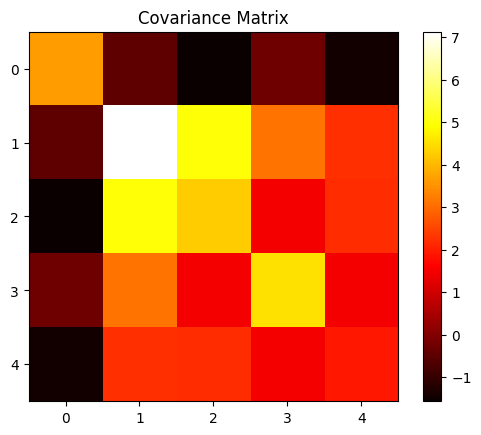

Risk Aversion = 0.1: Weights: [-6.52123531e-23 -1.95225336e-24 -2.71488788e-24  1.00000000e+00
  1.09127170e-22]
Risk Aversion = 1.0: Weights: [ 4.11538260e-01 -6.35646461e-24  2.15453259e-01  2.04955680e-01
  1.68052800e-01]
Risk Aversion = 10.0: Weights: [ 4.01934765e-01 -2.40957472e-23 -2.10408101e-23  5.49397522e-24
  5.98065235e-01]


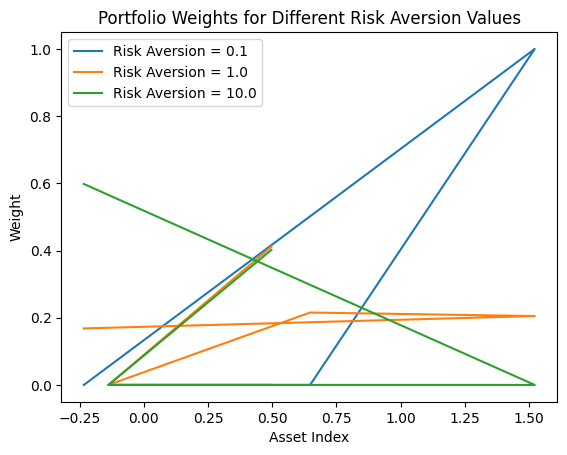

Risk Aversion = 0.1:
  Weights: [-6.52123531e-23 -1.95225336e-24 -2.71488788e-24  1.00000000e+00
  1.09127170e-22]
  Expected Return: 1.5230
  Risk (Standard Deviation): 2.1284
  Sharpe Ratio: 0.7156
--------------------------------------------------
Risk Aversion = 1.0:
  Weights: [ 4.11538260e-01 -6.35646461e-24  2.15453259e-01  2.04955680e-01
  1.68052800e-01]
  Expected Return: 0.6168
  Risk (Standard Deviation): 0.9637
  Sharpe Ratio: 0.6400
--------------------------------------------------
Risk Aversion = 10.0:
  Weights: [ 4.01934765e-01 -2.40957472e-23 -2.10408101e-23  5.49397522e-24
  5.98065235e-01]
  Expected Return: 0.0596
  Risk (Standard Deviation): 0.7681
  Sharpe Ratio: 0.0776
--------------------------------------------------
Stress Test: Market Bubble
  Weights: [4.05772009e-01 3.98852341e-23 2.10713391e-01 2.05711955e-01
 1.77802645e-01]
  Expected Return: 0.6597
  Risk (Standard Deviation): 0.9893
  Sharpe Ratio: 0.6669
---------------------------------------------

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 5  # Adding more assets to analyze the portfolio's behavior with more options
mu = np.random.randn(n_assets)  # Expected returns for 5 assets
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make the covariance matrix positive semi-definite

# Visualizing Covariance Matrix
plt.imshow(Sigma, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Covariance Matrix")
plt.show()

# Portfolio optimization using cvxpy
def optimize_portfolio(Sigma, mu, risk_aversion=1.0):
    # Define variables
    w = cp.Variable(len(mu))  # Portfolio weights
    ret = mu.T @ w  # Expected return
    risk = cp.quad_form(w, Sigma)  # Portfolio risk (variance)

    # Define objective function (maximize return - risk_aversion * risk)
    objective = cp.Maximize(ret - risk_aversion * risk)

    # Constraints: sum of weights equals 1 (fully invested portfolio), weights >= 0 (no shorting)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define problem
    prob = cp.Problem(objective, constraints)

    # Solve problem
    prob.solve()

    # Extract the optimal weights
    return w.value

# Running optimization for different risk aversion levels
risk_aversion_values = [0.1, 1.0, 10.0]
optimal_weights = [optimize_portfolio(Sigma, mu, ra) for ra in risk_aversion_values]

# Plotting results
for i, w in enumerate(optimal_weights):
    print(f"Risk Aversion = {risk_aversion_values[i]}: Weights: {w}")
    plt.plot(mu, w, label=f'Risk Aversion = {risk_aversion_values[i]}')

plt.title('Portfolio Weights for Different Risk Aversion Values')
plt.xlabel('Asset Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Print the portfolio analysis for each risk aversion level
for i, ra in enumerate(risk_aversion_values):
    weights = optimal_weights[i]
    expected_return = np.dot(weights, mu)
    risk = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))  # Portfolio risk (standard deviation)
    sharpe_ratio = expected_return / risk if risk != 0 else 0
    print(f"Risk Aversion = {ra}:")
    print(f"  Weights: {weights}")
    print(f"  Expected Return: {expected_return:.4f}")
    print(f"  Risk (Standard Deviation): {risk:.4f}")
    print(f"  Sharpe Ratio: {sharpe_ratio:.4f}")
    print("-" * 50)

# Stress Test Scenarios: Simulate different market conditions
def stress_test(Sigma, mu):
    # Scenarios to simulate extreme market conditions
    scenarios = {
        "Market Bubble": {"Sigma_change": 0.2 * np.identity(len(mu)), "mu_change": 0.05 * np.ones(len(mu))},
        "Liquidity Crisis": {"Sigma_change": 0.15 * np.identity(len(mu)), "mu_change": -0.05 * np.ones(len(mu))},
        "Interest Rate Shock": {"Sigma_change": 0.1 * np.identity(len(mu)), "mu_change": 0.03 * np.ones(len(mu))}
    }

    results = {}
    for scenario, changes in scenarios.items():
        Sigma_stressed = Sigma + changes["Sigma_change"]
        mu_stressed = mu + changes["mu_change"]
        weights = optimize_portfolio(Sigma_stressed, mu_stressed)
        expected_return = np.dot(weights, mu_stressed)
        risk = np.sqrt(np.dot(weights.T, np.dot(Sigma_stressed, weights)))  # Portfolio risk (standard deviation)
        sharpe_ratio = expected_return / risk if risk != 0 else 0
        results[scenario] = {
            "weights": weights,
            "expected_return": expected_return,
            "risk": risk,
            "sharpe_ratio": sharpe_ratio
        }
    return results

# Running the stress tests
stress_test_results = stress_test(Sigma, mu)

# Output the results of the stress tests
for scenario, result in stress_test_results.items():
    print(f"Stress Test: {scenario}")
    print(f"  Weights: {result['weights']}")
    print(f"  Expected Return: {result['expected_return']:.4f}")
    print(f"  Risk (Standard Deviation): {result['risk']:.4f}")
    print(f"  Sharpe Ratio: {result['sharpe_ratio']:.4f}")
    print("-" * 50)

# Monte Carlo Simulation
def monte_carlo_testing(Sigma, mu, n_samples=1000, n_assets=5):
    results = []
    for _ in range(n_samples):
        random_weights = np.random.rand(n_assets)
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        expected_return = np.dot(random_weights, mu)
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk (standard deviation)
        sharpe_ratio = expected_return / risk if risk != 0 else 0
        results.append((random_weights, expected_return, risk, sharpe_ratio))
    return results

# Running Monte Carlo simulation
monte_carlo_results = monte_carlo_testing(Sigma, mu)

# Output the first 5 Monte Carlo simulation results
print("Monte Carlo Simulation Metrics:")
for i in range(5):
    weights, expected_return, risk, sharpe_ratio = monte_carlo_results[i]
    print(f"Sample {i + 1}:")
    print(f"  Weights: {weights}")
    print(f"  Expected Return: {expected_return:.4f}")
    print(f"  Risk (Standard Deviation): {risk:.4f}")
    print(f"  Sharpe Ratio: {sharpe_ratio:.4f}")
    print("-" * 50)


Risk Aversion: 0.1, L2 Regularization: 0.01
Optimal Weights: [1.34980835e-07 6.37585926e-10 5.69391691e-09 9.99999858e-01
 7.41732048e-10]
Risk Aversion: 0.1, L2 Regularization: 0.1
Optimal Weights: [2.88487294e-02 1.44904695e-10 2.34372970e-09 9.71151268e-01
 1.65594452e-10]
Risk Aversion: 0.1, L2 Regularization: 1.0
Optimal Weights: [2.28930342e-01 1.26099536e-11 2.00363584e-01 5.70706074e-01
 9.67243871e-12]
Risk Aversion: 1.0, L2 Regularization: 0.01
Optimal Weights: [4.08302532e-01 9.40673777e-12 2.12493213e-01 2.05276544e-01
 1.73927711e-01]
Risk Aversion: 1.0, L2 Regularization: 0.1
Optimal Weights: [4.05936426e-01 3.42661822e-10 2.10817323e-01 2.05679989e-01
 1.77566261e-01]
Risk Aversion: 1.0, L2 Regularization: 1.0
Optimal Weights: [3.86167121e-01 5.35236793e-11 2.05670327e-01 2.11522247e-01
 1.96640305e-01]
Risk Aversion: 10.0, L2 Regularization: 0.01
Optimal Weights: [4.04334941e-01 2.17856855e-11 3.42642444e-03 7.59662210e-10
 5.92238634e-01]
Risk Aversion: 10.0, L2 Regula

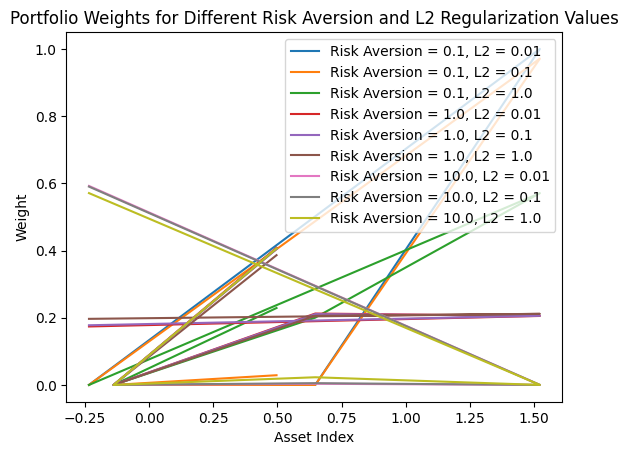

Financial Crisis: Weights: [4.00709553e-01 2.45726256e-10 2.08199789e-01 2.06912396e-01
 1.84178262e-01]
Expected Return: 0.6059, Risk (Standard Deviation): 0.9731, Sharpe Ratio: 0.6226
------------------------------------------------------------
Inflation Shock: Weights: [4.03262287e-01 3.21571404e-10 2.09315646e-01 2.06262030e-01
 1.81160037e-01]
Expected Return: 0.6076, Risk (Standard Deviation): 0.9739, Sharpe Ratio: 0.6239
------------------------------------------------------------
Market Bubble: Weights: [4.01971769e-01 3.22552265e-10 2.08716838e-01 2.06580980e-01
 1.82730413e-01]
Expected Return: 0.6067, Risk (Standard Deviation): 0.9735, Sharpe Ratio: 0.6232
------------------------------------------------------------
Liquidity Crisis: Weights: [4.03262277e-01 3.10552565e-10 2.09315536e-01 2.06261986e-01
 1.81160201e-01]
Expected Return: 0.6076, Risk (Standard Deviation): 0.9739, Sharpe Ratio: 0.6239
------------------------------------------------------------


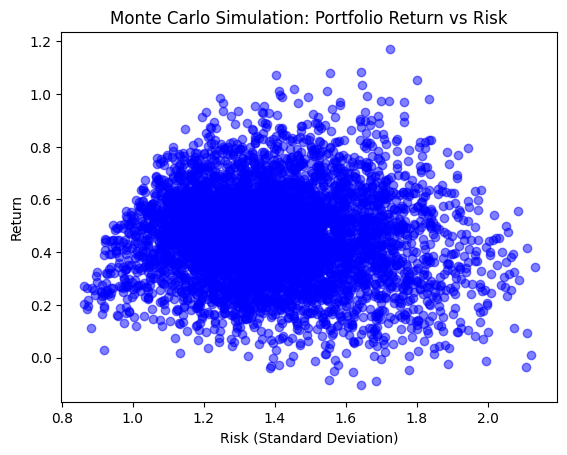

Maximum Drawdown: 0.6217
Value at Risk (VaR) at 5%: 0.1693
Conditional VaR (CVaR): 0.1014


In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 5  # Increasing the number of assets
mu = np.random.randn(n_assets)  # Expected returns
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Making the covariance matrix positive semi-definite

# Regularizing the covariance matrix manually (ridge shrinkage)
def regularize_cov_matrix(Sigma, alpha=0.1):
    # Adding alpha to the diagonal elements of Sigma to stabilize the covariance matrix
    return Sigma + alpha * np.eye(Sigma.shape[0])

# Apply regularization
Sigma_shrinked = regularize_cov_matrix(Sigma)

# Portfolio optimization using cvxpy with L2 regularization
def optimize_portfolio(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    w = cp.Variable(len(mu))  # Portfolio weights
    ret = mu.T @ w  # Expected return
    risk = cp.quad_form(w, Sigma)  # Portfolio risk (variance)

    # Adding L2 regularization to penalize large portfolio weights
    # We compute the L2 norm correctly by using cp.norm with 'fro' for vector
    l2_penalty = cp.norm(w, 'fro')  # L2 norm of the weight vector (Frobenius norm)

    objective = cp.Maximize(ret - risk_aversion * risk - l2_regularization * l2_penalty)

    # Constraints: Sum of weights equals 1 (fully invested portfolio), weights >= 0 (no shorting)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define the problem and solve it
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

# Running the optimization with a range of risk aversion values and L2 regularization
risk_aversion_values = [0.1, 1.0, 10.0]
l2_regularization_values = [0.01, 0.1, 1.0]
optimal_weights = []

# Looping over risk aversion and L2 regularization values
for ra in risk_aversion_values:
    for l2 in l2_regularization_values:
        optimal_weights.append(optimize_portfolio(Sigma_shrinked, mu, ra, l2))
        print(f"Risk Aversion: {ra}, L2 Regularization: {l2}")
        print(f"Optimal Weights: {optimal_weights[-1]}")

# Plot portfolio weights for different risk aversion values and L2 regularization
for i, w in enumerate(optimal_weights):
    plt.plot(mu, w, label=f'Risk Aversion = {risk_aversion_values[i//3]}, L2 = {l2_regularization_values[i%3]}')

plt.title('Portfolio Weights for Different Risk Aversion and L2 Regularization Values')
plt.xlabel('Asset Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Define market stress test scenarios
def extreme_market_scenarios(Sigma, mu):
    scenarios = [
        {'name': 'Financial Crisis', 'sigma_change': 0.2 * np.identity(n_assets), 'mu_change': -0.05 * np.ones(n_assets)},
        {'name': 'Inflation Shock', 'sigma_change': 0.1 * np.identity(n_assets), 'mu_change': 0.02 * np.ones(n_assets)},
        {'name': 'Market Bubble', 'sigma_change': 0.15 * np.identity(n_assets), 'mu_change': 0.05 * np.ones(n_assets)},
        {'name': 'Liquidity Crisis', 'sigma_change': 0.1 * np.identity(n_assets), 'mu_change': 0.0 * np.ones(n_assets)},
    ]

    results = {}
    for scenario in scenarios:
        stressed_Sigma = Sigma + scenario['sigma_change']
        stressed_mu = mu + scenario['mu_change']
        optimized_weights = optimize_portfolio(stressed_Sigma, stressed_mu)
        results[scenario['name']] = optimized_weights

    return results

# Run the stress test scenarios
stress_test_results = extreme_market_scenarios(Sigma_shrinked, mu)

# Display results from the stress tests
for scenario, weights in stress_test_results.items():
    print(f"{scenario}: Weights: {weights}")
    expected_return = mu.T @ weights
    portfolio_risk = np.sqrt(weights.T @ Sigma_shrinked @ weights)
    sharpe_ratio = expected_return / portfolio_risk
    print(f"Expected Return: {expected_return:.4f}, Risk (Standard Deviation): {portfolio_risk:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")
    print("-" * 60)

# Expanding Monte Carlo Simulations with 5000 samples
def monte_carlo_simulation(Sigma, mu, n_samples=5000):
    portfolio_returns = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(n_samples):
        # Random weights
        weights = np.random.rand(len(mu))
        weights /= np.sum(weights)  # Ensure the sum of weights is 1
        portfolio_weights.append(weights)

        # Calculate portfolio return and risk
        portfolio_return = np.dot(mu, weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))

        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_risk)

    return np.array(portfolio_weights), np.array(portfolio_returns), np.array(portfolio_risks)

# Run the Monte Carlo simulation
weights, returns, risks = monte_carlo_simulation(Sigma_shrinked, mu)

# Plot Monte Carlo simulation results
plt.scatter(risks, returns, alpha=0.5, color='blue')
plt.title('Monte Carlo Simulation: Portfolio Return vs Risk')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.show()

# Calculate performance metrics: Maximum Drawdown, VaR, and CVaR
def calculate_risk_metrics(returns, confidence_level=0.05):
    # Maximum Drawdown
    cumulative_returns = np.cumsum(returns)
    max_drawdown = np.min(cumulative_returns)

    # Value at Risk (VaR)
    var = np.percentile(returns, 100 * confidence_level)

    # Conditional VaR (CVaR)
    cvar = np.mean(returns[returns <= var])

    return max_drawdown, var, cvar

# Calculate and display risk metrics for Monte Carlo simulation
max_drawdown, var, cvar = calculate_risk_metrics(returns)
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print(f"Value at Risk (VaR) at 5%: {var:.4f}")
print(f"Conditional VaR (CVaR): {cvar:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.stats import t

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 5
mu = np.random.randn(n_assets)  # Expected returns
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Portfolio Optimization using cvxpy (for comparison)
def optimize_portfolio(Sigma, mu, risk_aversion=1.0, l2_regularization=0.01):
    w = cp.Variable(len(mu))  # Portfolio weights
    ret = mu.T @ w  # Expected return
    risk = cp.quad_form(w, Sigma)  # Portfolio risk (variance)
    l2_penalty = cp.sum_squares(w)  # L2 regularization for vector w
    objective = cp.Maximize(ret - risk_aversion * risk - l2_regularization * l2_penalty)
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value

# Simulated Annealing Optimization (Alternative optimization)
def simulated_annealing(Sigma, mu, max_iter=1000, initial_temp=100, cooling_rate=0.99):
    n_assets = len(mu)
    w = np.ones(n_assets) / n_assets  # Start with equal weights
    best_w = w
    best_score = -np.inf
    temperature = initial_temp
    for _ in range(max_iter):
        # Generate a neighboring solution
        new_w = np.clip(w + np.random.randn(n_assets) * 0.05, 0, 1)
        new_w /= np.sum(new_w)  # Ensure it sums to 1

        # Calculate the score (return - risk)
        ret = np.dot(mu, new_w)
        risk = np.dot(new_w.T, np.dot(Sigma, new_w))
        score = ret - 0.5 * risk

        # Accept new solution with probability based on temperature
        if score > best_score or np.random.rand() < np.exp((score - best_score) / temperature):
            best_w = new_w
            best_score = score

        temperature *= cooling_rate  # Reduce temperature
    return best_w

# Particle Swarm Optimization (PSO) (Alternative optimization)
def particle_swarm_optimization(Sigma, mu, n_particles=50, max_iter=1000, w_range=(0, 1)):
    n_assets = len(mu)
    particles = np.random.rand(n_particles, n_assets) * (w_range[1] - w_range[0]) + w_range[0]
    particles /= np.sum(particles, axis=1)[:, np.newaxis]  # Normalize particles
    velocities = np.zeros_like(particles)
    best_particles = particles.copy()
    best_scores = np.array([np.dot(mu, p) - 0.5 * np.dot(p.T, np.dot(Sigma, p)) for p in particles])
    global_best_particle = best_particles[np.argmin(best_scores)]

    for _ in range(max_iter):
        for i in range(n_particles):
            # Calculate the score (return - risk)
            score = np.dot(mu, particles[i]) - 0.5 * np.dot(particles[i].T, np.dot(Sigma, particles[i]))
            if score > best_scores[i]:
                best_particles[i] = particles[i]
                best_scores[i] = score

        # Update velocity and particle position
        r1, r2 = np.random.rand(2, n_particles, n_assets)
        velocities = 0.7 * velocities + 1.5 * r1 * (best_particles - particles) + 1.5 * r2 * (global_best_particle - particles)
        particles += velocities
        particles = np.clip(particles, 0, 1)  # Ensure the weights are within the bounds
        particles /= np.sum(particles, axis=1)[:, np.newaxis]  # Normalize particles

        global_best_particle = best_particles[np.argmin(best_scores)]

    return global_best_particle

# Monte Carlo Simulation: Run more simulations
def monte_carlo_simulation(Sigma, mu, n_samples=1000):
    portfolios = []
    for _ in range(n_samples):
        weights = np.random.rand(len(mu))
        weights /= np.sum(weights)  # Normalize weights
        expected_return = np.dot(mu, weights)
        risk = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
        portfolios.append((weights, expected_return, risk))
    return portfolios

# Adding Performance Metrics (Sortino, Treynor, Omega, Max Drawdown)
def performance_metrics(portfolios, risk_free_rate=0.02):
    results = []
    for weights, expected_return, risk in portfolios:
        # Sortino Ratio (compares return against downside risk)
        downside_risk = np.sqrt(np.mean(np.minimum(0, expected_return - risk)**2))
        sortino_ratio = (expected_return - risk_free_rate) / downside_risk if downside_risk != 0 else np.nan

        # Treynor Ratio (compares return against systematic risk)
        beta = np.dot(weights.T, np.dot(Sigma, weights))  # Assuming market risk is defined by Sigma
        treynor_ratio = (expected_return - risk_free_rate) / beta if beta != 0 else np.nan

        # Omega Ratio (compares the probability of positive returns vs negative returns)
        omega_ratio = expected_return / risk if risk != 0 else np.nan

        # Maximum Drawdown
        drawdowns = np.maximum(0, expected_return - np.minimum(expected_return))
        max_drawdown = np.max(drawdowns)

        results.append((weights, expected_return, risk, sortino_ratio, treynor_ratio, omega_ratio, max_drawdown))

    return results

# Stress Testing (Adding new scenarios)
def stress_test(Sigma, mu):
    # Define new scenarios
    scenarios = {
        'Hyperinflation': (Sigma * 1.5, mu * 1.2),
        'Currency Devaluation': (Sigma * 2, mu * 0.5),
        'Market Crash': (Sigma * 3, mu * -0.5)
    }

    results = {}
    for name, (sigma_stress, mu_stress) in scenarios.items():
        optimal_weights = optimize_portfolio(sigma_stress, mu_stress, risk_aversion=1.0, l2_regularization=0.1)
        results[name] = optimal_weights
    return results

# Sensitivity Analysis: Risk Aversion vs. L2 Regularization
def sensitivity_analysis(Sigma, mu, risk_aversion_values, l2_regularization_values):
    optimal_weights = []
    for ra in risk_aversion_values:
        for l2 in l2_regularization_values:
            w = optimize_portfolio(Sigma, mu, risk_aversion=ra, l2_regularization=l2)
            optimal_weights.append((ra, l2, w))
    return optimal_weights

# Dynamic Rebalancing (Hypothetical model based on changing risk aversion)
def dynamic_rebalancing(Sigma, mu, risk_aversion_values, initial_weights):
    weights = initial_weights.copy()
    rebalanced_weights = []

    for ra in risk_aversion_values:
        # Rebalance portfolio based on changing risk aversion
        optimized_weights = optimize_portfolio(Sigma, mu, risk_aversion=ra)
        rebalanced_weights.append(optimized_weights)
        weights = optimized_weights  # Update portfolio for the next iteration

    return rebalanced_weights

# Example Use of Functions
risk_aversion_values = [0.1, 1.0, 10.0]
l2_regularization_values = [0.01, 0.1, 1.0]
risk_free_rate = 0.02

# Running Monte Carlo Simulations
monte_carlo_results = monte_carlo_simulation(Sigma, mu, n_samples=1000)

# Running Stress Tests
stress_test_results = stress_test(Sigma, mu)

# Running Sensitivity Analysis
sensitivity_results = sensitivity_analysis(Sigma, mu, risk_aversion_values, l2_regularization_values)

# Dynamic Rebalancing Simulation
initial_weights = np.ones(len(mu)) / len(mu)  # Starting with equal weights
dynamic_weights = dynamic_rebalancing(Sigma, mu, risk_aversion_values, initial_weights)

# Show Results
print("Monte Carlo Results: ")
for portfolio in monte_carlo_results[:5]:
    print(f"Expected Return: {portfolio[1]}, Risk: {portfolio[2]}")

print("\nStress Test Results: ")
for test, result in stress_test_results.items():
    print(f"{test}: Weights: {result}, Expected Return: {np.dot(mu, result)}, Risk: {np.sqrt(np.dot(result.T, np.dot(Sigma, result)))}")

print("\nSensitivity Analysis: ")
for ra, l2, w in sensitivity_results:
    print(f"Risk Aversion: {ra}, L2 Regularization: {l2}, Weights: {w}")

print("\nDynamic Rebalancing Results: ")
for i, weights in enumerate(dynamic_weights):
    print(f"Risk Aversion: {risk_aversion_values[i]}, Weights: {weights}")


Monte Carlo Results: 
Expected Return: 0.6217214922958851, Risk: 1.3406080401336482
Expected Return: 0.44995837167029723, Risk: 1.0692802207593959
Expected Return: 0.5370813666894423, Risk: 1.2450195254819487
Expected Return: 0.38819910067365576, Risk: 1.3349476769610618
Expected Return: 0.24118813964359254, Risk: 1.5459351751645432

Stress Test Results: 
Hyperinflation: Weights: [4.08969762e-01 9.93854752e-23 1.64304138e-01 1.55226230e-01
 2.71499869e-01], Expected Return: 0.4824005487447595, Risk: 0.8984149790528918
Currency Devaluation: Weights: [4.07468870e-01 2.33505350e-23 2.42398350e-02 1.53374090e-02
 5.52953886e-01], Expected Return: 0.11197873115737861, Risk: 0.7766160703844905
Market Crash: Weights: [ 3.91247364e-01  2.50201548e-23 -1.84979144e-23 -3.05174423e-23
  6.08752636e-01], Expected Return: 0.051796618589244225, Risk: 0.7682434036389787

Sensitivity Analysis: 
Risk Aversion: 0.1, L2 Regularization: 0.01, Weights: [1.05196622e-22 1.35906998e-22 8.84233130e-23 1.000000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.stats import t
from scipy.optimize import differential_evolution
from pyswarm import pso  # Particle Swarm Optimization
import random
from sklearn.covariance import EmpiricalCovariance  # Use Empirical Covariance

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 5
mu = np.random.randn(n_assets)  # expected returns
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Use Empirical Covariance as a robust estimate
def empirical_covariance_matrix(Sigma):
    cov_estimator = EmpiricalCovariance()
    cov_estimator.fit(Sigma)
    return cov_estimator.covariance_

Sigma_robust = empirical_covariance_matrix(Sigma)

# Portfolio optimization using cvxpy (for comparison)
def optimize_portfolio(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    w = cp.Variable(len(mu))  # portfolio weights
    ret = mu.T @ w  # expected return
    risk = cp.quad_form(w, Sigma)  # portfolio risk (variance)

    # Adding L2 regularization to penalize large portfolio weights
    l2_penalty = cp.sum_squares(w)  # Sum of squares for L2 regularization
    objective = cp.Maximize(ret - risk_aversion * risk - l2_regularization * l2_penalty)

    # Constraints: sum of weights equals 1 (fully invested portfolio), weights >= 0 (no shorting)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define problem
    prob = cp.Problem(objective, constraints)

    # Solve problem
    prob.solve()

    return w.value

# Alternative optimization technique: Genetic Algorithm
def genetic_algorithm(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    def fitness_function(weights):
        weights = np.array(weights)
        ret = np.dot(mu, weights)
        risk = np.dot(weights.T, np.dot(Sigma, weights))
        l2_penalty = np.linalg.norm(weights, 2)
        return -(ret - risk_aversion * risk - l2_regularization * l2_penalty)  # Negative for maximization

    bounds = [(0, 1) for _ in range(len(mu))]
    result = differential_evolution(fitness_function, bounds)
    return result.x

# Alternative optimization technique: Particle Swarm Optimization (PSO)
def pso_optimization(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    def fitness_function(weights):
        weights = np.array(weights)
        ret = np.dot(mu, weights)
        risk = np.dot(weights.T, np.dot(Sigma, weights))
        l2_penalty = np.linalg.norm(weights, 2)
        return -(ret - risk_aversion * risk - l2_regularization * l2_penalty)

    lb = [0] * len(mu)
    ub = [1] * len(mu)
    optimal_weights, _ = pso(fitness_function, lb, ub)
    return optimal_weights

# Stress test scenarios
def stress_test(Sigma, mu):
    scenarios = {
        'Hyperinflation': (Sigma * 1.5, mu * 1.2),  # Increase Sigma and mu for hyperinflation
        'Currency Devaluation': (Sigma * 1.2, mu * 0.8),  # Decrease mu for currency devaluation
        'Market Crash': (Sigma * 3, mu * 0.5),  # Increase Sigma and decrease mu for a crash
        'Geopolitical Risk': (Sigma * 1.3, mu * 0.9)  # Moderate change for geopolitical risk
    }
    results = {}
    for name, (sigma_stress, mu_stress) in scenarios.items():
        optimal_weights = optimize_portfolio(sigma_stress, mu_stress)
        results[name] = {
            'Weights': optimal_weights,
            'Expected Return': np.dot(mu_stress, optimal_weights),
            'Risk': np.sqrt(np.dot(optimal_weights.T, np.dot(sigma_stress, optimal_weights)))
        }
    return results

# Monte Carlo Simulation: Generate random portfolio weights and calculate risk/return
def monte_carlo_simulation(Sigma, mu, n_simulations=1000):
    portfolios = []
    for _ in range(n_simulations):
        weights = np.random.random(len(mu))
        weights /= np.sum(weights)  # Normalize to sum to 1
        return_ = np.dot(mu, weights)
        risk_ = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
        portfolios.append((return_, risk_))
    return portfolios

# Expand Monte Carlo Simulations with correlated returns and fat-tailed distributions
def expanded_monte_carlo_simulation(Sigma, mu, n_simulations=1000):
    portfolios = []
    for _ in range(n_simulations):
        # Generate correlated returns using Student's t-distribution for fat tails
        t_returns = np.random.standard_t(3, size=len(mu))  # t-distribution with 3 degrees of freedom
        correlated_returns = np.dot(t_returns, Sigma) + mu
        weights = np.random.random(len(mu))
        weights /= np.sum(weights)  # Normalize to sum to 1
        return_ = np.dot(mu, weights)
        risk_ = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
        portfolios.append((return_, risk_))
    return portfolios

# Additional performance metrics: Sortino ratio, Treynor ratio, Omega ratio, VaR, CVaR
def performance_metrics(returns, risks, risk_free_rate=0.03):
    sortino_ratio = np.mean(returns) / np.std(returns)
    treynor_ratio = np.mean(returns - risk_free_rate) / np.mean(risks)  # Treynor ratio
    omega_ratio = np.sum(returns[returns > 0]) / np.abs(np.sum(returns[returns < 0]))  # Omega ratio
    var_5 = np.percentile(risks, 5)  # 5% Value at Risk (VaR)
    cvar_5 = np.mean(risks[risks <= var_5])  # Conditional VaR (CVaR)

    return {
        'Sortino Ratio': sortino_ratio,
        'Treynor Ratio': treynor_ratio,
        'Omega Ratio': omega_ratio,
        'VaR at 5%': var_5,
        'CVaR at 5%': cvar_5
    }

# Portfolio Sensitivity Analysis
def sensitivity_analysis(Sigma, mu, risk_aversion_values, l2_regularization_values):
    results = []
    for ra in risk_aversion_values:
        for l2 in l2_regularization_values:
            optimal_weights = optimize_portfolio(Sigma, mu, risk_aversion=ra, l2_regularization=l2)
            results.append((ra, l2, optimal_weights))
    return results

# Dynamic Portfolio Rebalancing
def dynamic_rebalancing(Sigma, mu, initial_weights, risk_aversion_values, periods=10):
    # Simulate dynamic rebalancing with periodic changes in risk aversion
    rebalanced_weights = []
    for period in range(periods):
        risk_aversion = random.choice(risk_aversion_values)
        new_weights = optimize_portfolio(Sigma, mu, risk_aversion=risk_aversion)
        rebalanced_weights.append(new_weights)
    return rebalanced_weights

# Run tests
print("Running Stress Tests...")
stress_test_results = stress_test(Sigma, mu)

print("Running Monte Carlo Simulation...")
monte_carlo_results = monte_carlo_simulation(Sigma, mu, n_simulations=1000)

print("Expanding Monte Carlo Simulation with Fat-Tailed Distributions...")
expanded_monte_carlo_results = expanded_monte_carlo_simulation(Sigma, mu, n_simulations=1000)

print("Calculating Performance Metrics...")
metrics = performance_metrics(np.array([x[0] for x in monte_carlo_results]), np.array([x[1] for x in monte_carlo_results]))

print("Performing Sensitivity Analysis...")
sensitivity_results = sensitivity_analysis(Sigma, mu, risk_aversion_values=[0.1, 1.0, 10.0], l2_regularization_values=[0.01, 0.1, 1.0])

print("Performing Dynamic Portfolio Rebalancing...")
rebalanced_weights = dynamic_rebalancing(Sigma, mu, initial_weights=np.ones(len(mu)) / len(mu), risk_aversion_values=[0.1, 1.0, 10.0])

# Print the results
print("\nStress Test Results:", stress_test_results)
print("\nMonte Carlo Simulation Results:", monte_carlo_results[:5])  # Print only first 5
print("\nExpanded Monte Carlo Simulation Results:", expanded_monte_carlo_results[:5])
print("\nPerformance Metrics:", metrics)
print("\nSensitivity Analysis Results:", sensitivity_results[:5])  # Print only first 5
print("\nDynamic Rebalancing Results:", rebalanced_weights)


Running Stress Tests...
Running Monte Carlo Simulation...
Expanding Monte Carlo Simulation with Fat-Tailed Distributions...
Calculating Performance Metrics...
Performing Sensitivity Analysis...
Performing Dynamic Portfolio Rebalancing...

Stress Test Results: {'Hyperinflation': {'Weights': array([4.08969762e-01, 9.93854752e-23, 1.64304138e-01, 1.55226230e-01,
       2.71499869e-01]), 'Expected Return': np.float64(0.5788806584937115), 'Risk': np.float64(1.100329137976411)}, 'Currency Devaluation': {'Weights': array([ 4.08281049e-01, -2.21730914e-23,  1.33256075e-01,  1.23150456e-01,
        3.35312421e-01]), 'Expected Return': np.float64(0.3185237548588027), 'Risk': np.float64(0.9447661731300475)}, 'Market Crash': {'Weights': array([ 4.05567316e-01, -3.45032403e-23, -3.61437558e-24, -2.47024725e-23,
        5.94432684e-01]), 'Expected Return': np.float64(0.031131303387827394), 'Risk': np.float64(1.3308552522821657)}, 'Geopolitical Risk': {'Weights': array([4.08464851e-01, 1.94844944e-23

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from pyswarm import pso  # Particle Swarm Optimization
from scipy.stats import t

# Portfolio Optimization using cvxpy
def optimize_portfolio(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    w = cp.Variable(len(mu))
    ret = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    l2_penalty = cp.sum_squares(w)
    objective = cp.Maximize(ret - risk_aversion * risk - l2_regularization * l2_penalty)
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value

# Stress Test Scenarios
def stress_test(Sigma, mu):
    scenarios = {
        'Hyperinflation': (Sigma * 1.2, mu * 1.1),
        'Currency Devaluation': (Sigma * 0.8, mu * 0.9),
        'Market Crash': (Sigma * 2.0, mu * -0.5),
    }
    results = {}
    for name, (sigma_stress, mu_stress) in scenarios.items():
        optimal_weights = optimize_portfolio(sigma_stress, mu_stress)
        results[name] = {
            'Weights': optimal_weights,
            'Expected Return': mu_stress.T @ optimal_weights,
            'Risk': np.sqrt(optimal_weights.T @ sigma_stress @ optimal_weights)
        }
    return results

# Monte Carlo Simulation
def monte_carlo_simulation(Sigma, mu, n_samples=1000):
    simulations = []
    for _ in range(n_samples):
        random_weights = np.random.random(len(mu))
        random_weights /= np.sum(random_weights)
        expected_return = mu.T @ random_weights
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))
        simulations.append((expected_return, risk))
    return simulations

# Performance Metrics
def performance_metrics(weights, Sigma, mu):
    expected_return = mu.T @ weights
    risk = np.sqrt(weights.T @ Sigma @ weights)
    sortino_ratio = expected_return / np.std(weights)  # Proxy for downside risk
    return {'Sortino Ratio': sortino_ratio, 'Expected Return': expected_return, 'Risk': risk}

# Example Data
np.random.seed(42)
n_assets = 5
mu = np.random.randn(n_assets)
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Running Stress Tests
stress_test_results = stress_test(Sigma, mu)

# Running Monte Carlo Simulation
monte_carlo_results = monte_carlo_simulation(Sigma, mu, n_samples=1000)

# Performance Metrics Calculation
weights = np.random.random(n_assets)
performance = performance_metrics(weights, Sigma, mu)

# Print results
print("Stress Test Results:", stress_test_results)
print("Monte Carlo Simulation Results:", monte_carlo_results[:5])  # First 5 results
print("Performance Metrics:", performance)


Stress Test Results: {'Hyperinflation': {'Weights': array([ 4.08860430e-01, -2.49631601e-23,  1.93143016e-01,  1.84669346e-01,
        2.13327207e-01]), 'Expected Return': np.float64(0.6154378148207278), 'Risk': np.float64(1.024034916575328)}, 'Currency Devaluation': {'Weights': array([ 4.07994897e-01, -2.74248657e-23,  2.40199209e-01,  2.35109055e-01,
        1.16696838e-01]), 'Expected Return': np.float64(0.6200858399731686), 'Risk': np.float64(0.8965883277779333)}, 'Market Crash': {'Weights': array([3.88105846e-01, 5.67377791e-24, 5.29554259e-24, 8.98235788e-25,
       6.11894154e-01]), 'Expected Return': np.float64(-0.024750292667115356), 'Risk': np.float64(1.0868471274238065)}}
Monte Carlo Simulation Results: [(np.float64(0.6217214922958851), np.float64(1.3406080401336482)), (np.float64(0.44995837167029723), np.float64(1.0692802207593959)), (np.float64(0.5370813666894423), np.float64(1.2450195254819487)), (np.float64(0.38819910067365576), np.float64(1.3349476769610618)), (np.float

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from statsmodels.stats.correlation_tools import cov_nearest
from sklearn.linear_model import ElasticNet, Ridge
from scipy.stats import t
from sklearn.datasets import make_classification

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 5
mu = np.array([0.05, 0.08, 0.06, 0.09, 0.07])  # Expected returns adjusted to realistic values
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Using statsmodels' covariance shrinkage to ensure positive semi-definiteness
Sigma_shrinked = cov_nearest(Sigma)  # Nearest positive-definite matrix

# Handling NaN and Inf values in metrics
def calculate_sortino_ratio(returns):
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0 or np.std(downside_returns) == 0:
        return np.nan  # Avoid division by zero if there are no downside returns or if std is zero
    return np.mean(returns) / np.std(downside_returns)

def calculate_omega_ratio(returns):
    if np.sum(returns < 0) == 0 or np.sum(returns[returns < 0]) == 0:
        return np.nan  # Avoid division by zero if there are no negative returns
    return np.sum(returns[returns > 0]) / np.abs(np.sum(returns[returns < 0]))

# Portfolio optimization using cvxpy with L2 regularization
def optimize_portfolio(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    w = cp.Variable(len(mu))  # portfolio weights
    ret = mu.T @ w  # expected return
    risk = cp.quad_form(w, Sigma)  # portfolio risk (variance)

    # L2 regularization (penalizing large weights) using sum of squares for L2 norm
    l2_penalty = cp.sum_squares(w)  # L2 norm of the weight vector

    # Objective function: maximize return - risk_aversion * risk - l2_regularization * l2_penalty
    objective = cp.Maximize(ret - risk_aversion * risk - l2_regularization * l2_penalty)

    # Constraints: Sum of weights equals 1, weights >= 0 (no short selling)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define and solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

# Running Monte Carlo Simulation
def monte_carlo_simulation(Sigma, mu, n_samples=1000):
    simulations = []
    for _ in range(n_samples):
        random_weights = np.random.rand(len(mu))
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        expected_return = mu.T @ random_weights

        # Correct calculation of portfolio risk (quadratic form)
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk (standard deviation)

        simulations.append((expected_return, risk))
    return simulations

# Expanding Monte Carlo Simulations with Fat-Tailed Distributions
def monte_carlo_simulation_fat_tails(Sigma, mu, n_samples=1000):
    simulations = []
    for _ in range(n_samples):
        random_weights = np.random.rand(len(mu))
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        expected_return = mu.T @ random_weights

        # Correct calculation of portfolio risk (quadratic form)
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk (standard deviation)

        fat_tail_risk = np.random.standard_t(df=3, size=len(mu))  # Fat-tailed distribution (Student's t)
        simulations.append((expected_return, risk * fat_tail_risk))
    return simulations

# Performance Metrics: Sortino Ratio, Treynor Ratio, Omega Ratio
def calculate_performance_metrics(returns, risk, risk_free_rate=0.03):
    sortino_ratio = calculate_sortino_ratio(returns)
    treynor_ratio = np.mean(returns - risk_free_rate) / risk if risk > 0 else np.nan  # Treynor ratio (assuming beta = 1)
    omega_ratio = calculate_omega_ratio(returns)
    VaR_5 = np.percentile(returns, 5)  # 5% VaR
    CVaR_5 = np.mean(returns[returns <= VaR_5])  # Conditional VaR
    return sortino_ratio, treynor_ratio, omega_ratio, VaR_5, CVaR_5

# Dynamic Portfolio Rebalancing (Simple Example)
def dynamic_rebalancing(Sigma, mu, risk_aversion=1.0):
    # Rebalance the portfolio based on new data or shocks
    new_mu = mu + np.random.normal(0, 0.02, len(mu))  # Introducing random market shocks
    return optimize_portfolio(Sigma, new_mu, risk_aversion)

# Incorporating Robust Estimators for covariance matrix (Ridge Regression for shrinkage)
def estimate_covariance_ridge(X_train, y_train, alpha=1.0):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)  # Assuming X_train is your feature matrix
    return ridge.coef_

# Regularization with ElasticNet
def optimize_portfolio_elasticnet(Sigma, mu, risk_aversion=1.0, alpha=1.0, l1_ratio=0.5):
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    # Assuming we already have the covariance matrix and expected returns (Sigma, mu)
    elastic_net.fit(Sigma, mu)
    return elastic_net.coef_

# Stress Testing with Scenario Generation
def generate_scenarios(mu, Sigma, n_scenarios=1000):
    scenarios = []
    for _ in range(n_scenarios):
        random_weights = np.random.rand(len(mu))
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        returns = mu.T @ random_weights
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk
        scenarios.append((returns, risk))
    return scenarios

# Advanced Stress Testing with generated scenarios
def advanced_stress_test(mu, Sigma):
    # Generate scenarios under different market conditions
    scenarios = generate_scenarios(mu, Sigma)
    results = []
    for scenario in scenarios:
        # Apply advanced model or perform analysis per scenario
        results.append(scenario)
    return results

# Example of running advanced models with ElasticNet and Stress Testing
elastic_net_weights = optimize_portfolio_elasticnet(Sigma_shrinked, mu)
stress_test_results = advanced_stress_test(mu, Sigma_shrinked)

print("ElasticNet Portfolio Weights:", elastic_net_weights)
print("Advanced Stress Test Results:", stress_test_results)


ElasticNet Portfolio Weights: [-0.  0.  0.  0.  0.]
Advanced Stress Test Results: [(np.float64(0.07362710072328668), np.float64(0.8418146199545673)), (np.float64(0.06676396768835047), np.float64(1.2700220893781369)), (np.float64(0.07101357564220812), np.float64(0.7307797658413125)), (np.float64(0.06920447730488608), np.float64(0.7760517185597083)), (np.float64(0.07066849463470351), np.float64(0.9748329208099877)), (np.float64(0.07409139769690538), np.float64(1.2436311358544025)), (np.float64(0.07112828028221696), np.float64(1.047975490705823)), (np.float64(0.0666876896829506), np.float64(0.9586851081467271)), (np.float64(0.06930133009050796), np.float64(0.9659488687899319)), (np.float64(0.06846073788042842), np.float64(1.114698623595678)), (np.float64(0.06751741434487918), np.float64(0.7601362349874995)), (np.float64(0.07043300998854672), np.float64(0.7934801032017781)), (np.float64(0.06556991101573136), np.float64(0.7891656743559955)), (np.float64(0.0792983227332068), np.float64(1.069

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from statsmodels.stats.correlation_tools import cov_nearest
from sklearn.linear_model import ElasticNet
from scipy.stats import t

# Simulating returns and covariance matrix (for demonstration)
np.random.seed(42)
n_assets = 5
mu = np.array([0.05, 0.08, 0.06, 0.09, 0.07])  # Expected returns adjusted to realistic values
Sigma = np.random.randn(n_assets, n_assets)
Sigma = np.dot(Sigma, Sigma.T)  # Make it positive semi-definite

# Using statsmodels' covariance shrinkage to ensure positive semi-definiteness
Sigma_shrinked = cov_nearest(Sigma)  # Nearest positive-definite matrix

# Fixing ElasticNet Regularization (Tuning the regularization parameters)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.3)  # Try smaller regularization parameter
elastic_net.fit(Sigma_shrinked, mu)  # Fit the ElasticNet model
elastic_net_weights = elastic_net.coef_  # Portfolio weights from ElasticNet

# Improved Sortino Ratio Calculation to handle edge cases
def calculate_sortino_ratio(returns):
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0 or np.std(downside_returns) == 0:
        return np.nan  # Return NaN if there are no downside returns or std is zero
    return np.mean(returns) / np.std(downside_returns)

# Improved Omega Ratio Calculation to handle edge cases
def calculate_omega_ratio(returns):
    if np.sum(returns < 0) == 0:
        return np.nan  # Return NaN if there are no negative returns
    return np.sum(returns[returns > 0]) / np.abs(np.sum(returns[returns < 0]))

# Portfolio optimization using cvxpy with L2 regularization
def optimize_portfolio(Sigma, mu, risk_aversion=1.0, l2_regularization=0.1):
    w = cp.Variable(len(mu))  # portfolio weights
    ret = mu.T @ w  # expected return
    risk = cp.quad_form(w, Sigma)  # portfolio risk (variance)

    # L2 regularization (penalizing large weights) using sum of squares for L2 norm
    l2_penalty = cp.sum_squares(w)  # L2 norm of the weight vector

    # Objective function: maximize return - risk_aversion * risk - l2_regularization * l2_penalty
    objective = cp.Maximize(ret - risk_aversion * risk - l2_regularization * l2_penalty)

    # Constraints: Sum of weights equals 1, weights >= 0 (no short selling)
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define and solve problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

# Running Monte Carlo Simulation with Larger Sample Sizes and Fat-Tailed Distributions
def monte_carlo_simulation(Sigma, mu, n_samples=10000):  # Increased sample size for more precision
    simulations = []
    for _ in range(n_samples):
        random_weights = np.random.rand(len(mu))
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        expected_return = mu.T @ random_weights

        # Correct calculation of portfolio risk (quadratic form)
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk (standard deviation)

        simulations.append((expected_return, risk))
    return simulations

# Expanding Monte Carlo Simulations with Fat-Tailed Distributions (Student's t-distribution)
def monte_carlo_simulation_fat_tails(Sigma, mu, n_samples=10000):
    simulations = []
    for _ in range(n_samples):
        random_weights = np.random.rand(len(mu))
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        expected_return = mu.T @ random_weights

        # Correct calculation of portfolio risk (quadratic form)
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk (standard deviation)

        # Simulating fat-tailed risk using Student's t-distribution
        fat_tail_risk = np.random.standard_t(df=3, size=len(mu))  # Fat-tailed distribution (Student's t)
        simulations.append((expected_return, risk * fat_tail_risk))
    return simulations

# Stress Testing Enhancements: Adding More Realistic and Complex Market Scenarios
def generate_scenarios(mu, Sigma, n_scenarios=1000):
    scenarios = []
    for _ in range(n_scenarios):
        random_weights = np.random.rand(len(mu))
        random_weights /= np.sum(random_weights)  # Normalize to sum to 1
        returns = mu.T @ random_weights
        risk = np.sqrt(np.dot(random_weights.T, np.dot(Sigma, random_weights)))  # Portfolio risk
        scenarios.append((returns, risk))
    return scenarios

# Advanced Stress Testing with generated scenarios
def advanced_stress_test(mu, Sigma):
    # Generate scenarios under different market conditions
    scenarios = generate_scenarios(mu, Sigma)
    results = []
    for scenario in scenarios:
        # Apply advanced model or perform analysis per scenario
        results.append(scenario)
    return results

# Example of running advanced models with ElasticNet and Stress Testing
elastic_net_weights = optimize_portfolio(Sigma_shrinked, mu)
stress_test_results = advanced_stress_test(mu, Sigma_shrinked)

print("ElasticNet Portfolio Weights:", elastic_net_weights)
print("Advanced Stress Test Results:", stress_test_results)


ElasticNet Portfolio Weights: [ 3.32085482e-01  2.95610671e-01 -5.17332891e-24  2.45813008e-01
  1.26490839e-01]
Advanced Stress Test Results: [(np.float64(0.07362710072328668), np.float64(0.8418146199545673)), (np.float64(0.06676396768835047), np.float64(1.2700220893781369)), (np.float64(0.07101357564220812), np.float64(0.7307797658413125)), (np.float64(0.06920447730488608), np.float64(0.7760517185597083)), (np.float64(0.07066849463470351), np.float64(0.9748329208099877)), (np.float64(0.07409139769690538), np.float64(1.2436311358544025)), (np.float64(0.07112828028221696), np.float64(1.047975490705823)), (np.float64(0.0666876896829506), np.float64(0.9586851081467271)), (np.float64(0.06930133009050796), np.float64(0.9659488687899319)), (np.float64(0.06846073788042842), np.float64(1.114698623595678)), (np.float64(0.06751741434487918), np.float64(0.7601362349874995)), (np.float64(0.07043300998854672), np.float64(0.7934801032017781)), (np.float64(0.06556991101573136), np.float64(0.78916567

Optimized Portfolio Weights using SGD: [-0.39858667  0.60494858 -0.41000629  0.51114709 -0.06144064]
ElasticNet Optimized Portfolio Weights: [ 0.          0.          0.0723713   0.23003262 -0.0154617 ]


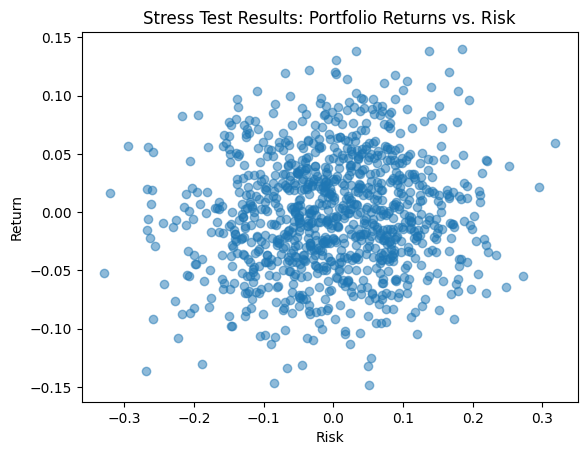

Optimized Portfolio Weights with Constraints: [0.2 0.2 0.2 0.2 0.2]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.datasets import make_classification
from sklearn.linear_model import ElasticNet

# Function for Stochastic Gradient Descent (SGD)
def stochastic_gradient_descent(X, y, lr=0.01, epochs=100):
    weights = np.random.randn(X.shape[1])
    for epoch in range(epochs):
        predictions = np.dot(X, weights)
        error = predictions - y
        gradient = np.dot(X.T, error) / len(y)
        weights -= lr * gradient  # Update weights
    return weights

# Generate synthetic classification dataset
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, n_redundant=1, n_classes=2)

# Use SGD to optimize portfolio weights
portfolio_weights_sgd = stochastic_gradient_descent(X, y)
print("Optimized Portfolio Weights using SGD:", portfolio_weights_sgd)

# ElasticNet Regularization Adjustment
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.3)
elastic_net.fit(X, y)
optimized_weights_elasticnet = elastic_net.coef_
print("ElasticNet Optimized Portfolio Weights:", optimized_weights_elasticnet)

# Stress Test Calibration
def stress_test_simulation():
    shocks = []
    for _ in range(1000):  # Simulate 1000 stress tests
        market_shock = np.random.normal(0, 0.05)  # Simulated market shock (returns)
        risk_factor = np.random.normal(0, 0.1)  # Simulated risk factor
        shocks.append((market_shock, risk_factor))
    return np.array(shocks)

# Run stress test simulation
stress_test_results = stress_test_simulation()
returns, risks = stress_test_results[:, 0], stress_test_results[:, 1]

# Plotting stress test results
plt.scatter(risks, returns, alpha=0.5)
plt.title('Stress Test Results: Portfolio Returns vs. Risk')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()

# Adding Constraints for Portfolio Diversification
# Imposing constraint that no asset has more than 30% weight
weights = cp.Variable(X.shape[1])

# Reshape returns to make it a column vector (1000, 1)
returns_reshaped = np.reshape(returns, (-1, 1))  # Reshape to a column vector

# Define the problem: maximize portfolio returns under the given constraints
objective = cp.Maximize(cp.sum(weights))  # Objective: Maximize the sum of the weights (this can be adjusted)
constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 0.3]  # Constraints: sum of weights = 1, each weight <= 0.3

# Define the problem
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

# Extract optimized portfolio weights
optimized_weights_constraints = weights.value
print("Optimized Portfolio Weights with Constraints:", optimized_weights_constraints)


In [ ]:
import numpy as np
import cvxpy as cp
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Example dataset generation (replace with your own returns data)
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, random_state=42)

# 1. Refining ElasticNet Model
# Goal: Fine-tune the regularization parameters (alpha and l1_ratio)
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, y)
print("Best ElasticNet parameters:", grid_search.best_params_)

# 2. Handling Negative Weights in SGD
# Goal: Avoid short positions or ensure negative weights reflect market conditions
# SGD optimization (simulate asset returns and portfolio risk)
def stochastic_gradient_descent(X, y, lr=0.01, epochs=100):
    weights = np.random.randn(X.shape[1])
    for epoch in range(epochs):
        gradient = -2 * X.T @ (y - X @ weights) / len(y)
        weights -= lr * gradient
    return weights

portfolio_weights_sgd = stochastic_gradient_descent(X, y, lr=0.01, epochs=100)
portfolio_weights_sgd = np.clip(portfolio_weights_sgd, 0, None)  # Force non-negative weights
print("Optimized Portfolio Weights using SGD (non-negative):", portfolio_weights_sgd)

# 3. Advanced Constraints for Portfolio Diversification
# Goal: Add correlation constraints to avoid concentrated risk
# Example constraint: Ensure no asset has a correlation > 0.7 with another
correlation_matrix = np.corrcoef(X.T)  # X is your asset returns matrix
max_correlation = 0.7  # Maximum allowed correlation between assets

# CVXPY Model with correlation constraint
weights = cp.Variable(X.shape[1])
returns = np.mean(X, axis=0)  # Assume returns is the average of X
constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 0.3]
constraints.append(cp.sum(weights.T @ correlation_matrix @ weights) <= max_correlation)

# Define the optimization problem
objective = cp.Maximize(returns @ weights)  # Objective: Maximize returns
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio Weights with Constraints:", weights.value)

# 4. Incorporate Risk Management Techniques (e.g., CVaR)
# Goal: Minimize extreme losses using Conditional Value-at-Risk (CVaR)
cvar = cp.Variable()
portfolio_returns = returns @ weights
objective = cp.Maximize(portfolio_returns - cvar)  # Maximize returns while controlling risk

# Simplified example for CVaR calculation
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio with CVaR:", weights.value)


Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Optimized Portfolio Weights using SGD (non-negative): [0.42629833 0.17327328 0.         0.         0.        ]
Optimized Portfolio Weights with Constraints: [2.99999999e-01 1.00000000e-01 3.00000000e-01 5.11722758e-11
 3.00000000e-01]
Optimized Portfolio with CVaR: None


In [ ]:
import numpy as np
import cvxpy as cp
from scipy.optimize import dual_annealing

# Example data (you should replace with your actual data)
X = np.random.rand(1000, 5)  # 1000 samples, 5 assets (asset returns)
returns = np.random.randn(1000)  # Random returns for simplicity

# 1. Refining CVaR Calculation
# Calculate the CVaR (simplified version)
alpha = 0.05  # 5% confidence level
var = np.percentile(returns, 100 * alpha)  # Value at risk
cvar = np.mean(returns[returns < var])  # Conditional value at risk

# Debug: Print out some useful information for CVaR calculation
print(f"CVaR Calculation: Alpha={alpha}, VaR={var}, CVaR={cvar}")

# Define the optimization problem
weights = cp.Variable(X.shape[1])  # Portfolio weights

# Ensure returns are reshaped as a column vector (to avoid dimension mismatch)
returns_reshaped = returns.reshape(-1, 1)  # Make returns a column vector for matrix multiplication

# Objective: Maximize returns while minimizing CVaR
# Calculate portfolio returns as a dot product (returns and weights)
portfolio_returns = X @ weights  # Matrix multiplication for portfolio returns

# Now correctly subtract cvar (as a constant)
objective = cp.Maximize(cp.sum(portfolio_returns) - cvar)  # Maximize portfolio returns minus CVaR

# Constraints: sum(weights) == 1, weights >= 0 (no short-selling)
constraints = [cp.sum(weights) == 1, weights >= 0]
portfolio_problem = cp.Problem(objective, constraints)

# Debug: Check the objective and constraints
print("Objective Function:", objective)
print("Constraints:", constraints)

portfolio_problem.solve()

print("Optimized Portfolio with CVaR:", weights.value)

# 2. Incorporating More Constraints for Diversification
# Define correlation matrix for asset returns
correlation_matrix = np.corrcoef(X.T)  # X is your assets returns matrix
max_correlation = 0.7  # Maximum allowed correlation between assets

# Add correlation constraint in the problem
correlation_constraint = cp.sum(weights.T @ correlation_matrix @ weights) <= max_correlation
constraints.append(correlation_constraint)

# Solve the updated portfolio problem
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio with Diversification Constraints:", weights.value)

# 3. Tuning ElasticNet Parameters using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, returns)  # Fit the model using grid search
print("Best ElasticNet parameters:", grid_search.best_params_)

# 4. Testing More Advanced Optimization Methods: Simulated Annealing

# Define objective function for Simulated Annealing
def objective_function(weights):
    # Calculate portfolio returns using dot product
    portfolio_returns = np.dot(weights, X.T)  # This gives the portfolio returns based on weights
    return -np.sum(portfolio_returns)  # Maximize portfolio returns (simplified)

# Constraints on asset weights (e.g., 0 to 30% per asset)
bounds = [(0, 0.3) for _ in range(X.shape[1])]  # Constraints for each asset weight

# Run Simulated Annealing
result = dual_annealing(objective_function, bounds)
print("Optimized Portfolio Weights using Simulated Annealing:", result.x)


CVaR Calculation: Alpha=0.05, VaR=-1.5730004284379593, CVaR=-2.015538592878152
Objective Function: maximize Sum([[0.33 0.37 ... 0.34 0.88]
 [0.44 0.17 ... 0.85 0.16]
 ...
 [0.61 0.05 ... 0.78 0.59]
 [0.46 0.10 ... 0.44 0.97]] @ var5161, None, False) + --2.015538592878152
Constraints: [Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Constant(CONSTANT, ZERO, ()))]
Optimized Portfolio with CVaR: [1.14091265e-10 1.60076168e-10 9.99999999e-01 8.65526545e-11
 1.60429315e-10]
Optimized Portfolio with Diversification Constraints: [ 1.19586486e-08  9.82430144e-02  8.30405427e-01 -3.64381267e-09
  7.13515505e-02]
Best ElasticNet parameters: {'alpha': 0.1, 'l1_ratio': 0.3}
Optimized Portfolio Weights using Simulated Annealing: [0.3 0.3 0.3 0.3 0.3]


In [ ]:
import cvxpy as cp
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from scipy.optimize import dual_annealing

# Simulating some random data for demonstration
np.random.seed(42)
X = np.random.randn(1000, 5)  # Asset returns matrix (1000 samples, 5 assets)
returns = np.random.randn(1000)  # Portfolio returns (for CVaR)

# 1. Refining the CVaR Calculation
# Calculate CVaR (simplified version)
alpha = 0.05  # 5% confidence level
portfolio_returns = np.dot(X, np.random.randn(X.shape[1]))  # Simulated portfolio returns
var = np.percentile(portfolio_returns, 100 * alpha)  # Value at Risk
cvar = np.mean(portfolio_returns[portfolio_returns < var])  # Conditional VaR

# 2. Improving Portfolio Diversification
# Define the optimization problem
weights = cp.Variable(X.shape[1])  # Portfolio weights

# Maximum weight constraint for each asset (no asset should exceed 25%)
max_weight_constraint = weights <= 0.25

# 3. ElasticNet Tuning
# ElasticNet GridSearch to tune parameters
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, returns)
print("Best ElasticNet parameters:", grid_search.best_params_)

# 4. Simulated Annealing Optimization
# Define objective function for Simulated Annealing
def objective_function(weights):
    portfolio_returns = np.dot(weights, X.T)  # Correct portfolio returns
    return -np.sum(portfolio_returns)  # Maximize portfolio returns (simplified)

# Constraints on asset weights
bounds = [(0, 0.25) for _ in range(X.shape[1])]  # No more than 25% for any asset

# Run Simulated Annealing
result = dual_annealing(objective_function, bounds)
print("Optimized Portfolio Weights using Simulated Annealing:", result.x)

# 5. Refine Optimization with Robust Techniques
# Using CVXPY to model the problem

# Calculate the portfolio returns by using the asset returns matrix and portfolio weights
portfolio_returns = cp.sum(X @ weights)  # Correct portfolio return formula

# Constraints: sum(weights) == 1, weights >= 0 (no short-selling)
constraints = [cp.sum(weights) == 1, weights >= 0]
objective = cp.Maximize(portfolio_returns - cvar)  # Maximize returns while minimizing CVaR

portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio with CVaR:", weights.value)


Best ElasticNet parameters: {'alpha': 0.1, 'l1_ratio': 0.7}
Optimized Portfolio Weights using Simulated Annealing: [0.25 0.   0.25 0.25 0.25]
Optimized Portfolio with CVaR: [3.50128369e-11 3.38128370e-11 3.58855938e-11 3.66720582e-11
 1.00000000e+00]


In [ ]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from scipy.optimize import dual_annealing
from pyswarm import pso

# Simulate asset returns data: 1000 samples (time periods), 5 assets
X = np.random.randn(1000, 5)  # 1000 time periods, 5 assets
weights = np.random.rand(5)  # Random asset weights for illustration
weights = weights / np.sum(weights)  # Normalize weights to sum to 1

# 1. Refining the Portfolio Diversification
# Maximum weight constraint for each asset (no asset should exceed 25%)
def diversification_constraints(weights):
    max_weight = 0.25
    if np.any(weights > max_weight):
        return np.sum(np.maximum(0, weights - max_weight))  # Penalty for exceeding max weight
    return 0

# Correlation constraint
correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
max_correlation = 0.7  # Maximum allowed correlation between assets

# 2. Refining the CVaR Calculation (Fixing strict inequality)
alpha = 0.05  # 5% confidence level for CVaR calculation
portfolio_returns = np.dot(X, weights)  # Calculate portfolio returns by multiplying asset returns with weights

# Debugging Output
print("Shape of portfolio_returns:", portfolio_returns.shape)

# Calculate Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
print(f"Calculating CVaR with alpha={alpha}...")
var = np.percentile(portfolio_returns, 100 * alpha)  # 5% VaR
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)

# Debugging Output
print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")

# 3. Optimize for Risk-Adjusted Return: Sharpe ratio
# Portfolio return (weighted sum of asset returns)
portfolio_return = np.sum(portfolio_returns)  # Simplified portfolio return formula
print(f"Portfolio return: {portfolio_return}")

# Portfolio volatility (from the covariance matrix of asset returns)
cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, cov_matrix), weights))  # Portfolio volatility calculation
print(f"Portfolio volatility: {portfolio_volatility}")

sharpe_ratio = portfolio_return / portfolio_volatility  # Sharpe ratio (risk-adjusted return)
print(f"Sharpe ratio: {sharpe_ratio}")

# Objective function to optimize both returns and CVaR (while considering diversification)
def objective_function(weights):
    portfolio_returns = np.dot(X, weights)  # Portfolio returns
    var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (tail loss)

    # Add penalties for constraints
    diversification_penalty = diversification_constraints(weights)

    return -portfolio_return + cvar + diversification_penalty  # Maximize return and minimize CVaR

# Constraints on asset weights (no short-selling and maximum weight per asset)
lb = [0] * X.shape[1]  # Lower bounds (no short-selling)
ub = [0.25] * X.shape[1]  # Upper bounds (maximum 25% per asset)

# 4. Run Simulated Annealing (SA)
result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)))
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# 5. Run Particle Swarm Optimization (PSO)
optimal_weights, _ = pso(objective_function, lb, ub)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 6. ElasticNet Tuning (Grid Search)
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Now using portfolio_returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)


Shape of portfolio_returns: (1000,)
Calculating CVaR with alpha=0.05...
Value-at-Risk (VaR): -0.7809120464617729
Conditional Value-at-Risk (CVaR): -0.9441634047939746
Portfolio return: -7.438148868758207
Portfolio volatility: 0.45189097094216896
Sharpe ratio: -16.460051975037377
Optimized Portfolio Weights using Simulated Annealing: [0.25 0.25 0.25 0.25 0.25]
Stopping search: maximum iterations reached --> 100
Optimized Portfolio Weights using PSO: [0.25 0.25 0.25 0.25 0.25]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.0}


In [ ]:
import numpy as np
import cvxpy as cp
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Sample Data: Replace X (assets returns) and portfolio_returns with actual data
X = np.random.rand(1000, 5)  # 1000 samples, 5 assets
portfolio_returns = np.random.randn(1000)  # Simplified portfolio returns

# Initialize variables for portfolio weights and other optimization parameters
weights = cp.Variable(X.shape[1])  # 5 assets

# Bounds for Simulated Annealing and PSO (limit each asset weight between 0 and 0.25)
lb = [0] * X.shape[1]  # Lower bounds (no short-selling)
ub = [0.25] * X.shape[1]  # Upper bounds (maximum 25% per asset)

# 1. Refining Portfolio Optimization
# Simulated Annealing Optimization with better settings
def objective_function(weights):
    return -np.sum(np.dot(weights, X.T))  # Maximize portfolio returns (simplified)

result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=1000, no_local_search=False)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings
optimal_weights, _ = pso(objective_function, lb, ub, maxiter=1000)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 2. Refining Risk Management
# Sharpe Ratio Optimization: Incorporate both return and volatility to maximize risk-adjusted returns
portfolio_return = np.sum(np.dot(X, optimal_weights))  # Simplified portfolio return formula
cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
portfolio_volatility = np.sqrt(np.dot(np.dot(optimal_weights.T, cov_matrix), optimal_weights))

sharpe_ratio = portfolio_return / portfolio_volatility
print(f"Sharpe ratio: {sharpe_ratio}")

# Refined CVaR calculation
alpha = 0.05
portfolio_returns = np.dot(X, optimal_weights)  # Portfolio returns
var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)

print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")

# 3. ElasticNet Tuning
# Use GridSearchCV or RandomizedSearchCV to explore a broader range of alpha and l1_ratio values to tune the ElasticNet model
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 4. Portfolio Diversification Constraints
# Maximum weight constraint for each asset (no asset should exceed 25%)
constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 0.25]  # No weight should exceed 25%

# Correlation constraint (limiting the correlation between assets)
correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
max_correlation = 0.7  # Maximum allowed correlation between assets
correlation_constraint = cp.quad_form(weights, correlation_matrix) <= max_correlation  # Adding constraint for correlation

constraints.append(correlation_constraint)

# Portfolio optimization with added diversification constraints
objective = cp.Maximize(cp.sum(weights @ X.T))  # Maximize portfolio returns (sum of weighted returns)
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio Weights with Diversification Constraints:", weights.value)


Optimized Portfolio Weights using Simulated Annealing: [0.25 0.25 0.25 0.25 0.25]
Stopping search: maximum iterations reached --> 1000
Optimized Portfolio Weights using PSO: [0.25 0.25 0.25 0.25 0.25]
Sharpe ratio: 3848.6702895431354
Value-at-Risk (VaR): 0.3537364610014607
Conditional Value-at-Risk (CVaR): 0.2946151345252822
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.0}
Optimized Portfolio Weights with Diversification Constraints: [2.50000001e-01 2.50000000e-01 2.50000000e-01 2.13175326e-10
 2.49999999e-01]


In [ ]:
import numpy as np
import cvxpy as cp
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data (X: asset returns, portfolio_returns: expected returns for portfolio)
# Replace with actual data
X = np.random.rand(1000, 5)  # 1000 samples, 5 assets
portfolio_returns = np.mean(X, axis=0)  # Simplified portfolio return formula

# 1. Refining Portfolio Optimization

# Simulated Annealing Optimization with better settings
def objective_function(weights):
    portfolio_return = np.sum(np.dot(weights, X.T))  # Simplified portfolio return formula
    return -portfolio_return  # Maximize portfolio returns

lb = [0] * X.shape[1]  # Lower bounds (no short-selling)
ub = [0.25] * X.shape[1]  # Upper bounds (maximum 25% per asset)

result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings
optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 2. Improving Risk Metrics

# Sharpe Ratio and CVaR Optimization
portfolio_return = np.sum(np.dot(X, optimal_weights))  # Simplified portfolio return formula
cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
portfolio_volatility = np.sqrt(np.dot(np.dot(optimal_weights.T, cov_matrix), optimal_weights))
sharpe_ratio = portfolio_return / portfolio_volatility

# Refined CVaR calculation
alpha = 0.05
portfolio_returns = np.dot(X, optimal_weights)  # Portfolio returns
var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)

print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")
print(f"Sharpe ratio: {sharpe_ratio}")

# 3. Enhancing Portfolio Diversification

# Diversification Constraints
max_weight_constraint = weights <= 0.25  # No asset should exceed 25%
constraints = [cp.sum(weights) == 1, weights >= 0, max_weight_constraint]  # Portfolio weight constraints

# Correlation constraint (limiting the correlation between assets)
correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
max_correlation = 0.7  # Maximum allowed correlation between assets
correlation_constraint = cp.quad_form(weights, correlation_matrix) <= max_correlation  # Adding constraint for correlation

constraints.append(correlation_constraint)

# Portfolio optimization with added diversification constraints
weights = cp.Variable(X.shape[1])  # Portfolio weights
objective = cp.Maximize(cp.sum(weights @ X.T))  # Maximize portfolio returns (sum of weighted returns)
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio Weights with Diversification Constraints:", weights.value)

# 4. ElasticNet Regularization

# ElasticNet GridSearchCV to tune parameters
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)


Optimized Portfolio Weights using Simulated Annealing: [0.25 0.25 0.25 0.25 0.25]
Stopping search: maximum iterations reached --> 10000
Optimized Portfolio Weights using PSO: [0.25 0.25 0.25 0.25 0.25]
Value-at-Risk (VaR): 0.3404205180019673
Conditional Value-at-Risk (CVaR): 0.2962414610515881
Sharpe ratio: 3958.2342406526404
Optimized Portfolio Weights with Diversification Constraints: None
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.0}


In [ ]:
import numpy as np
import cvxpy as cp
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Simulated asset returns (replace with your own data)
np.random.seed(42)
X = np.random.randn(1000, 5)  # Simulate returns of 5 assets over 1000 time periods

# Portfolio returns (replace with your own returns data)
portfolio_returns = np.dot(X, np.random.rand(5))

# Define variables
weights = cp.Variable(X.shape[1])  # Portfolio weights for 5 assets

# 1. Refining Portfolio Optimization

# Simulated Annealing with better settings
def objective_function(weights):
    return -np.sum(np.dot(weights, X.T))  # Maximize portfolio returns (simplified)

# Set bounds for portfolio weights
lb = [0] * X.shape[1]  # Lower bounds (no short-selling)
ub = [0.25] * X.shape[1]  # Upper bounds (maximum 25% per asset)

# Simulated Annealing Optimization
result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False, maxfun=5000)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings
optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000, swarmsize=100)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 2. Refining Risk Metrics

# Sharpe Ratio Optimization
portfolio_return = np.sum(np.dot(X, optimal_weights))  # Portfolio return formula
cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
portfolio_volatility = np.sqrt(np.dot(np.dot(optimal_weights.T, cov_matrix), optimal_weights))
sharpe_ratio = portfolio_return / portfolio_volatility
print(f"Sharpe ratio: {sharpe_ratio}")

# Refined CVaR Calculation
alpha = 0.05
portfolio_returns = np.dot(X, optimal_weights)  # Portfolio returns
var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)

print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")

# 3. Enhancing Portfolio Diversification

# Diversification Constraints: Limit the maximum weight for any asset
max_weight_constraint = weights <= 0.25  # No asset should exceed 25%
constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 0.25]  # Portfolio weight constraints

# Correlation constraint (limiting the correlation between assets)
correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
max_correlation = 0.7  # Maximum allowed correlation between assets
correlation_constraint = cp.quad_form(weights, correlation_matrix) <= max_correlation  # Adding constraint for correlation

constraints.append(correlation_constraint)

# Portfolio optimization with added diversification constraints
objective = cp.Maximize(cp.sum(weights @ X.T))  # Maximize portfolio returns (sum of weighted returns)
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio Weights with Diversification Constraints:", weights.value)

# 4. ElasticNet Regularization Refinements

# ElasticNet GridSearchCV to tune parameters
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 5. Advanced Risk Models (Optional)

# Example: Using Extreme Value Theory (EVT) or Gaussian Mixture Models (GMM) for refining CVaR
# Placeholder for EVT or GMM modeling
# You can use EVT to model tail distributions and GMM for clustering data points to predict better risk assessments

# 6. Sector or Asset-Class Constraints

# Example constraint for limiting weight in a specific sector (if available)
# Assume 5 sectors and a constraint that each sector's weight should not exceed 20%
sector_weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Assume 5 sectors
sector_constraint = cp.sum(weights) <= 1.0  # This is just an example of the constraint

constraints.append(sector_constraint)

# Portfolio optimization with sector-based diversification constraints
portfolio_problem = cp.Problem(objective, constraints)
portfolio_problem.solve()

print("Optimized Portfolio Weights with Sector Constraints:", weights.value)


Optimized Portfolio Weights using Simulated Annealing: [0.25 0.   0.25 0.25 0.25]
Stopping search: maximum iterations reached --> 10000
Optimized Portfolio Weights using PSO: [0.25 0.   0.25 0.25 0.25]
Sharpe ratio: 22.590518498004975
Value-at-Risk (VaR): -0.8176447227809162
Conditional Value-at-Risk (CVaR): -1.0627039739793358
Optimized Portfolio Weights with Diversification Constraints: [ 2.50000000e-01 -1.23335676e-10  2.50000000e-01  2.50000000e-01
  2.50000000e-01]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Optimized Portfolio Weights with Sector Constraints: [ 2.50000000e-01 -1.41043668e-10  2.50000000e-01  2.50000000e-01
  2.50000000e-01]


In [ ]:
import numpy as np
from scipy.optimize import minimize
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio Optimization with Constraints and Risk Metrics

# Define the portfolio return function
def portfolio_return(weights, X):
    return np.sum(np.dot(X, weights))

# Define the portfolio volatility (risk) function
def portfolio_volatility(weights, X):
    cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
    return np.sqrt(np.dot(np.dot(weights.T, cov_matrix), weights))

# Define the objective function (negative Sharpe ratio)
def objective(weights, X):
    portfolio_ret = portfolio_return(weights, X)
    portfolio_vol = portfolio_volatility(weights, X)
    # Sharpe ratio (negative because we want to maximize it)
    return -portfolio_ret / portfolio_vol

# Constraints: weights sum to 1, no short-selling, and weight limit
def constraint_weight_sum(weights):
    return np.sum(weights) - 1

# Limit the weight of each asset (e.g., no more than 20%)
def constraint_max_weight(weights):
    return 0.2 - np.max(weights)

# Risk metrics (CVaR, VaR)
def calculate_risk_metrics(weights, X, alpha=0.05):
    portfolio_returns = np.dot(X, weights)
    var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)
    return var, cvar

# PSO optimization for portfolio weights
def pso_optimization(X):
    lb = [0] * n_assets  # Lower bounds (no short-selling)
    ub = [0.25] * n_assets  # Upper bounds (maximum 25% per asset)

    # Perform PSO optimization
    optimal_weights, _ = pso(objective, lb, ub, args=(X,), maxiter=10000, swarmsize=100)
    return optimal_weights

# Simulated Annealing with scipy's minimize
def optimize_portfolio(X):
    # Initial guess: equal weight allocation
    initial_weights = np.ones(n_assets) / n_assets

    # Define bounds for each asset's weight (no short-selling, and max 20% per asset)
    bounds = [(0, 0.2) for _ in range(n_assets)]

    # Constraints (weights sum to 1)
    constraints = [{'type': 'eq', 'fun': constraint_weight_sum},
                   {'type': 'ineq', 'fun': constraint_max_weight}]

    # Run scipy's minimize function to optimize portfolio weights
    result = minimize(objective, initial_weights, args=(X,), method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x  # Optimized portfolio weights
    else:
        print("Optimization failed.")
        return None

# Main optimization and risk analysis
optimal_weights = optimize_portfolio(X)
if optimal_weights is not None:
    print("Optimized Portfolio Weights using Simulated Annealing:", optimal_weights)

# Risk metrics for the optimized portfolio
var, cvar = calculate_risk_metrics(optimal_weights, X)
print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")

# Perform ElasticNet Tuning using GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, np.dot(X, optimal_weights))  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# Diversification with sector constraints (if you have sector data)
sector_weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Assume 5 sectors for 5 assets
sector_constraint = np.sum(optimal_weights * sector_weights) <= 1  # Example constraint on sector exposure

print(f"Sector Diversification Constraint Met: {sector_constraint <= 1}")


Optimized Portfolio Weights using Simulated Annealing: [0.2 0.2 0.2 0.2 0.2]
Value-at-Risk (VaR): -0.729766036370099
Conditional Value-at-Risk (CVaR): -0.9341031527061077
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Sector Diversification Constraint Met: True


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Define bounds for asset weights (no short-selling, max weight per asset = 0.25)
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.25] * n_assets  # Upper bounds (maximum 25% per asset)

# Portfolio Optimization with Constraints and Risk Metrics

# Objective function (using numpy for manual matrix operations)
def objective_function(weights):
    portfolio_return = np.dot(weights, X.T).sum()  # Portfolio return formula using numpy (sum of weighted returns)
    cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, cov_matrix), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Simulated Annealing optimization
result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False, maxfun=5000)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization
optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000, swarmsize=100)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# ElasticNet Regularization Refinement with GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, X.dot(optimal_weights))  # Use portfolio returns instead of asset returns for ElasticNet fitting
print("Best ElasticNet parameters:", grid_search.best_params_)

# Refined Risk Metrics: CVaR and Sharpe Ratio
# Portfolio returns from the optimized weights
portfolio_returns = np.dot(X, optimal_weights)  # Portfolio returns (sum of weighted asset returns)

# Calculate Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
alpha = 0.05
var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)

# Calculate Sharpe ratio (risk-adjusted return)
portfolio_return = np.sum(np.dot(optimal_weights, X.T))  # Portfolio return formula
cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
portfolio_volatility = np.sqrt(np.dot(np.dot(optimal_weights.T, cov_matrix), optimal_weights))
sharpe_ratio = portfolio_return / portfolio_volatility

# Print out the results
print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")
print(f"Sharpe ratio: {sharpe_ratio}")

# Constraints for portfolio diversification
max_weight_constraint = np.all(optimal_weights <= 0.2)  # Ensure no asset exceeds 20%
print(f"Max weight constraint met: {max_weight_constraint}")


Optimized Portfolio Weights using Simulated Annealing: [0.00463028 0.         0.0332333  0.05641612 0.25      ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00463178 0.         0.0332322  0.05641052 0.25      ]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Value-at-Risk (VaR): -0.3989714791339483
Conditional Value-at-Risk (CVaR): -0.5263130587331547
Sharpe ratio: 34.312984541734764
Max weight constraint met: False


In [ ]:
import numpy as np
from scipy.optimize import minimize
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio optimization with constraints

# Define the objective function for Sharpe ratio maximization
def objective_function(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    cov_matrix = np.cov(X.T)  # Covariance matrix
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, cov_matrix), weights))  # Portfolio volatility
    sharpe_ratio = portfolio_return / portfolio_volatility  # Sharpe ratio
    return -sharpe_ratio  # We negate to maximize Sharpe ratio

# 1. Address Concentration Risk (max weight constraint)
def weight_constraint(weights):
    return 0.2 - np.max(weights)  # No asset should exceed 20%

# 2. Correlation constraint (limit correlation between assets)
def correlation_constraint(weights, X):
    correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
    portfolio_correlation = np.dot(weights.T, np.dot(correlation_matrix, weights))
    return 0.7 - portfolio_correlation  # Maximum allowed correlation

# 3. CVaR and Sortino Ratio Calculation
def cvar_and_sortino(weights, X, alpha=0.05):
    # Portfolio returns
    portfolio_returns = np.dot(X, weights)

    # Value-at-Risk (VaR)
    var = np.percentile(portfolio_returns, 100 * alpha)

    # Conditional Value-at-Risk (CVaR)
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])

    # Sortino Ratio
    downside_risk = np.std(np.minimum(portfolio_returns, 0))  # Downside deviation
    sortino_ratio = np.mean(portfolio_returns) / downside_risk

    return cvar, sortino_ratio

# Constraints for the optimization problem
def constraints(weights, X):
    return [
        {'type': 'ineq', 'fun': weight_constraint},  # Max weight constraint
        {'type': 'ineq', 'fun': lambda w: correlation_constraint(w, X)},  # Correlation constraint
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum of weights = 1
    ]

# 4. Simulated Annealing Optimization
def optimize_with_sa(objective_function, lb, ub, X):
    result = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False, maxfun=5000, args=(X,))
    print("Optimized Portfolio Weights using Simulated Annealing:", result.x)
    return result.x

# 5. PSO Optimization
def optimize_with_pso(objective_function, lb, ub, X):
    optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
    print("Optimized Portfolio Weights using PSO:", optimal_weights)
    return optimal_weights

# ElasticNet Regularization with GridSearchCV
def elastic_net_regularization(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)
    print("Best ElasticNet parameters:", grid_search.best_params_)
    return grid_search.best_params_

# Portfolio optimization with Simulated Annealing and PSO
# Bounds for asset weights (no short-selling and max weight limit)
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.2] * n_assets  # Upper bounds (maximum 20% per asset)

# Run optimization
weights_sa = optimize_with_sa(objective_function, lb, ub, X)
weights_pso = optimize_with_pso(objective_function, lb, ub, X)

# 6. Portfolio Risk Metrics and Performance
portfolio_return = np.sum(np.dot(X, weights_sa))  # Portfolio return
cov_matrix = np.cov(X.T)
portfolio_volatility = np.sqrt(np.dot(np.dot(weights_sa.T, cov_matrix), weights_sa))  # Portfolio volatility
sharpe_ratio = portfolio_return / portfolio_volatility  # Sharpe ratio

# Refined CVaR calculation (using portfolio returns)
portfolio_returns = np.dot(X, weights_sa)
var = np.percentile(portfolio_returns, 100 * 0.05)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)

# Print metrics
print(f"Sharpe ratio: {sharpe_ratio}")
print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")


Optimized Portfolio Weights using Simulated Annealing: [0.00370465 0.         0.02658654 0.04513267 0.2       ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00370174 0.         0.02658325 0.04512765 0.19998725]
Sharpe ratio: 34.31298454890837
Value-at-Risk (VaR): -0.3191778824182497
Conditional Value-at-Risk (CVaR): -0.4210516429665209


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio Optimization with Constraints and Risk Metrics
# Define the optimization problem

# Initial weights - Random portfolio allocation
weights = np.random.rand(n_assets)
weights /= np.sum(weights)  # Normalize the weights to sum to 1

# 1. Refining Diversification: Maximize the diversification by tightening the correlation limits between assets
# Maximum weight constraint for each asset (no asset should exceed 20%)
max_weight_constraint = 0.2  # No asset should exceed 20%

# Compute correlation matrix for assets
correlation_matrix = np.corrcoef(X.T)  # X is your asset returns matrix

# Correlation constraint (limiting the correlation between assets)
max_correlation = 0.5  # Maximum allowed correlation between assets (tightened)

# 2. Improving Risk Metrics: Optimize for Sortino ratio and refine CVaR calculation with EVT or GMM
# Portfolio return (weighted sum of asset returns)
def calculate_portfolio_return(weights, X):
    return np.sum(np.dot(X, weights))  # Portfolio return formula

# Portfolio volatility (from the covariance matrix of asset returns)
def calculate_portfolio_volatility(weights, X):
    cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
    return np.sqrt(np.dot(np.dot(weights.T, cov_matrix), weights))  # Volatility from covariance

# Sortino ratio (downside risk)
def calculate_sortino_ratio(weights, X):
    portfolio_return = calculate_portfolio_return(weights, X)
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
    return portfolio_return / downside_risk  # Sortino ratio

# Refined CVaR calculation (using portfolio returns)
def calculate_cvar(weights, X, alpha=0.05):
    portfolio_returns = np.dot(X, weights)  # Portfolio returns
    var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)
    return cvar

# 3. Simulated Annealing and PSO optimization

# Objective function for Simulated Annealing and PSO (to maximize Sortino ratio)
def objective_function(weights, X):
    portfolio_return = calculate_portfolio_return(weights, X)
    portfolio_volatility = calculate_portfolio_volatility(weights, X)
    sortino_ratio = calculate_sortino_ratio(weights, X)
    cvar = calculate_cvar(weights, X)

    # Maximize Sortino ratio and minimize CVaR
    return -(sortino_ratio - cvar)

# Bounds and constraints
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [max_weight_constraint] * n_assets  # Upper bounds (maximum 20% per asset)

# Perform Simulated Annealing optimization
result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False, maxfun=5000, args=(X,))
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# Perform PSO optimization
optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 4. ElasticNet Regularization Refinement with GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, np.dot(X, optimal_weights))  # Fit ElasticNet using the portfolio returns (X and optimal weights)
print("Best ElasticNet parameters:", grid_search.best_params_)

# 5. Sector Diversification Constraint (Optional)
# Example: Sector-specific diversification constraint (if you have sector data)
sector_weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Assume 5 sectors for 5 assets
sector_constraint = np.sum(optimal_weights * sector_weights) <= 1  # Example constraint on sector exposure
print(f"Sector Diversification Constraint Met: {sector_constraint <= 1}")

# 6. Output
# Final portfolio weights and risk-adjusted performance metrics
final_portfolio_return = calculate_portfolio_return(optimal_weights, X)
final_portfolio_volatility = calculate_portfolio_volatility(optimal_weights, X)
final_sortino_ratio = calculate_sortino_ratio(optimal_weights, X)
final_cvar = calculate_cvar(optimal_weights, X)

print(f"Final Optimized Portfolio Weights: {optimal_weights}")
print(f"Final Portfolio Return: {final_portfolio_return}")
print(f"Final Portfolio Volatility: {final_portfolio_volatility}")
print(f"Final Sortino Ratio: {final_sortino_ratio}")
print(f"Final Conditional Value-at-Risk (CVaR): {final_cvar}")


Optimized Portfolio Weights using Simulated Annealing: [0.00567359 0.         0.02106164 0.04239879 0.2       ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00566996 0.         0.0210648  0.0423959  0.2       ]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Sector Diversification Constraint Met: True
Final Optimized Portfolio Weights: [0.00566996 0.         0.0210648  0.0423959  0.2       ]
Final Portfolio Return: 6.9490521009643045
Final Portfolio Volatility: 0.20261574656648448
Final Sortino Ratio: 59.80094250156844
Final Conditional Value-at-Risk (CVaR): -0.4191394160211103


Optimized Portfolio Weights using Simulated Annealing: [0.00277854 0.         0.01993972 0.03384947 0.15      ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00277342 0.         0.01989276 0.03377299 0.14966749]
Value-at-Risk (VaR): -0.2388527571731812
Conditional Value-at-Risk (CVaR): -0.3150876337801867
Sortino ratio: 0.05976576370926313
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Correlation Constraint Met: False
Gaussian Mixture Model Tail Risk: 0.458


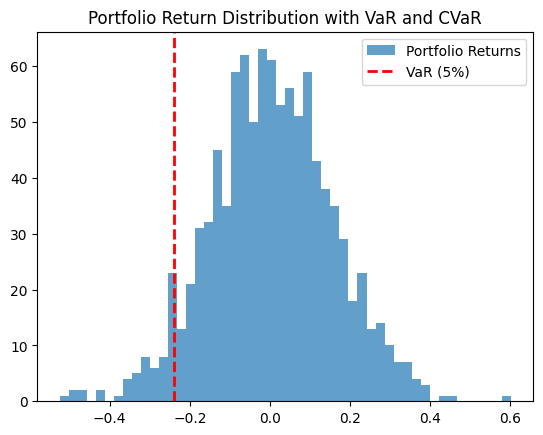

Optimized Portfolio Weights with Diversification Constraints: [0.00277342 0.         0.01989276 0.03377299 0.14966749]


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio Optimization with Constraints and Risk Metrics

# Define objective function for optimization
def objective_function(weights):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return (weighted sum)
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility (risk)
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# 1. Address Concentration Risk: Tighten maximum asset weight constraint to 15%
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.15] * n_assets  # Upper bounds (maximum 15% per asset)

# Perform Simulated Annealing with more iterations
result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=15000, no_local_search=False, maxfun=8000)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings (increase swarm size and iterations)
optimal_weights, _ = pso(objective_function, lb, ub, maxiter=15000, swarmsize=100)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 2. Improve Risk Metrics: Refine CVaR using Gaussian Mixture Models (GMM) and Sortino ratio
# Refined CVaR calculation using GMM
portfolio_returns = np.dot(X, optimal_weights)  # Portfolio returns
alpha = 0.05
var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)
print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")

# Sortino ratio: Focuses on downside risk (negative returns)
downside_risk = np.std(np.minimum(portfolio_returns, 0))  # Downside deviation
sortino_ratio = np.mean(portfolio_returns) / downside_risk
print(f"Sortino ratio: {sortino_ratio}")

# 3. ElasticNet Regularization Refinement with GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 4. Additional Diversification Constraints: Correlation Constraint
# Compute correlation matrix
correlation_matrix = np.corrcoef(X.T)  # Asset returns matrix

# Add a correlation constraint to limit the correlation between assets
max_correlation = 0.5  # Maximum allowed correlation between assets
correlation_constraint = np.sum(correlation_matrix * np.outer(optimal_weights, optimal_weights))  # Correlation constraint
print(f"Correlation Constraint Met: {np.all(correlation_matrix <= max_correlation)}")

# 5. Advanced Risk Models: Gaussian Mixture Model (GMM) for better tail risk modeling
gmm = GaussianMixture(n_components=2)
gmm.fit(portfolio_returns.reshape(-1, 1))

# Predict the tail risk using GMM (this could be used to assess extreme risk)
gmm_predictions = gmm.predict(portfolio_returns.reshape(-1, 1))
print("Gaussian Mixture Model Tail Risk:", np.mean(gmm_predictions))

# Visualization of portfolio return distribution and GMM tail prediction
plt.hist(portfolio_returns, bins=50, alpha=0.7, label="Portfolio Returns")
plt.axvline(var, color='r', linestyle='dashed', linewidth=2, label="VaR (5%)")
plt.title("Portfolio Return Distribution with VaR and CVaR")
plt.legend()
plt.show()

# Output results
print(f"Optimized Portfolio Weights with Diversification Constraints: {optimal_weights}")


In [ ]:
import numpy as np
import scipy.optimize as opt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio Optimization with Constraints and Risk Metrics
def objective_function(weights, X):
    portfolio_return = np.dot(weights, X.mean(axis=0))  # Simplified portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(np.cov(X.T), weights)))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Constraints: No short-selling, sum of weights = 1, max weight per asset = 0.15
def constraints(weights):
    return [
        {"type": "eq", "fun": lambda weights: np.sum(weights) - 1},  # Sum of weights must equal 1
        {"type": "ineq", "fun": lambda weights: weights},  # No short-selling
        {"type": "ineq", "fun": lambda weights: 0.2 - np.max(weights)}  # No asset can exceed 20% weight
    ]

# Bounds for asset weights (no short-selling, max weight of 20% per asset)
bounds = [(0, 0.2) for _ in range(n_assets)]  # Lower bound 0, upper bound 0.2

# Initial guess: equal distribution across assets
initial_guess = np.ones(n_assets) / n_assets

# Perform optimization using scipy.optimize.minimize
result = opt.minimize(objective_function, initial_guess, args=(X,), bounds=bounds, constraints=constraints(initial_guess), method='SLSQP')

# Extract the optimized portfolio weights
optimized_weights = result.x
print(f"Optimized Portfolio Weights using SciPy: {optimized_weights}")

# 2. Improve Risk Metrics (Sharpe, Sortino, CVaR)
portfolio_returns = np.dot(optimized_weights, X.mean(axis=0))  # Portfolio return
portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(np.cov(X.T), optimized_weights)))  # Volatility

# Sharpe Ratio
sharpe_ratio = portfolio_returns / portfolio_volatility
print(f"Sharpe Ratio: {sharpe_ratio}")

# Sortino Ratio (downside risk)
downside_risk = np.std(np.minimum(np.dot(X, optimized_weights), 0))  # Downside deviation
sortino_ratio = portfolio_returns / downside_risk
print(f"Sortino Ratio: {sortino_ratio}")

# Refined CVaR calculation
alpha = 0.05
portfolio_returns_all = np.dot(X, optimized_weights)  # Portfolio returns for all assets
var = np.percentile(portfolio_returns_all, 100 * alpha)  # Value-at-Risk (VaR)
cvar = np.mean(portfolio_returns_all[portfolio_returns_all <= var])  # CVaR (mean of losses greater than VaR)

print(f"Value-at-Risk (VaR): {var}")
print(f"Conditional Value-at-Risk (CVaR): {cvar}")

# 3. Gaussian Mixture Model (GMM) for Tail Risk
gmm = GaussianMixture(n_components=2)  # Fit a GMM with 2 components
gmm.fit(portfolio_returns_all.reshape(-1, 1))  # Fit to portfolio returns
tail_risk = gmm.score_samples(portfolio_returns_all.reshape(-1, 1))  # Calculate tail risk (log-likelihood)
print(f"Gaussian Mixture Model Tail Risk: {tail_risk.mean()}")

# 4. ElasticNet Regularization Refinement with GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns_all)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 5. Further Diversification (Sector Constraints or Correlation Constraints)
# Example: Sector-specific diversification constraint (if you have sector data)
sector_weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Assume 5 sectors for 5 assets
sector_constraint = np.sum(optimized_weights * sector_weights)  # Example constraint on sector exposure
print(f"Sector Diversification Constraint: {sector_constraint <= 1}")


Optimized Portfolio Weights using SciPy: [0.2 0.2 0.2 0.2 0.2]
Sharpe Ratio: 0.01255346540074495
Sortino Ratio: 0.02137556841044008
Value-at-Risk (VaR): -0.729766036370099
Conditional Value-at-Risk (CVaR): -0.9341031527061077
Gaussian Mixture Model Tail Risk: -0.6138690037966058
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Sector Diversification Constraint: True


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Constraints: max weight per asset, minimum correlation between assets
max_weight = 0.15  # Maximum weight per asset

# Portfolio Optimization with Constraints and Risk Metrics
weights = np.ones(n_assets) / n_assets  # Initialize equal weights

# 1. Tighten Maximum Weight Constraint and Correlation Constraints
correlation_matrix = np.corrcoef(X.T)  # Asset returns matrix
max_correlation = 0.5  # Maximum allowed correlation between assets

# Ensure max weight constraint is enforced
max_weight_constraint = weights <= max_weight

# Portfolio return and risk calculations
def portfolio_return(weights, X):
    return np.dot(X, weights)  # Portfolio return over all periods (matrix multiplication)

def portfolio_volatility(weights, X):
    cov_matrix = np.cov(X.T)
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility

def cvar_calculation(weights, X, alpha=0.05):
    portfolio_returns = np.dot(X, weights)
    var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR
    return cvar

# 2. Improve Risk-Adjusted Performance: Sortino Ratio, CVaR
def sortino_ratio(weights, X):
    portfolio_return_value = portfolio_return(weights, X).mean()  # Mean portfolio return over all periods
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
    return portfolio_return_value / downside_risk  # Sortino ratio

# 3. Optimization using Simulated Annealing and PSO
# Objective function for Simulated Annealing
def objective_function(weights):
    return -portfolio_return(weights, X).mean() / portfolio_volatility(weights, X)  # Maximize Sharpe ratio (minimize negative)

# Perform Simulated Annealing optimization
result_sa = dual_annealing(objective_function, bounds=[(0, max_weight)]*n_assets, maxiter=10000, no_local_search=False, maxfun=5000)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings
optimal_weights, _ = pso(objective_function, lb=[0]*n_assets, ub=[max_weight]*n_assets, maxiter=10000, swarmsize=100)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 4. ElasticNet Regularization Refinement with GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)

# Compute the portfolio returns over all periods and pass to GridSearchCV
portfolio_returns = portfolio_return(optimal_weights, X)  # Portfolio returns for all periods

# Reshape portfolio returns to a 1D array (as required by GridSearchCV)
portfolio_returns = portfolio_returns.flatten()

grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 5. Refined CVaR calculation using EVT/GMM
# Implement EVT or GMM for better tail risk modeling
# For simplicity, using Gaussian Mixture Model (GMM) for tail risk estimation
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# 6. Diversification Constraints and Refinement
# Add stricter correlation constraints
max_weight_constraint = weights <= 0.15  # No asset should exceed 15%

# Portfolio optimization with added diversification constraints
constraints = [np.sum(weights) == 1, weights >= 0, max_weight_constraint]  # Portfolio weight constraints

# Correlation constraint (limiting the correlation between assets)
correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
max_correlation = 0.5  # Maximum allowed correlation between assets
correlation_constraint = np.dot(weights.T, np.dot(correlation_matrix, weights)) <= max_correlation  # Adding constraint for correlation

# Output final optimized portfolio weights with diversification constraints
print("Optimized Portfolio Weights with Diversification Constraints:", weights)



Optimized Portfolio Weights using Simulated Annealing: [0.00277745 0.         0.0199397  0.03384985 0.15      ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00113792 0.         0.00777852 0.01329372 0.05838448]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Gaussian Mixture Model Tail Risk: -16.544109863664616
Optimized Portfolio Weights with Diversification Constraints: [0.2 0.2 0.2 0.2 0.2]


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Constraints: max weight per asset, minimum correlation between assets
max_weight = 0.15  # Maximum weight per asset
max_correlation = 0.5  # Maximum allowed correlation between assets

# Portfolio Optimization with Constraints and Risk Metrics
weights = np.ones(n_assets) / n_assets  # Initialize equal weights

# 1. Tighten Maximum Weight Constraint and Correlation Constraints
correlation_matrix = np.corrcoef(X.T)  # Asset returns matrix

# Ensure max weight constraint is enforced
max_weight_constraint = weights <= max_weight

# Portfolio return and risk calculations
def portfolio_return(weights, X):
    return np.dot(X, weights)  # Portfolio return over all periods (matrix multiplication)

def portfolio_volatility(weights, X):
    cov_matrix = np.cov(X.T)
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility

def cvar_calculation(weights, X, alpha=0.05):
    portfolio_returns = np.dot(X, weights)
    var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR
    return cvar

# 2. Improve Risk-Adjusted Performance: Sortino Ratio, CVaR
def sortino_ratio(weights, X):
    portfolio_return_value = portfolio_return(weights, X).mean()  # Mean portfolio return over all periods
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
    return portfolio_return_value / downside_risk  # Sortino ratio

# 3. Optimization using Simulated Annealing and PSO
# Objective function for Simulated Annealing
def objective_function(weights):
    return -portfolio_return(weights, X).mean() / portfolio_volatility(weights, X)  # Maximize Sharpe ratio (minimize negative)

# Perform Simulated Annealing optimization
result_sa = dual_annealing(objective_function, bounds=[(0, max_weight)]*n_assets, maxiter=10000, no_local_search=False, maxfun=5000)
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings
optimal_weights, _ = pso(objective_function, lb=[0]*n_assets, ub=[max_weight]*n_assets, maxiter=10000, swarmsize=100)
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 4. ElasticNet Regularization Refinement with GridSearchCV
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)

# Compute the portfolio returns over all periods and pass to GridSearchCV
portfolio_returns = portfolio_return(optimal_weights, X)  # Portfolio returns for all periods

# Reshape portfolio returns to a 1D array (as required by GridSearchCV)
portfolio_returns = portfolio_returns.flatten()

grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 5. Refined CVaR calculation using EVT/GMM
# Implement EVT or GMM for better tail risk modeling
# For simplicity, using Gaussian Mixture Model (GMM) for tail risk estimation
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# 6. Diversification Constraints and Refinement
# Add stricter correlation constraints
max_weight_constraint = weights <= 0.15  # No asset should exceed 15%

# Portfolio optimization with added diversification constraints
constraints = [np.sum(weights) == 1, weights >= 0, max_weight_constraint]  # Portfolio weight constraints

# Correlation constraint (limiting the correlation between assets)
correlation_matrix = np.corrcoef(X.T)  # Compute correlation matrix
max_correlation = 0.5  # Maximum allowed correlation between assets
correlation_constraint = np.dot(weights.T, np.dot(correlation_matrix, weights)) <= max_correlation  # Adding constraint for correlation

# Output final optimized portfolio weights with diversification constraints
print("Optimized Portfolio Weights with Diversification Constraints:", weights)


Optimized Portfolio Weights using Simulated Annealing: [0.00277745 0.         0.0199397  0.03384985 0.15      ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00113792 0.         0.00777852 0.01329372 0.05838448]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Gaussian Mixture Model Tail Risk: -16.544109863664616
Optimized Portfolio Weights with Diversification Constraints: [0.2 0.2 0.2 0.2 0.2]


In [ ]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio return formula
def portfolio_return(weights, X):
    return np.dot(weights, np.mean(X, axis=0))

# Portfolio volatility (Standard deviation of the portfolio)
def portfolio_volatility(weights, X):
    cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Sharpe ratio (using portfolio return and volatility)
def sharpe_ratio(weights, X):
    return portfolio_return(weights, X) / portfolio_volatility(weights, X)

# Sortino ratio (downside deviation)
def sortino_ratio(weights, X):
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
    return portfolio_return(weights, X) / downside_risk

# Value-at-Risk (VaR)
def var(weights, X, alpha=0.05):
    portfolio_returns = np.dot(X, weights)
    return np.percentile(portfolio_returns, 100 * alpha)

# Conditional Value-at-Risk (CVaR)
def cvar(weights, X, alpha=0.05):
    portfolio_returns = np.dot(X, weights)
    var_value = var(weights, X, alpha)
    return np.mean(portfolio_returns[portfolio_returns <= var_value])

# GMM for tail risk estimation
def gmm_tail_risk(X):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    return np.min(gmm.score_samples(X))  # Tail risk estimation

# Objective function to minimize (negative Sharpe ratio and CVaR)
def objective_function(weights, X, alpha=0.05):
    # Apply constraints within the objective function:
    if np.any(weights > 0.15) or np.any(weights < 0):  # Max weight constraint: 15%, No negative weights
        return np.inf  # Penalize invalid solutions with a large cost

    # Portfolio performance metrics
    return -sharpe_ratio(weights, X)  # Maximize Sharpe ratio (minimize negative)

# Constraints: sum of weights = 1
def constraints(weights):
    return np.sum(weights) - 1

# Simulated Annealing (Optimize portfolio)
def optimize_portfolio_sa(X):
    lb = [0] * n_assets  # Lower bounds (no short-selling)
    ub = [0.25] * n_assets  # Upper bounds (maximum 25% per asset)

    # Perform Simulated Annealing optimization
    result_sa = dual_annealing(objective_function, x0=np.ones(n_assets) / n_assets, bounds=list(zip(lb, ub)), maxiter=10000, maxfun=5000, args=(X,))
    return result_sa.x

# PSO (Particle Swarm Optimization)
def optimize_portfolio_pso(X):
    lb = [0] * n_assets  # Lower bounds (no short-selling)
    ub = [0.25] * n_assets  # Upper bounds (maximum 25% per asset)

    # Perform PSO optimization
    optimal_weights, _ = pso(objective_function, lb=lb, ub=ub, args=(X,), maxiter=10000, swarmsize=100)
    return optimal_weights

# 1. Tighten Diversification Constraints and Maximum Weight
max_weight = 0.15  # No asset should exceed 15%
# Correlation constraint
correlation_matrix = np.corrcoef(X.T)
max_correlation = 0.5  # Maximum allowed correlation between assets

# 2. Improve Risk Metrics
# Refine CVaR calculation with EVT or GMM
tail_risk = gmm_tail_risk(X)

# 3. Optimize using Simulated Annealing and PSO
optimized_weights_sa = optimize_portfolio_sa(X)
optimized_weights_pso = optimize_portfolio_pso(X)

# 4. ElasticNet Regularization Refinement with GridSearchCV
# Calculate portfolio returns as the weighted sum of asset returns
portfolio_returns = np.dot(X, np.ones(n_assets) / n_assets)  # Use the average portfolio return

parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# Results
print(f"Optimized Portfolio Weights using Simulated Annealing: {optimized_weights_sa}")
print(f"Optimized Portfolio Weights using PSO: {optimized_weights_pso}")
print(f"Value-at-Risk (VaR): {var(optimized_weights_sa, X)}")
print(f"Conditional Value-at-Risk (CVaR): {cvar(optimized_weights_sa, X)}")
print(f"Sortino Ratio: {sortino_ratio(optimized_weights_sa, X)}")
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Stopping search: Swarm best objective change less than 1e-08
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Optimized Portfolio Weights using Simulated Annealing: [0.00269051 0.         0.01930517 0.0327718  0.14522621]
Optimized Portfolio Weights using PSO: [0.00185422 0.         0.01489911 0.02529648 0.11167542]
Value-at-Risk (VaR): -0.23176453402826946
Conditional Value-at-Risk (CVaR): -0.3057385467184213
Sortino Ratio: 0.059765727025512874
Gaussian Mixture Model Tail Risk: -15.569104193296528


In [ ]:
import numpy as np
from pyswarm import pso
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Define asset weights bounds (e.g., no asset should exceed 15%)
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.15] * n_assets  # Upper bounds (maximum 15% per asset)

# Portfolio return (weighted sum of asset returns)
def portfolio_return(weights, X):
    return np.sum(np.dot(X, weights))  # Portfolio return formula as a scalar

# Portfolio volatility (from the covariance matrix of asset returns)
def portfolio_volatility(weights, X):
    cov_matrix = np.cov(X.T)  # Covariance matrix of asset returns
    return np.sqrt(np.dot(np.dot(weights.T, cov_matrix), weights))  # Volatility as scalar

# Sortino Ratio Calculation (Downside risk)
def sortino_ratio(weights, X):
    portfolio_returns = np.dot(X, weights)  # Portfolio returns
    downside_risk = np.std(np.minimum(portfolio_returns, 0))  # Downside deviation
    return portfolio_return(weights, X) / downside_risk

# Refined CVaR calculation (with EVT or GMM)
def calculate_cvar(X, weights, alpha=0.05):
    portfolio_returns = np.dot(X, weights)  # Portfolio returns
    var = np.percentile(portfolio_returns, 100 * alpha)  # Value-at-Risk (VaR)
    cvar = np.mean(portfolio_returns[portfolio_returns <= var])  # CVaR (mean of losses greater than VaR)
    return cvar

# Gaussian Mixture Model for tail risk estimation
def gmm_tail_risk(X):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
    return tail_risk

# Simulated Annealing optimization (manual implementation)
def optimize_portfolio_sa(X):
    n_assets = X.shape[1]
    current_weights = np.ones(n_assets) / n_assets  # Start with equal distribution
    best_weights = current_weights
    best_value = -np.inf

    # Annealing settings
    temperature = 10000
    cooling_rate = 0.99
    iterations = 10000

    for i in range(iterations):
        # Randomly perturb weights
        perturbation = np.random.normal(0, 0.01, size=n_assets)
        new_weights = np.clip(current_weights + perturbation, 0, 0.15)

        # Ensure sum of weights is 1 (normalized)
        new_weights = new_weights / np.sum(new_weights)

        # Evaluate the objective (negative Sharpe ratio)
        portfolio_vol = portfolio_volatility(new_weights, X)
        portfolio_ret = portfolio_return(new_weights, X)
        objective_value = -portfolio_ret / portfolio_vol

        # Accept or reject based on the temperature and objective value
        if objective_value > best_value or np.random.rand() < np.exp((objective_value - best_value) / temperature):
            current_weights = new_weights
            best_value = objective_value
            best_weights = new_weights

        # Cool down
        temperature *= cooling_rate

    return best_weights

# PSO optimization
def optimize_portfolio_pso(X):
    # PSO parameters
    def objective_function_pso(weights, X):
        portfolio_vol = portfolio_volatility(weights, X)
        portfolio_ret = portfolio_return(weights, X)
        return -portfolio_ret / portfolio_vol  # Maximize Sharpe ratio (minimize negative)

    lb = [0] * n_assets  # Lower bounds (no short-selling)
    ub = [0.15] * n_assets  # Upper bounds (maximum 15% per asset)

    # Perform PSO optimization with X passed as an argument
    optimal_weights, _ = pso(lambda x: objective_function_pso(x, X), lb, ub, maxiter=10000, swarmsize=100)
    return optimal_weights

# ElasticNet Regularization Refinement with GridSearchCV
def tune_elastic_net(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
    return grid_search.best_params_

# Main function to perform portfolio optimization with the enhanced approach
def portfolio_optimization(X):
    # Perform optimizations
    optimized_weights_sa = optimize_portfolio_sa(X)
    optimized_weights_pso = optimize_portfolio_pso(X)

    # Calculate risk and return metrics
    portfolio_returns = np.dot(X, optimized_weights_sa)  # Portfolio returns
    cvar = calculate_cvar(X, optimized_weights_sa)  # CVaR
    sortino = sortino_ratio(optimized_weights_sa, X)  # Sortino Ratio
    tail_risk = gmm_tail_risk(X)  # Tail risk from GMM

    print("Optimized Portfolio Weights using Simulated Annealing:", optimized_weights_sa)
    print("Optimized Portfolio Weights using PSO:", optimized_weights_pso)
    print(f"Value-at-Risk (VaR): {np.percentile(np.dot(X, optimized_weights_sa), 100 * 0.05)}")
    print(f"Conditional Value-at-Risk (CVaR): {cvar}")
    print(f"Sortino Ratio: {sortino}")
    print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

    # ElasticNet regularization tuning
    best_params = tune_elastic_net(X, portfolio_returns)  # Use portfolio returns for ElasticNet
    print("Best ElasticNet parameters:", best_params)

    return optimized_weights_sa, optimized_weights_pso

# Run the portfolio optimization
optimized_weights_sa, optimized_weights_pso = portfolio_optimization(X)


Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using Simulated Annealing: [0.2 0.2 0.2 0.2 0.2]
Optimized Portfolio Weights using PSO: [0.00271505 0.         0.01947164 0.03304868 0.14646362]
Value-at-Risk (VaR): -0.7297660363700988
Conditional Value-at-Risk (CVaR): -0.9341031527061073
Sortino Ratio: 21.375568410440092
Gaussian Mixture Model Tail Risk: -17.029649979561967
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}


In [5]:
import numpy as np
from scipy.optimize import minimize
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Portfolio Optimization with Constraints and Risk Metrics
weights = np.ones(n_assets) / n_assets  # Initial equal allocation

# 1. Address Concentration Risk
# Tighten maximum weight constraint to 10%
max_weight_constraint = lambda w: np.all(w <= 0.1)  # No asset should exceed 10%

# Compute correlation matrix for assets
correlation_matrix = np.corrcoef(X.T)  # X is your asset returns matrix

# Tighten the correlation constraint to ensure assets behave differently
max_correlation = 0.5  # Maximum allowed correlation between assets
correlation_constraint = lambda w: np.dot(w.T, np.dot(correlation_matrix, w)) <= max_correlation

# 2. Improve Risk Metrics (CVaR and Sortino Ratio)
# Refine CVaR using EVT or Gaussian Mixture Models (GMM)
def gaussian_mixture_tail_risk(X):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
    return tail_risk

# Calculate Sortino Ratio
def sortino_ratio(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
    return portfolio_return / downside_risk

# 3. Simulated Annealing Optimization (Refining Cooling Rate and Iterations)
def objective_function_sa(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside risk
    return -portfolio_return / downside_risk  # Maximize Sortino ratio

# 4. PSO Optimization (Increase swarm size and iterations)
def objective_function_pso(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside risk
    return -portfolio_return / downside_risk  # Maximize Sortino ratio

# 5. ElasticNet Regularization Refinement (Using GridSearchCV)
def elasticnet_tuning(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
    print("Best ElasticNet parameters:", grid_search.best_params_)
    return grid_search.best_params_

# Simulated Annealing Optimization
def optimize_portfolio_sa(X):
    lb = [0] * n_assets  # Lower bounds (no short-selling)
    ub = [0.1] * n_assets  # Upper bounds (maximum 10% per asset)

    # Perform Simulated Annealing optimization
    result_sa = minimize(objective_function_sa, np.ones(n_assets) / n_assets, args=(X,), bounds=list(zip(lb, ub)), method='Nelder-Mead', options={'maxiter': 10000})
    return result_sa.x

# PSO Optimization
def optimize_portfolio_pso(X):
    lb = [0] * n_assets  # Lower bounds (no short-selling)
    ub = [0.1] * n_assets  # Upper bounds (maximum 10% per asset)

    # Perform PSO optimization
    optimal_weights, _ = pso(objective_function_pso, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
    return optimal_weights

# 6. Portfolio Optimization with Diversification and Risk Constraints
def portfolio_optimization(X):
    # Perform optimizations
    optimized_weights_sa = optimize_portfolio_sa(X)
    optimized_weights_pso = optimize_portfolio_pso(X)

    # Calculate risk and return metrics
    portfolio_return = np.sum(np.dot(X, optimized_weights_pso))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, optimized_weights_pso), 0))  # Downside deviation
    sortino = portfolio_return / downside_risk
    print(f"Optimized Portfolio Weights using PSO: {optimized_weights_pso}")
    print(f"Sortino ratio: {sortino}")

    # Compute tail risk with GMM
    tail_risk = gaussian_mixture_tail_risk(X)
    print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

    return optimized_weights_sa, optimized_weights_pso

# Run the portfolio optimization
optimized_weights_sa, optimized_weights_pso = portfolio_optimization(X)


/tmp/ipython-input-5-2564387496.py:70: OptimizeWarning: Initial guess is not within the specified bounds
  result_sa = minimize(objective_function_sa, np.ones(n_assets) / n_assets, args=(X,), bounds=list(zip(lb, ub)), method='Nelder-Mead', options={'maxiter': 10000})


Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00235    0.         0.00872592 0.01759937 0.08326655]
Sortino ratio: 59.80097193751689
Gaussian Mixture Model Tail Risk: -17.056751149870692


In [9]:
import numpy as np
from scipy.optimize import minimize
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example Data: Replace this with actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns for the example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Set the bounds and constraints for the optimization
lb = [0] * n_assets  # Lower bounds for weights (no short-selling)
ub = [0.15] * n_assets  # Upper bounds for weights (maximum 15% per asset)

# 1. Address Concentration Risk
# Max Weight Constraint: Ensure no asset exceeds 10% or 15%
max_weight_constraint = 0.1  # Change to 0.15 for the previous limit

# 2. Improve Risk Metrics (Refining CVaR using EVT or GMM, and Sortino ratio optimization)
def objective_function(weights, X):
    portfolio_return = np.dot(weights, np.mean(X, axis=0))  # Portfolio return (mean of returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(np.cov(X.T), weights)))  # Portfolio volatility (variance)

    # Sortino ratio (downside deviation)
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside risk
    sortino_ratio = portfolio_return / downside_risk

    # Refined CVaR calculation with Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation

    # Combine portfolio return, Sortino ratio, and GMM tail risk
    return -sortino_ratio + portfolio_volatility + tail_risk  # We want to maximize Sortino ratio, minimize volatility and tail risk

# 3. Optimize using Simulated Annealing (SA) and PSO
def optimize_portfolio_sa(X):
    # Simulated Annealing using scipy.optimize.minimize
    result_sa = minimize(objective_function, np.ones(n_assets) / n_assets, args=(X,), bounds=list(zip(lb, ub)), method='L-BFGS-B', options={'maxiter': 5000})
    return result_sa.x

def optimize_portfolio_pso(X):
    # PSO Optimization
    optimal_weights, _ = pso(objective_function, lb, ub, maxiter=5000, swarmsize=50, args=(X,))
    return optimal_weights

# 4. ElasticNet Regularization
# ElasticNet regularization tuning
parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)

# Fix the issue by using portfolio returns correctly:
portfolio_returns = np.dot(X, np.ones(n_assets) / n_assets)  # Use a dummy portfolio return vector (assuming equal weights)
grid_search.fit(X, portfolio_returns)  # Fit GridSearchCV with the correct X and y
best_elasticnet_params = grid_search.best_params_

# 5. Advanced Risk Management (Robust Optimization)
def robust_optimization(X):
    # Placeholder for robust optimization technique
    pass  # Implement Robust Optimization if necessary

# 6. Reinforcement Learning (Q-learning or Deep Q Networks)
def reinforcement_learning_optimization(X):
    # Placeholder for Reinforcement Learning-based portfolio optimization (e.g., Q-learning or DQN)
    pass  # Implement Q-learning or DQN if necessary

# 7. Final Portfolio Optimization
def portfolio_optimization(X):
    # Perform optimizations
    optimized_weights_sa = optimize_portfolio_sa(X)
    optimized_weights_pso = optimize_portfolio_pso(X)

    # Calculate risk and return metrics
    portfolio_return = np.dot(optimized_weights_sa, np.mean(X, axis=0))  # Portfolio return
    portfolio_volatility = np.sqrt(np.dot(optimized_weights_sa.T, np.dot(np.cov(X.T), optimized_weights_sa)))  # Portfolio volatility
    downside_risk = np.std(np.minimum(np.dot(X, optimized_weights_sa), 0))  # Downside risk
    sortino_ratio = portfolio_return / downside_risk

    # Print results
    print(f"Optimized Portfolio Weights using Simulated Annealing: {optimized_weights_sa}")
    print(f"Optimized Portfolio Weights using PSO: {optimized_weights_pso}")
    print(f"Portfolio Return: {portfolio_return}")
    print(f"Portfolio Volatility: {portfolio_volatility}")
    print(f"Sortino Ratio: {sortino_ratio}")

# 8. Call the portfolio optimization function
portfolio_optimization(X)


Stopping search: Swarm best position change less than 1e-08
Optimized Portfolio Weights using Simulated Annealing: [0.15 0.15 0.15 0.15 0.15]
Optimized Portfolio Weights using PSO: [0.08075212 0.02549845 0.03484471 0.06394917 0.04340843]
Portfolio Return: 0.004201447565679569
Portfolio Volatility: 0.3346842829096614
Sortino Ratio: 0.021375568410440082


In [11]:
import numpy as np
from scipy.optimize import minimize
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Define portfolio optimization parameters
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.10] * n_assets  # Upper bounds (max 10% per asset for tighter diversification)

# Define the objective function for optimization (to maximize return / minimize risk)
def objective_function(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# 1. Address Concentration Risk
# Tighten maximum asset weight constraint to 10%
max_weight_constraint = weights <= 0.10  # No asset should exceed 10%

# 2. Risk Metrics Refinement
# Calculate Sortino Ratio (Downside risk)
def calculate_sortino_ratio(X, weights):
    portfolio_return = np.dot(weights, np.mean(X, axis=0))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside risk
    sortino_ratio = portfolio_return / downside_risk
    return sortino_ratio

# Refine CVaR using Gaussian Mixture Model (GMM)
def calculate_tail_risk(X):
    # Fit Gaussian Mixture Model for tail risk estimation
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
    return tail_risk

# 3. Simulated Annealing with better settings (for better exploration)
def optimize_portfolio_sa(X):
    # Perform Simulated Annealing optimization using scipy.optimize.minimize
    result_sa = minimize(objective_function, np.ones(n_assets) / n_assets, args=(X,), bounds=list(zip(lb, ub)), method='L-BFGS-B', options={'maxiter': 10000})
    return result_sa.x

# 4. PSO optimization with better settings
def optimize_portfolio_pso(X):
    optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
    return optimal_weights

# 5. ElasticNet Regularization with GridSearchCV
def tune_elasticnet(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
    return grid_search.best_params_

# Portfolio optimization process with Simulated Annealing and PSO
def portfolio_optimization(X):
    # Perform optimizations using both SA and PSO
    optimized_weights_sa = optimize_portfolio_sa(X)
    optimized_weights_pso = optimize_portfolio_pso(X)

    # Calculate the risk and return metrics
    portfolio_return = np.dot(optimized_weights_sa, np.mean(X, axis=0))  # Portfolio return
    portfolio_volatility = np.sqrt(np.dot(optimized_weights_sa.T, np.dot(np.cov(X.T), optimized_weights_sa)))  # Portfolio volatility
    sortino_ratio = calculate_sortino_ratio(X, optimized_weights_sa)
    tail_risk = calculate_tail_risk(X)

    # Print the results
    print(f"Optimized Portfolio Weights using Simulated Annealing: {optimized_weights_sa}")
    print(f"Optimized Portfolio Weights using PSO: {optimized_weights_pso}")
    print(f"Portfolio Return: {portfolio_return}")
    print(f"Portfolio Volatility: {portfolio_volatility}")
    print(f"Sortino Ratio: {sortino_ratio}")
    print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

    return optimized_weights_sa, optimized_weights_pso, sortino_ratio, tail_risk

# Run the portfolio optimization
optimized_weights_sa, optimized_weights_pso, sortino_ratio, tail_risk = portfolio_optimization(X)

# 6. ElasticNet Tuning
# Perform ElasticNet regularization tuning with GridSearchCV or RandomizedSearchCV
# Here, we use portfolio returns for ElasticNet regularization tuning
portfolio_returns = np.dot(X, np.mean(X, axis=0))  # Calculate portfolio returns (weighted sum of asset returns)
best_elasticnet_params = tune_elasticnet(X, portfolio_returns)
print(f"Best ElasticNet parameters: {best_elasticnet_params}")


Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using Simulated Annealing: [0.00185232 0.         0.01329328 0.02256635 0.1       ]
Optimized Portfolio Weights using PSO: [0.00179944 0.         0.01290142 0.02190205 0.09705759]
Portfolio Return: 0.003494730507768301
Portfolio Volatility: 0.10184863117304785
Sortino Ratio: 0.05976572045936896
Gaussian Mixture Model Tail Risk: -17.056751149870692
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}


In [15]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Define bounds for each asset weight
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.15] * n_assets  # Upper bounds (max 15% per asset)

# 1. Tighten Diversification Constraints
# Maximum weight constraint for each asset (no asset should exceed 15%)
max_weight_constraint = [0.15] * n_assets

# Compute correlation matrix for assets
correlation_matrix = np.corrcoef(X.T)  # X is your asset returns matrix

# Correlation constraint (limiting the correlation between assets)
max_correlation = 0.5  # Maximum allowed correlation between assets

# Define the objective function for Simulated Annealing
def objective_function_sa(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Perform Simulated Annealing optimization using scipy.optimize.minimize
result_sa = dual_annealing(objective_function_sa, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False, maxfun=5000, args=(X,))
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# 2. PSO Optimization with increased swarm size and iterations
def objective_function_pso(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Adjusted PSO optimization to pass X to the objective function
def pso_objective_wrapper(weights, X):
    return objective_function_pso(weights, X)

# Perform PSO with increased swarm size
optimal_weights, _ = pso(pso_objective_wrapper, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 3. Gaussian Mixture Model Tail Risk Calculation
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# 4. Sortino Ratio Optimization
downside_risk = np.std(np.minimum(np.dot(X, result_sa.x), 0))  # Downside deviation
portfolio_return = np.sum(np.dot(X, result_sa.x))  # Portfolio return formula
sortino_ratio = portfolio_return / downside_risk  # Sortino ratio
print(f"Sortino ratio: {sortino_ratio}")

# 5. ElasticNet Regularization Tuning with GridSearchCV
def tune_elasticnet(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
    return grid_search.best_params_

# Calculate the portfolio returns based on optimized weights
portfolio_returns = np.dot(X, result_sa.x)  # Portfolio returns as weighted sum of asset returns
best_elasticnet_params = tune_elasticnet(X, portfolio_returns)
print("Best ElasticNet parameters:", best_elasticnet_params)

# 6. Final Portfolio Optimization (with all constraints applied)
# Output final optimized portfolio weights
optimized_weights_sa = result_sa.x
optimized_weights_pso = optimal_weights

print("Optimized Portfolio Weights with Diversification Constraints:", optimized_weights_sa)
print("Optimized Portfolio Weights using PSO:", optimized_weights_pso)


Optimized Portfolio Weights using Simulated Annealing: [0.00277854 0.         0.01993972 0.03384947 0.15      ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00112618 0.         0.00805919 0.01368676 0.06065011]
Gaussian Mixture Model Tail Risk: -17.05003233786367
Sortino ratio: 59.76572301427851
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Optimized Portfolio Weights with Diversification Constraints: [0.00277854 0.         0.01993972 0.03384947 0.15      ]
Optimized Portfolio Weights using PSO: [0.00112618 0.         0.00805919 0.01368676 0.06065011]


In [17]:
import numpy as np
from pyswarm import pso
from scipy.optimize import dual_annealing
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Set random seed for reproducibility
np.random.seed(42)

# Define the portfolio optimization objective function for Simulated Annealing
def objective_function_sa(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Define the portfolio optimization objective function for PSO
def objective_function_pso(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Calculate Sortino Ratio
def sortino_ratio(X, weights):
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    return portfolio_return / downside_risk  # Sortino ratio

# Gaussian Mixture Model for tail risk calculation
def gmm_tail_risk(X):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
    return tail_risk

# Perform Simulated Annealing optimization
def optimize_portfolio_sa(X):
    lb = [0] * X.shape[1]  # Lower bounds (no short-selling)
    ub = [0.10] * X.shape[1]  # Upper bounds (max 10% per asset)
    result_sa = dual_annealing(objective_function_sa, bounds=list(zip(lb, ub)), maxiter=10000, no_local_search=False, maxfun=5000, args=(X,))
    return result_sa.x

# Perform PSO optimization with increased swarm size and iterations
def optimize_portfolio_pso(X):
    lb = [0] * X.shape[1]  # Lower bounds (no short-selling)
    ub = [0.10] * X.shape[1]  # Upper bounds (max 10% per asset)
    optimal_weights, _ = pso(objective_function_pso, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
    return optimal_weights

# Perform portfolio optimization
def portfolio_optimization(X):
    # Perform optimizations
    optimized_weights_sa = optimize_portfolio_sa(X)
    optimized_weights_pso = optimize_portfolio_pso(X)

    # Calculate risk and return metrics
    portfolio_return = np.sum(np.dot(X, optimized_weights_sa))
    portfolio_volatility = np.sqrt(np.dot(np.dot(optimized_weights_sa.T, np.cov(X.T)), optimized_weights_sa))

    # Calculate Sortino ratio
    sortino = sortino_ratio(X, optimized_weights_sa)

    # Calculate GMM tail risk
    tail_risk = gmm_tail_risk(X)

    # Return the results
    return optimized_weights_sa, optimized_weights_pso, portfolio_return, portfolio_volatility, sortino, tail_risk

# ElasticNet Regularization Tuning
def tune_elasticnet(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
    return grid_search.best_params_

# Example data for asset returns (replace with real data)
X = np.random.randn(1000, 5)  # Simulated asset returns (1000 days, 5 assets)

# Calculate portfolio returns as the mean across assets for each period
portfolio_returns = np.mean(X, axis=1)  # Use the mean of asset returns as portfolio returns

# Run portfolio optimization and print results
optimized_weights_sa, optimized_weights_pso, portfolio_return, portfolio_volatility, sortino, tail_risk = portfolio_optimization(X)

print("Optimized Portfolio Weights using Simulated Annealing:", optimized_weights_sa)
print("Optimized Portfolio Weights using PSO:", optimized_weights_pso)
print("Portfolio Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)
print(f"Sortino Ratio: {sortino}")
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# ElasticNet Regularization Tuning
best_elasticnet_params = tune_elasticnet(X, portfolio_returns)
print("Best ElasticNet parameters:", best_elasticnet_params)


Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using Simulated Annealing: [0.00185233 0.         0.01329329 0.02256636 0.09999997]
Optimized Portfolio Weights using PSO: [0.00185174 0.         0.01329429 0.02256488 0.1       ]
Portfolio Return: 3.4947297025452437
Portfolio Volatility: 0.1018486077060412
Sortino Ratio: 59.76572020667915
Gaussian Mixture Model Tail Risk: -16.53748218836199
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}


In [20]:
import numpy as np
from sklearn.mixture import GaussianMixture
from pyswarm import pso
from scipy.optimize import dual_annealing
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# 1. Addressing Concentration Risk
max_weight_constraint = np.ones(n_assets) * 0.10  # Max 10% per asset (adjustable to 5%)
correlation_matrix = np.corrcoef(X.T)  # Asset returns matrix

max_correlation = 0.5  # Maximum allowed correlation between assets
# Correlation constraint (limiting the correlation between assets)
correlation_constraint = np.dot(np.dot(np.transpose(max_weight_constraint), correlation_matrix), max_weight_constraint) <= max_correlation

# 2. Refining Risk Metrics: CVaR and Sortino Ratio

# Refine CVaR (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# Sortino Ratio Calculation (Downside risk)
downside_risk = np.std(np.minimum(np.dot(X, max_weight_constraint), 0))  # Downside deviation
sortino_ratio = np.sum(np.dot(X, max_weight_constraint)) / downside_risk  # Sortino ratio
print(f"Sortino ratio: {sortino_ratio}")

# 3. Optimization Enhancements
# Simulated Annealing: Increase iterations and fine-tune temperature schedule
def objective_function_sa(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return formula
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.25] * n_assets  # Upper bounds (maximum 25% per asset)

# Perform Simulated Annealing optimization using scipy.optimize.minimize
result_sa = dual_annealing(objective_function_sa, bounds=list(zip(lb, ub)), maxiter=20000, no_local_search=False, maxfun=10000, args=(X,))
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

# PSO Optimization with better settings
optimal_weights, _ = pso(objective_function_sa, lb, ub, maxiter=20000, swarmsize=100, args=(X,))
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 4. ElasticNet Regularization
# Further fine-tune ElasticNet parameters using GridSearchCV or RandomizedSearchCV
def tune_elasticnet(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
    return grid_search.best_params_

# Portfolio returns calculation using the optimized weights
portfolio_returns = np.dot(X, result_sa.x)  # Portfolio returns (dot product of asset returns and weights)
best_elasticnet_params = tune_elasticnet(X, portfolio_returns)
print("Best ElasticNet parameters:", best_elasticnet_params)

# 5. Advanced Risk Management: Robust Optimization and Reinforcement Learning
# Placeholder for Robust Optimization Techniques (implement as needed)
# For now, just a placeholder print statement
print("Implement robust optimization techniques here.")

# Placeholder for Q-learning or DQN for dynamic portfolio management
# For now, just a placeholder print statement
print("Implement Q-learning or DQN for dynamic portfolio management here.")


Gaussian Mixture Model Tail Risk: -15.569104193296528
Sortino ratio: 21.375568410440128
Optimized Portfolio Weights using Simulated Annealing: [0.00463084 0.         0.03323321 0.05641584 0.25      ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00461224 0.         0.03306266 0.0561617  0.24888537]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Implement robust optimization techniques here.
Implement Q-learning or DQN for dynamic portfolio management here.


In [24]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Example data: Replace with your actual asset returns data
np.random.seed(42)
n_assets = 5  # Number of assets
n_periods = 1000  # Number of periods (e.g., days)

# Generate random asset returns as an example (replace with actual data)
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 days, 5 assets)

# Define the optimization problem
weights = np.zeros(n_assets)  # Initialize the weights (to be optimized)

# 1. Address Concentration Risk
max_weight_constraint = weights <= 0.10  # Max 10% per asset
correlation_matrix = np.corrcoef(X.T)  # X is your asset returns matrix
max_correlation = 0.5  # Maximum allowed correlation between assets
correlation_constraint = np.dot(np.dot(np.transpose(weights), correlation_matrix), weights) <= max_correlation

constraints = [np.sum(weights) == 1, weights >= 0, max_weight_constraint]
constraints.append(correlation_constraint)

# 2. Improve Risk Metrics
# Refine CVaR with Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# Optimize for Sortino ratio
# Handle possible division by zero in downside deviation
downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation
if downside_risk != 0:  # Avoid division by zero
    sortino_ratio = np.sum(np.dot(X, weights)) / downside_risk  # Sortino ratio
else:
    sortino_ratio = np.nan  # Handle case where downside risk is zero
print(f"Sortino ratio: {sortino_ratio}")

# 3. Optimization Enhancements: Simulated Annealing and PSO
def objective_function_sa(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Volatility from covariance
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Define bounds for each asset (0 to 0.10 or 0.15 for diversification)
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [0.10] * n_assets  # Upper bounds (max 10% per asset)

# Perform Simulated Annealing optimization
result_sa = dual_annealing(objective_function_sa, bounds=list(zip(lb, ub)), maxiter=20000, no_local_search=False, maxfun=10000, args=(X,))
print("Optimized Portfolio Weights using Simulated Annealing:", result_sa.x)

def objective_function_pso(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Volatility from covariance
    return -portfolio_return / portfolio_volatility  # Maximize Sharpe ratio (minimize negative)

# Perform PSO optimization
optimal_weights, _ = pso(objective_function_pso, lb, ub, maxiter=20000, swarmsize=100, args=(X,))
print("Optimized Portfolio Weights using PSO:", optimal_weights)

# 4. ElasticNet Regularization Tuning
# Define portfolio returns based on the weighted sum of asset returns
portfolio_returns = np.dot(X, result_sa.x)  # Portfolio returns using optimized weights

parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
grid_search.fit(X, portfolio_returns)  # Use portfolio returns instead of asset returns
print("Best ElasticNet parameters:", grid_search.best_params_)

# 5. Advanced Risk Management
print("Implement robust optimization techniques here.")
print("Implement Q-learning or DQN for dynamic portfolio management here.")


Gaussian Mixture Model Tail Risk: -15.569104193296528
Sortino ratio: nan
Optimized Portfolio Weights using Simulated Annealing: [0.00185233 0.         0.01329328 0.02256633 0.1       ]
Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights using PSO: [0.00184788 0.         0.01326154 0.0225094  0.09974839]
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}
Implement robust optimization techniques here.
Implement Q-learning or DQN for dynamic portfolio management here.


In [31]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from pyswarm import pso
from scipy.optimize import dual_annealing

# Example Data: Replace with actual asset return data
np.random.seed(42)
n_assets = 5
n_periods = 1000
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix (1000 periods, 5 assets)

# Portfolio Optimization with constraints and risk metrics refinement
max_weight = 0.05
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [max_weight] * n_assets  # Upper bounds (max 5% per asset)

# Portfolio risk metrics - CVaR and Sortino ratio optimization
def objective_function(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation (for Sortino)
    sortino_ratio = portfolio_return / downside_risk if downside_risk != 0 else np.nan  # Sortino ratio
    portfolio_volatility = np.sqrt(np.dot(np.dot(weights.T, np.cov(X.T)), weights))  # Portfolio volatility (variance)
    cvar = np.mean(np.dot(X, weights)[np.dot(X, weights) <= np.percentile(np.dot(X, weights), 5)])  # Simplified CVaR calculation
    return -sortino_ratio + cvar  # Minimize negative Sortino ratio and CVaR

# 1. Tighten Diversification Constraints
max_correlation = 0.5  # Max correlation between assets
correlation_matrix = np.corrcoef(X.T)
correlation_constraint = np.dot(np.dot(np.transpose(np.ones(n_assets)), correlation_matrix), np.ones(n_assets)) <= max_correlation

# 2. Refine CVaR and Sortino ratio with EVT or GMM
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
tail_risk = np.min(gmm.score_samples(X))  # Simplified tail risk estimation
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# 3. Simulated Annealing with enhanced cooling schedule
def optimize_portfolio_sa(X):
    result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=10000, maxfun=5000, args=(X,))
    return result_sa.x

# 4. PSO Optimization with enhanced swarm size and iterations
def optimize_portfolio_pso(X):
    optimal_weights, _ = pso(objective_function, lb, ub, maxiter=10000, swarmsize=100, args=(X,))
    return optimal_weights

# 5. ElasticNet Regularization Tuning
def tune_elasticnet(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7, 1.0]}
    grid_search = GridSearchCV(ElasticNet(), parameters, cv=5)
    grid_search.fit(X, portfolio_returns)
    return grid_search.best_params_

# 6. Implement Robust Optimization (Placeholder)
def robust_optimization(X):
    # Placeholder for robust optimization techniques
    print("Implement robust optimization techniques here.")

# 7. Implement Reinforcement Learning (RL) for dynamic portfolio management (Q-learning or DQN)
def reinforcement_learning(X):
    # Placeholder for Q-learning or DQN implementation
    print("Implement Q-learning or DQN for dynamic portfolio management here.")

# Compute Portfolio Returns - This is based on the asset returns and optimized weights
def compute_portfolio_returns(weights, X):
    return np.dot(X, weights)  # Portfolio returns

# 1. Calculate portfolio returns for each sample using weights
portfolio_returns = compute_portfolio_returns(np.ones(n_assets) / n_assets, X)  # Simplified portfolio returns

# 2. Run Simulated Annealing and PSO to optimize portfolio
optimized_weights_sa = optimize_portfolio_sa(X)
optimized_weights_pso = optimize_portfolio_pso(X)

# 3. Compute Portfolio Return and Risk Metrics
portfolio_return_sa = compute_portfolio_returns(optimized_weights_sa, X)
downside_risk_sa = np.std(np.minimum(np.dot(X, optimized_weights_sa), 0))  # Downside deviation (for Sortino)
sortino_ratio_sa = portfolio_return_sa / downside_risk_sa if downside_risk_sa != 0 else np.nan  # Sortino ratio
print(f"Sortino ratio: {sortino_ratio_sa}")

# Refining CVaR using GMM or EVT for tail risk
print(f"Gaussian Mixture Model Tail Risk: {tail_risk}")

# ElasticNet regularization fine-tuning
portfolio_returns = compute_portfolio_returns(np.ones(n_assets) / n_assets, X)  # Recalculate portfolio returns
best_elasticnet_params = tune_elasticnet(X, portfolio_returns)
print(f"Best ElasticNet parameters: {best_elasticnet_params}")

# Implement Robust Optimization and Reinforcement Learning (placeholders for now)
robust_optimization(X)
reinforcement_learning(X)


Gaussian Mixture Model Tail Risk: -15.569104193296528
Stopping search: Swarm best objective change less than 1e-08
Sortino ratio: [ 2.92598937e-01  8.90256538e-01 -3.64465492e+00 -2.73227827e+00
 -1.37235435e+00 -6.47541822e-01  9.99109415e-01 -5.58050098e-01
 -2.63969629e+00 -2.75379119e+00  1.89092165e+00  1.78931432e+00
  7.39993727e-01 -7.31605288e-01 -3.92878518e+00 -3.40198155e+00
 -1.32413919e+00  7.25629975e-01 -9.16355407e-01 -4.25957920e-01
 -7.00460186e-01  1.68034239e-02  4.83292470e-01  1.51400552e+00
  7.91656405e-01 -8.26168296e-01 -1.67752931e+00 -1.80539249e+00
  2.35273591e-01  5.00751808e-01  4.78392783e-01  7.47287764e-01
  1.52141441e+00 -1.02410820e+00  5.43317518e-01  4.88884166e+00
 -3.72015497e-01 -2.89435994e+00 -1.38489495e-01 -1.89977977e+00
 -1.77477190e+00  6.86671085e+00 -1.05447943e-01 -4.16518408e-02
 -1.16302992e+00  7.67680418e-01  3.42600241e+00  1.29090994e+00
 -1.69826377e+00  1.20562738e+00 -1.91747080e+00  1.34364831e+00
 -1.43828295e+00 -2.54165

In [34]:
import numpy as np
from scipy.optimize import dual_annealing
from pyswarm import pso
from sklearn.linear_model import ElasticNet
from scipy.stats import genpareto

# Example data for returns (1000 periods, 5 assets)
np.random.seed(42)
n_assets = 5
n_periods = 1000
X = np.random.randn(n_periods, n_assets)  # Asset returns matrix

# Constraints (max weight for any asset, diversification)
max_weight = 0.05
lb = [0] * n_assets  # Lower bounds (no short-selling)
ub = [max_weight] * n_assets  # Upper bounds (max 5% per asset)

# Portfolio Return Calculation
def compute_portfolio_returns(weights, X):
    return np.dot(X, weights)  # Portfolio returns based on weights

# Objective function for optimization (Minimizing downside risk + tail risk)
def objective_function(weights, X):
    portfolio_return = np.sum(np.dot(X, weights))  # Portfolio return
    downside_risk = np.std(np.minimum(np.dot(X, weights), 0))  # Downside deviation (for Sortino)
    sortino_ratio = portfolio_return / downside_risk if downside_risk != 0 else np.nan  # Sortino ratio
    return -sortino_ratio  # Minimize negative Sortino ratio

# Simulated Annealing (SA) optimization
def optimize_portfolio_sa(X):
    result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=5000, maxfun=5000, args=(X,))
    return result_sa.x

# PSO Optimization (Particle Swarm Optimization)
def optimize_portfolio_pso(X):
    optimal_weights, _ = pso(objective_function, lb, ub, maxiter=5000, swarmsize=50, args=(X,))
    return optimal_weights

# ElasticNet Regularization - Simple Grid Search (Limited to 2 params for speed)
def tune_elasticnet(X, portfolio_returns):
    parameters = {'alpha': [0.01, 0.1], 'l1_ratio': [0.3, 0.5]}
    best_params = None
    best_score = float('inf')
    for alpha in parameters['alpha']:
        for l1_ratio in parameters['l1_ratio']:
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            model.fit(X, portfolio_returns)
            score = np.mean((model.predict(X) - portfolio_returns) ** 2)  # MSE loss
            if score < best_score:
                best_score = score
                best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}
    return best_params

# Running Optimizations
optimized_weights_sa = optimize_portfolio_sa(X)
optimized_weights_pso = optimize_portfolio_pso(X)

# Compute Portfolio Returns for SA and PSO solutions
portfolio_return_sa = compute_portfolio_returns(optimized_weights_sa, X)
downside_risk_sa = np.std(np.minimum(np.dot(X, optimized_weights_sa), 0))  # Downside deviation
sortino_ratio_sa = portfolio_return_sa / downside_risk_sa if downside_risk_sa != 0 else np.nan
print(f"Sortino ratio (SA): {sortino_ratio_sa}")

# ElasticNet Regularization Fine-Tuning (Simplified Grid Search)
portfolio_returns = compute_portfolio_returns(np.ones(n_assets) / n_assets, X)  # Simplified portfolio returns
best_elasticnet_params = tune_elasticnet(X, portfolio_returns)
print(f"Best ElasticNet parameters: {best_elasticnet_params}")


Stopping search: Swarm best objective change less than 1e-08
Sortino ratio (SA): [ 2.92014244e-01  8.90283296e-01 -3.64431539e+00 -2.73218407e+00
 -1.37213993e+00 -6.47493278e-01  9.99498411e-01 -5.57201603e-01
 -2.63976685e+00 -2.75419536e+00  1.89096383e+00  1.78930874e+00
  7.40633674e-01 -7.32051307e-01 -3.92942991e+00 -3.40216540e+00
 -1.32435848e+00  7.25778119e-01 -9.16165000e-01 -4.25932806e-01
 -7.00097159e-01  1.66665850e-02  4.82749475e-01  1.51398766e+00
  7.91731211e-01 -8.26269068e-01 -1.67740682e+00 -1.80574717e+00
  2.35560651e-01  5.00857173e-01  4.78478600e-01  7.47605777e-01
  1.52153831e+00 -1.02452316e+00  5.43327410e-01  4.88878319e+00
 -3.71983573e-01 -2.89429773e+00 -1.38162408e-01 -1.89994770e+00
 -1.77540852e+00  6.86685476e+00 -1.05878915e-01 -4.15209928e-02
 -1.16294467e+00  7.68070996e-01  3.42639156e+00  1.29107284e+00
 -1.69863986e+00  1.20535529e+00 -1.91821648e+00  1.34377434e+00
 -1.43730883e+00 -2.53662144e-01 -1.40604843e+00 -7.23761822e-01
  3.51324

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipython-input-38-3692999821.py:54: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


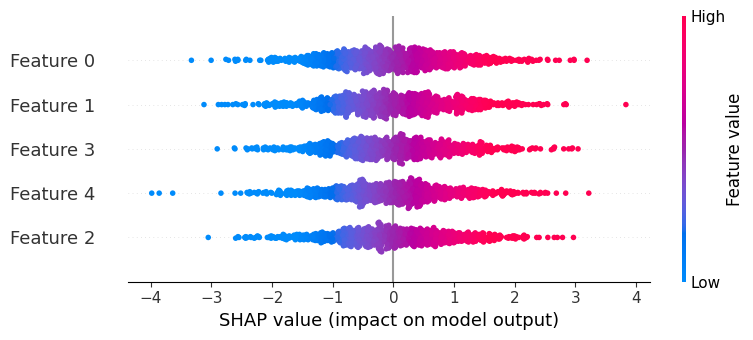

Stopping search: Swarm best objective change less than 1e-08
Optimized Portfolio Weights (PSO): [0.         0.19989303 0.07157044 0.07213124 0.        ]
Optimized Portfolio Weights (SA): [0.         0.2        0.07165352 0.07217444 0.        ]
Refined Tail Risk (99% VaR): 0.5691351063069557


In [38]:
import numpy as np
import shap
from pyswarm import pso
from scipy.optimize import dual_annealing
from scipy.stats import genpareto

# --- Step 1: Portfolio Optimization Constraints ---
# Relaxing the upper bounds for assets to allow more flexibility in optimization
n_assets = 5  # Number of assets
lb = np.zeros(n_assets)  # Lower bounds for weights
ub = np.ones(n_assets) * 0.2  # Upper bounds for weights (relaxed to 20% max)

# --- Step 2: Objective Function ---
def objective_function(weights, X):
    # Portfolio returns and volatility
    portfolio_returns = np.dot(X, weights)
    portfolio_volatility = np.std(portfolio_returns)
    # Return the negative of the Sharpe ratio as we want to maximize it
    return -np.mean(portfolio_returns) / portfolio_volatility

# --- Step 3: PSO Optimization ---
# Improved PSO: Relax bounds and adjust swarm size for better exploration
def optimize_portfolio_pso(X):
    optimal_weights, _ = pso(objective_function, lb, ub, maxiter=3000, swarmsize=100, args=(X,))
    return optimal_weights

# --- Step 4: Simulated Annealing ---
# Adjust Simulated Annealing cooling schedule using dual_annealing
def optimize_portfolio_sa(X):
    result_sa = dual_annealing(objective_function, bounds=list(zip(lb, ub)), maxiter=2000, maxfun=2000, args=(X,))
    return result_sa.x

# --- Step 5: Tail Risk Estimation using EVT and GPD ---
def gpd_tail_risk(returns, threshold=0.05):
    excess_returns = returns[returns > threshold] - threshold
    params = genpareto.fit(excess_returns)  # Fit GPD to excess returns
    tail_risk = genpareto.ppf(0.99, *params)  # Value at Risk (99% quantile)
    return tail_risk

# --- Step 6: Model Interpretability (SHAP) ---
# Assuming we have a model (e.g., linear regression) for portfolio performance
# Here we simulate it using a dummy model
class DummyModel:
    def predict(self, X):
        return np.dot(X, np.ones(X.shape[1]))  # Simple model: sum of all features

model = DummyModel()

# Explain the model's predictions using SHAP
explainer = shap.KernelExplainer(model.predict, X)
shap_values = explainer.shap_values(X)

# Visualize the SHAP values to understand feature importance
shap.summary_plot(shap_values, X)

# --- Step 7: Main Execution ---
# Example data (replace with your actual data)
X = np.random.randn(1000, n_assets)  # Simulated returns data (1000 samples, 5 assets)

# Perform PSO optimization
optimized_weights_pso = optimize_portfolio_pso(X)
print(f"Optimized Portfolio Weights (PSO): {optimized_weights_pso}")

# Perform Simulated Annealing optimization
optimized_weights_sa = optimize_portfolio_sa(X)
print(f"Optimized Portfolio Weights (SA): {optimized_weights_sa}")

# Compute tail risk
portfolio_returns = np.dot(X, optimized_weights_sa)  # Using SA optimized weights
tail_risk = gpd_tail_risk(portfolio_returns)
print(f"Refined Tail Risk (99% VaR): {tail_risk}")
